# Import libraries

In [474]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [475]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [476]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [477]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [478]:
def norm_filter(adata, mito_genes, RB_genes_in_data
                , log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1) - np.log2(0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [479]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [480]:
def files_MAST(adata, cell_type = '', outdir = ''):
    
    # if directory doesn't exist, create it
    if not os.path.exists('../DEA/' + cell_type):
        os.makedirs('../DEA/' + cell_type)
    
    adata_celltype = deepcopy(adata)
    print(cell_type + '\t'+"Dimensions" + "\t"+ "{}".format(adata_celltype.shape))
    
    # make a dataframe for the expression matrix
    expmat = pd.DataFrame(adata_celltype.X, columns = adata_celltype.var.index, index = adata_celltype.obs.index)

    # make a dataframe for the observation data
    cdata = pd.DataFrame(adata_celltype.obs, columns=adata_celltype.obs.columns, index = adata_celltype.obs.index)
    
    expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
    cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)
    
    print("Files written for {}".format(cell_type))

In [481]:
def run_MAST_for_celltype_condition(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST_condition.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file )
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

def run_MAST_for_celltype(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
    output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

In [482]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [483]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = '../input/'
outdir = '../output_Nov/'
figures = '../figures/'

In [11]:
adata_microglia_only = sc.read_h5ad(outdir+'adata_high_var_Microglia_ONLY_clusters.h5ad')

# Subset Astrocytes Brainstem & Input original Adata

In [15]:
adata_microglia_BS = adata_microglia_only.copy()
adata_microglia_BS = adata_microglia_BS[adata_microglia_BS.obs['B_region'].isin(['BrainStem']),:]
adata_microglia_BS.shape

(462, 9644)

In [16]:
adata_microglia_BS.obs.Condition.value_counts()

VE         372
Control     90
Name: Condition, dtype: int64

In [17]:
broad_clusters = adata_microglia_BS.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_microglia_BS.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

Cell counts in each cluster for each sample: 
Cluster: Control
Counter({'1820_C1029_Ctrl_ES_BS_IGO_10856_3': 90})
Cluster: VE
Counter({'1822_996_VE_ES_BS_IGO_10875_7': 372})


In [18]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

AnnData object with n_obs × n_vars = 26101 × 22292
    obs: 'Sample ID'


Sample ID  \
cell_barcodes                                                                              
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   

                                                   Condition  
cell_barcodes                                                 
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control

In [19]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

0

In [21]:
adata_microglia_BS = adata[adata_microglia_BS.obs.index, :]
adata_microglia_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(462, 22292)

# Pre-processing

## QC

In [22]:
adata_microglia_BS, mito_genes, RB_genes_in_data = qc_metrics(adata_microglia_BS)
markers = []
if type(adata_microglia_BS.X)==np.ndarray:
    pass
else:
    print(type(adata_microglia_BS.X))
    #print(adata_norm.X.shape)
    adata_microglia_BS.X = adata_microglia_BS.X.toarray()
    #print(adata_norm.X.shape)
adata_microglia_BS.X = pd.DataFrame(data=adata_microglia_BS.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [23]:
adata_microglia_BS.shape

(462, 22292)

## Normalization

In [24]:
markers = []
adata_microglia_BS, markers = norm_filter(adata_microglia_BS, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_microglia_BS.obs.head()

(462, 22292)
(462, 8893)
(462, 8767)
(462, 8756)
True
Im here2


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


2000
2000


Sample ID  \
cell_barcodes                                                                  
160364257209772_1822_996_VE_ES_BS_IGO_10875_7  1822_996_VE_ES_BS_IGO_10875_7   
227295654233972_1822_996_VE_ES_BS_IGO_10875_7  1822_996_VE_ES_BS_IGO_10875_7   
134402878592932_1822_996_VE_ES_BS_IGO_10875_7  1822_996_VE_ES_BS_IGO_10875_7   
232252180118315_1822_996_VE_ES_BS_IGO_10875_7  1822_996_VE_ES_BS_IGO_10875_7   
231916111509427_1822_996_VE_ES_BS_IGO_10875_7  1822_996_VE_ES_BS_IGO_10875_7   

                                              Condition   B_region  \
cell_barcodes                                                        
160364257209772_1822_996_VE_ES_BS_IGO_10875_7        VE  BrainStem   
227295654233972_1822_996_VE_ES_BS_IGO_10875_7        VE  BrainStem   
134402878592932_1822_996_VE_ES_BS_IGO_10875_7        VE  BrainStem   
232252180118315_1822_996_VE_ES_BS_IGO_10875_7        VE  BrainStem   
231916111509427_1822_996_VE_ES_BS_IGO_10875_7        VE  BrainStem   

                                               n_genes_by_counts  \
cell_barcodes                                                      
160364257209772_1822_996_VE_ES_BS_IGO_10875_7               1221   
227295654233972_1822_996_VE_ES_BS_IGO_10875_7               1063   
134402878592932_1822_996_VE_ES_BS_IGO_10875_7                518   
232252180118315_1822_996_VE_ES_BS_IGO_10875_7                872   
231916111509427_1822_996_VE_ES_BS_IGO_10875_7               1322   

                                               log1p_n_genes_by_counts  \
cell_barcodes                                                            
160364257209772_1822_996_VE_ES_BS_IGO_10875_7                 7.108244   
227295654233972_1822_996_VE_ES_BS_IGO_10875_7                 6.969791   
134402878592932_1822_996_VE_ES_BS_IGO_10875_7                 6.251904   
232252180118315_1822_996_VE_ES_BS_IGO_10875_7                 6.771936   
231916111509427_1822_996_VE_ES_BS_IGO_10875_7                 7.187657   

                                               total_counts  \
cell_barcodes                                                 
160364257209772_1822_996_VE_ES_BS_IGO_10875_7        1794.0   
227295654233972_1822_996_VE_ES_BS_IGO_10875_7        1468.0   
134402878592932_1822_996_VE_ES_BS_IGO_10875_7         630.0   
232252180118315_1822_996_VE_ES_BS_IGO_10875_7        1131.0   
231916111509427_1822_996_VE_ES_BS_IGO_10875_7        1854.0   

                                               log1p_total_counts  \
cell_barcodes                                                       
160364257209772_1822_996_VE_ES_BS_IGO_10875_7            7.492760   
227295654233972_1822_996_VE_ES_BS_IGO_10875_7            7.292337   
134402878592932_1822_996_VE_ES_BS_IGO_10875_7            6.447306   
232252180118315_1822_996_VE_ES_BS_IGO_10875_7            7.031741   
231916111509427_1822_996_VE_ES_BS_IGO_10875_7            7.525640   

                                               pct_counts_in_top_50_genes  \
cell_barcodes                                                               
160364257209772_1822_996_VE_ES_BS_IGO_10875_7                   18.784838   
227295654233972_1822_996_VE_ES_BS_IGO_10875_7                   17.438692   
134402878592932_1822_996_VE_ES_BS_IGO_10875_7                   23.809524   
232252180118315_1822_996_VE_ES_BS_IGO_10875_7                   17.595049   
231916111509427_1822_996_VE_ES_BS_IGO_10875_7                   14.994606   

                                               pct_counts_in_top_100_genes  \
cell_barcodes                                                                
160364257209772_1822_996_VE_ES_BS_IGO_10875_7                    27.201784   
227295654233972_1822_996_VE_ES_BS_IGO_10875_7                    25.749319   
134402878592932_1822_996_VE_ES_BS_IGO_10875_7                    33.650794   
232252180118315_1822_996_VE_ES_BS_IGO_10875_7                    26.436782   
231916111509427_1822_996_VE_ES_BS_IGO_10875_7                    23.085221   

      

## PCA

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        3.5562873 ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 3.4827096 0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
(462, 8756)
(462, 8756)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


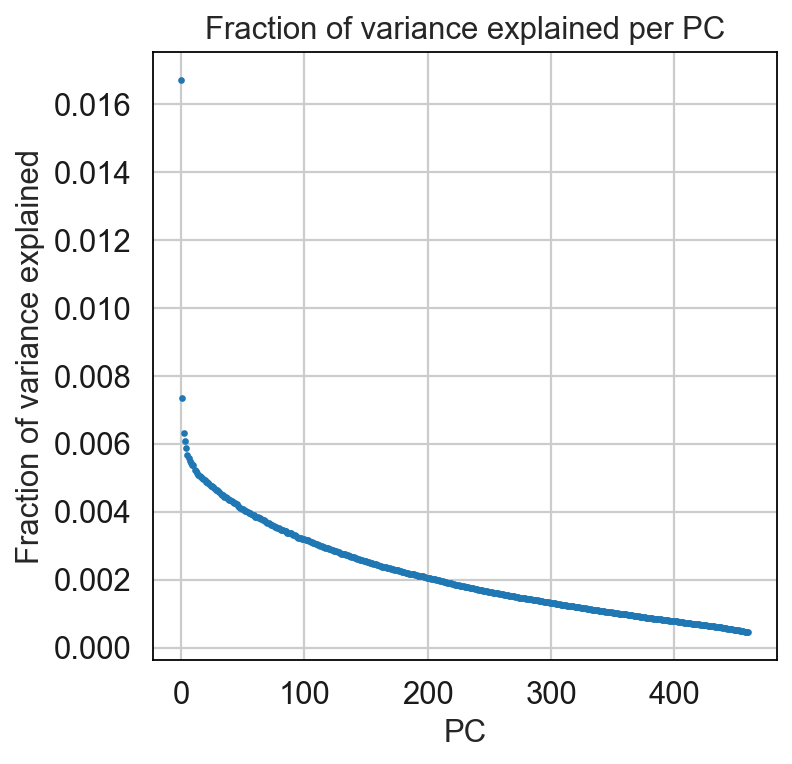

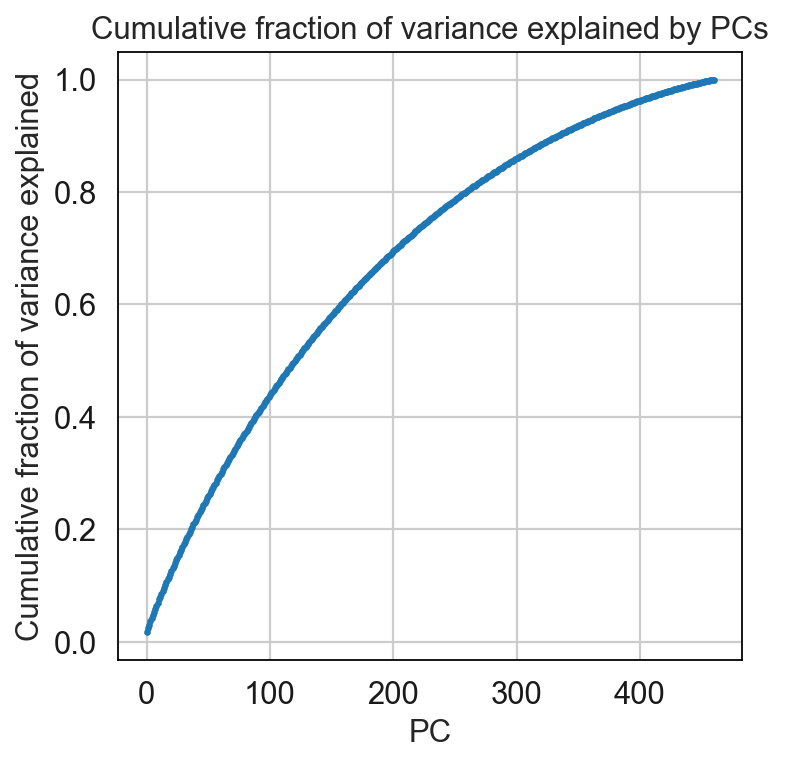

Knee point: 14
Explained variance: 0.09586269


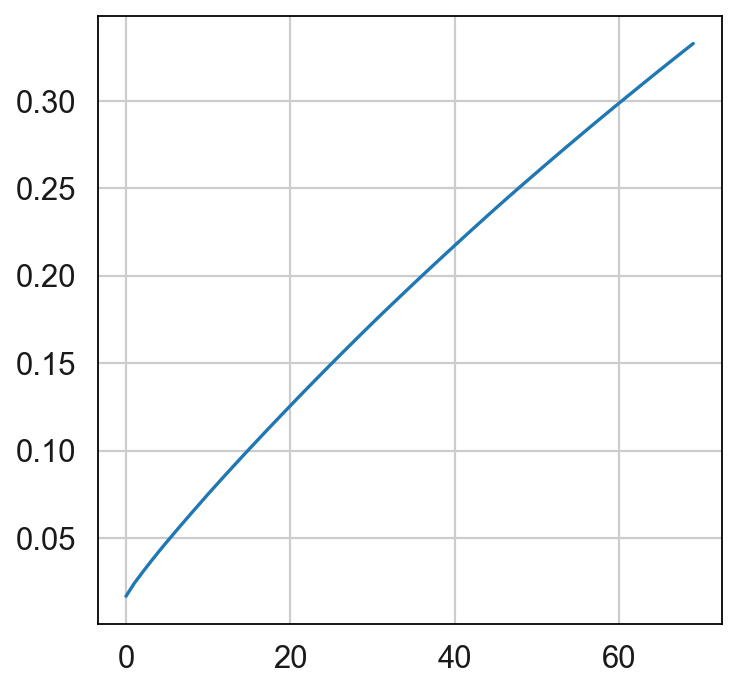

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


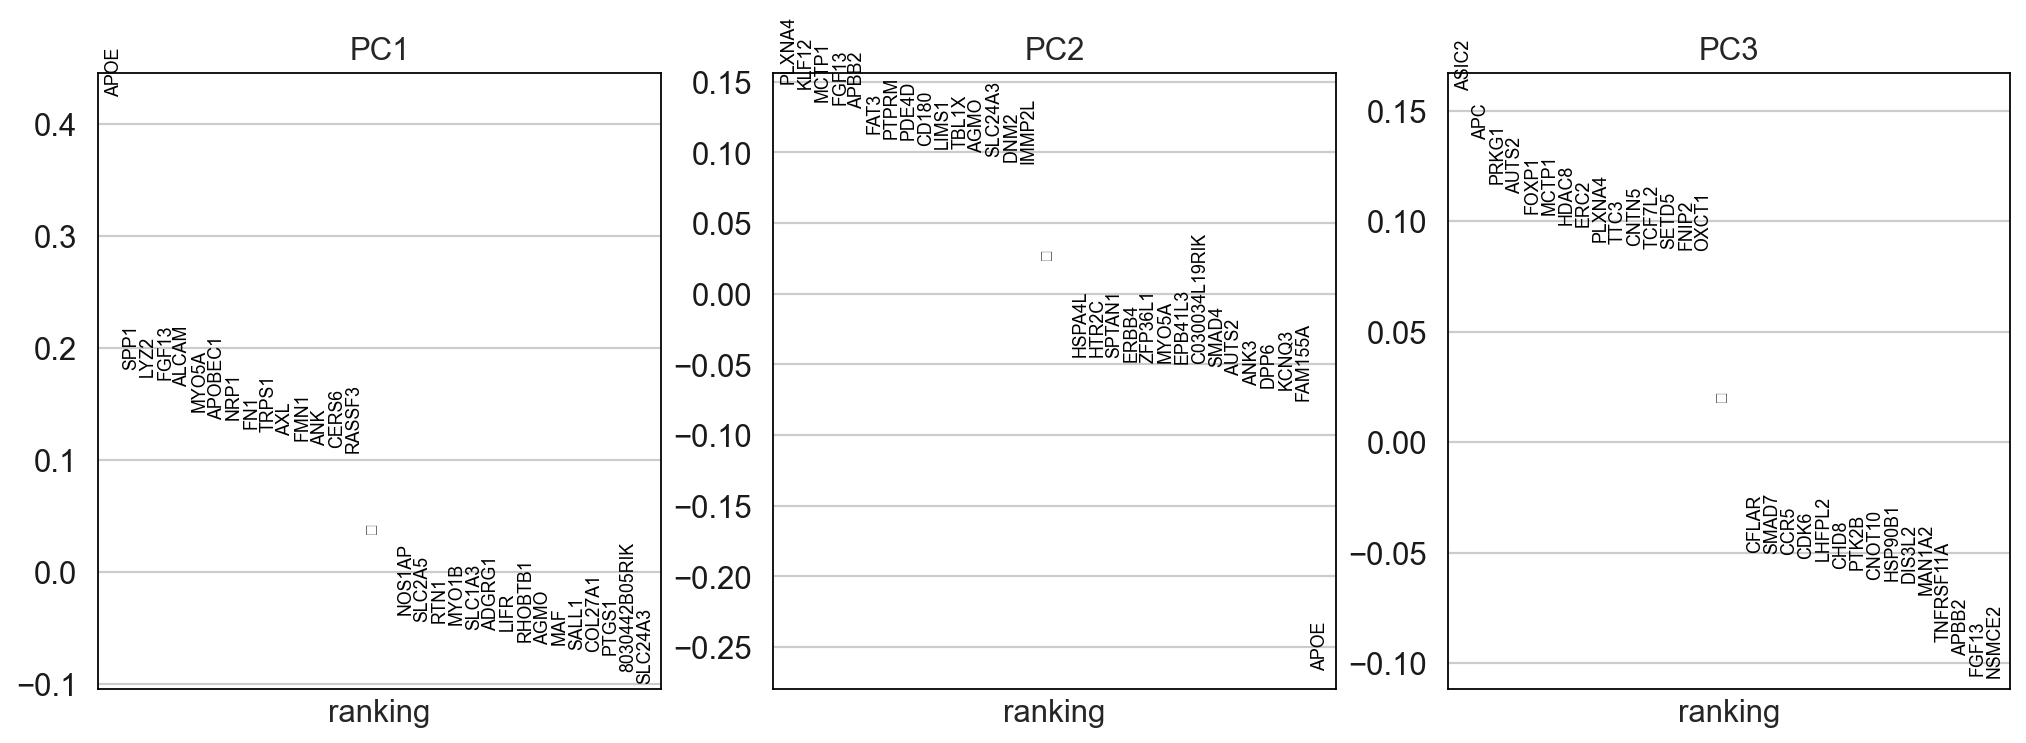

(462, 8756)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [25]:
sc.set_figure_params(figsize=(5, 5))
adata_microglia_BS = run_pca_knee(adata_microglia_BS)#, 0.5)
adata_microglia_BS.obs['PC 1'] = adata_microglia_BS.obsm['X_pca'][:,0] # optional
adata_microglia_BS.obs['PC 2'] = adata_microglia_BS.obsm['X_pca'][:,1]
adata_microglia_BS.obs['PC 3'] = adata_microglia_BS.obsm['X_pca'][:,2]

print(adata_microglia_BS.shape)
adata_microglia_BS.X = pd.DataFrame(adata_microglia_BS.X).fillna(0).values
index_list = np.arange(adata_microglia_BS.shape[0])
np.random.shuffle(index_list)
adata_microglia_BS = adata_microglia_BS[index_list,:]

In [26]:
print(adata_microglia_BS.shape)
adata_microglia_BS.X = pd.DataFrame(adata_microglia_BS.X).fillna(0).values
index_list = np.arange(adata_microglia_BS.shape[0])
np.random.shuffle(index_list)
adata_microglia_BS = adata_microglia_BS[index_list,:]

(462, 8756)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.06274986267089844 seconds
Jaccard graph constructed in 2.0548973083496094 seconds
Wrote graph to binary file in 0.0073070526123046875 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.601018
Louvain completed 21 runs in 0.31046485900878906 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.133897066116333 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.009930849075317383 seconds
Jaccard graph constructed in 0.9346771240234375 seconds
Wrote graph to binary file in 0.18224573135375977 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.533513
After 2 runs, maximum modularity is Q = 0.534657
After 6 runs, maximum modularity is Q = 0.538833
After 14 runs, maximum modularity is Q = 0.540836
Louvain completed 34 runs in 0.563532829284668 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.333556890487671 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.009638071060180664 seconds
Jaccard graph constructed in 0.8495512008666992 seconds
Wrote graph to binary file in 0.014615058898925781 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.484568
After 4 runs, maximum modularity is Q = 0.493234

Text(0.5, 0, 'k')

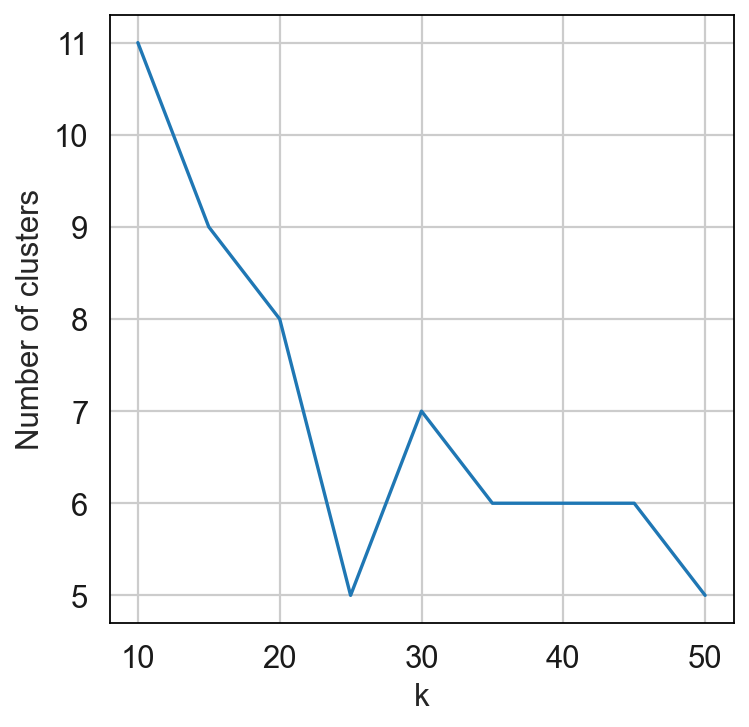

In [27]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_microglia_BS.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_microglia_BS.obs['PhenoGraph_clusters_mic_BS'+str(k)] = pd.Categorical(communities)
    adata_microglia_BS.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_microglia_BS.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [28]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_microglia_BS.obs['PhenoGraph_clusters_mic_BS'+str(k_list[run1])].values,
            adata_microglia_BS.obs['PhenoGraph_clusters_mic_BS'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

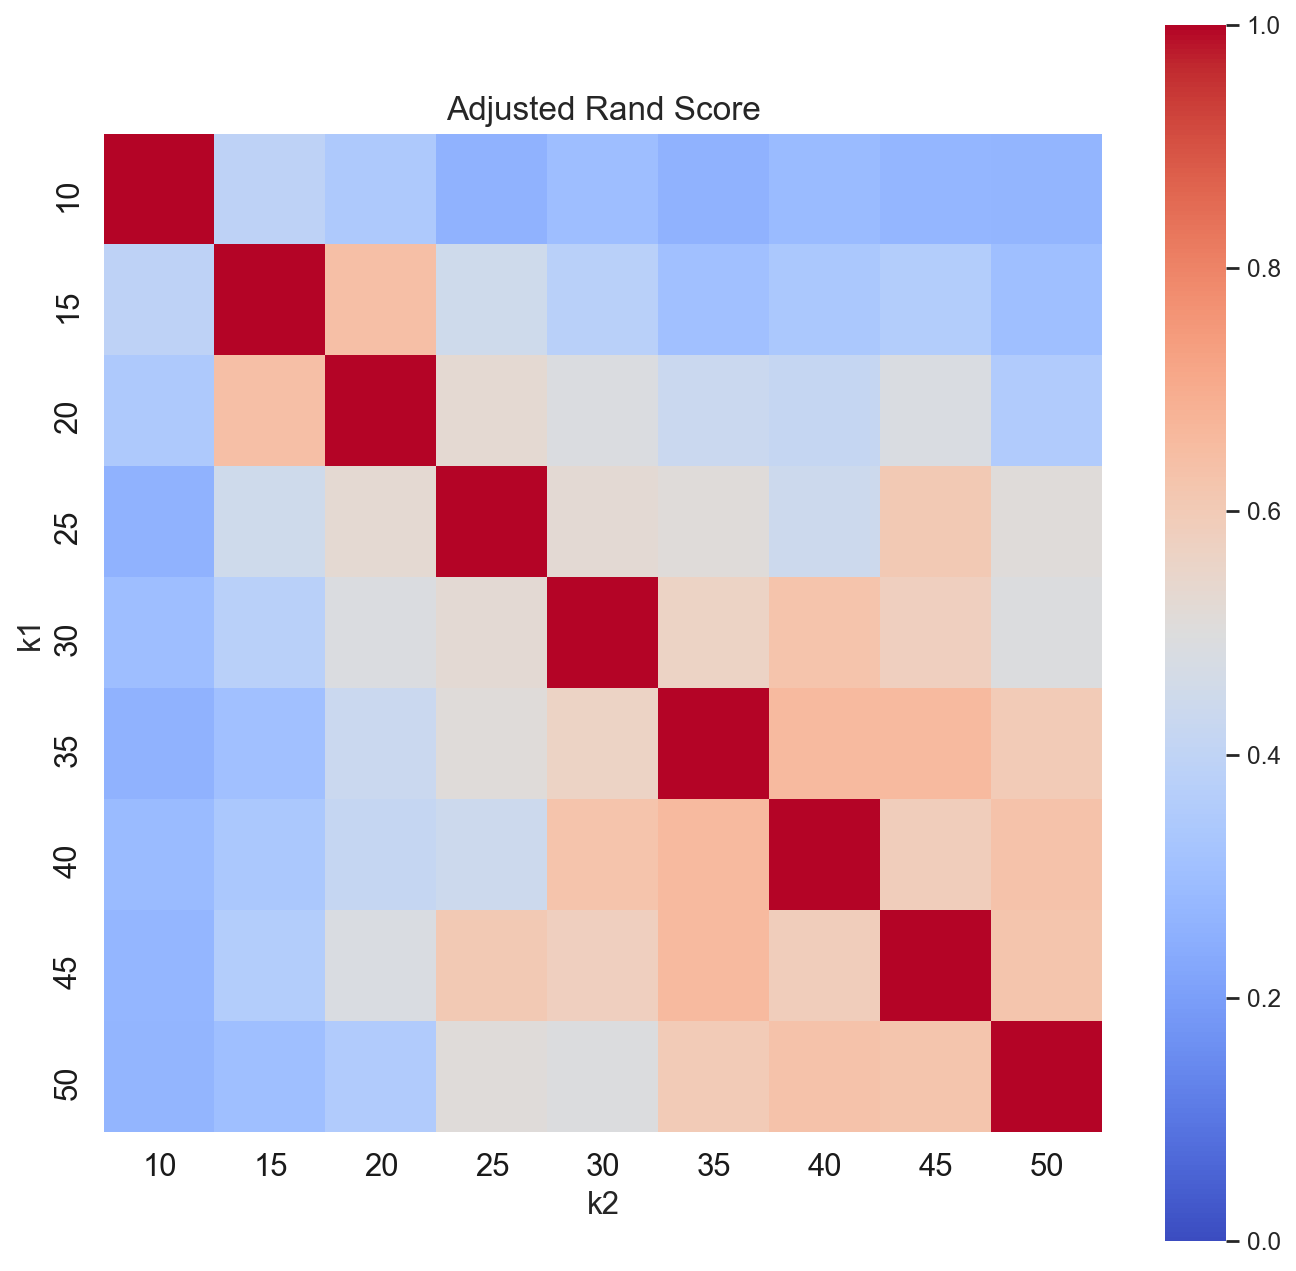

In [29]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [30]:
k = 35 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_microglia_BS.obsm['X_pca']),k=k) # run PhenoGraph
adata_microglia_BS.obs['PhenoGraph_clusters_mic_BS'] = pd.Categorical(communities)
adata_microglia_BS.uns['PhenoGraph_Q'] = Q
adata_microglia_BS.uns['PhenoGraph_k'] = k

Finding 35 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.010787248611450195 seconds
Jaccard graph constructed in 0.9256167411804199 seconds
Wrote graph to binary file in 0.1110692024230957 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.410047
After 3 runs, maximum modularity is Q = 0.412423
After 8 runs, maximum modularity is Q = 0.417603
Louvain completed 28 runs in 0.45723390579223633 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.1912331581115723 seconds


# Vizualization & Markers

## Vizualize Astro BS sub-clusters

In [32]:
sc.set_figure_params(figsize=(8, 8))
sc.pp.neighbors(adata_microglia_BS, method='umap', use_rep='X_pca')
sc.tl.umap(adata_microglia_BS, random_state=None)

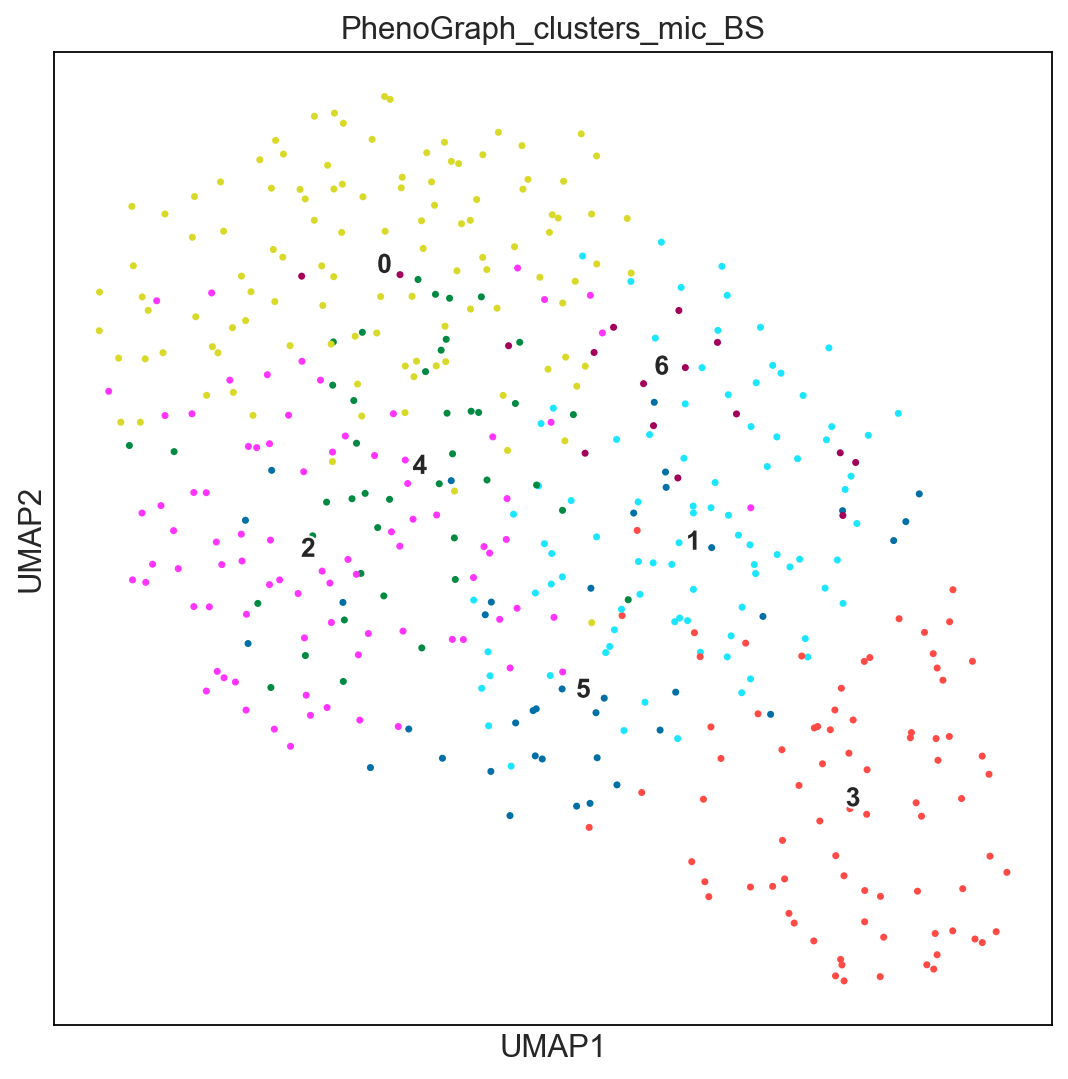

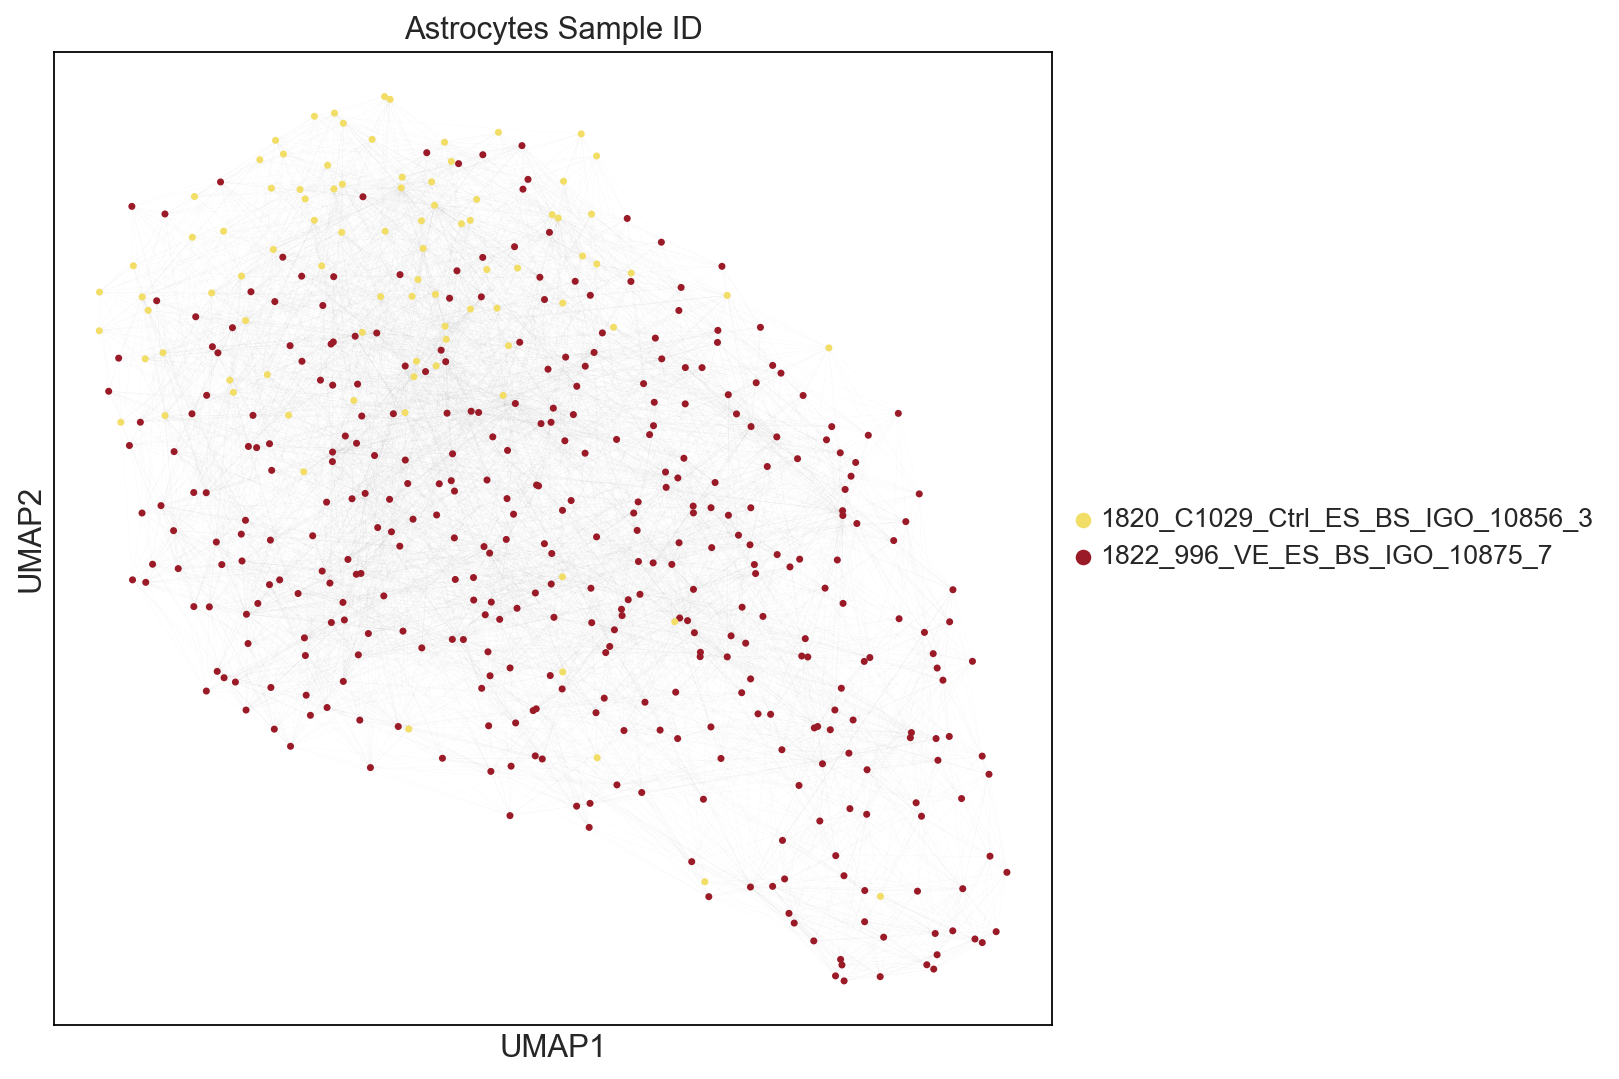

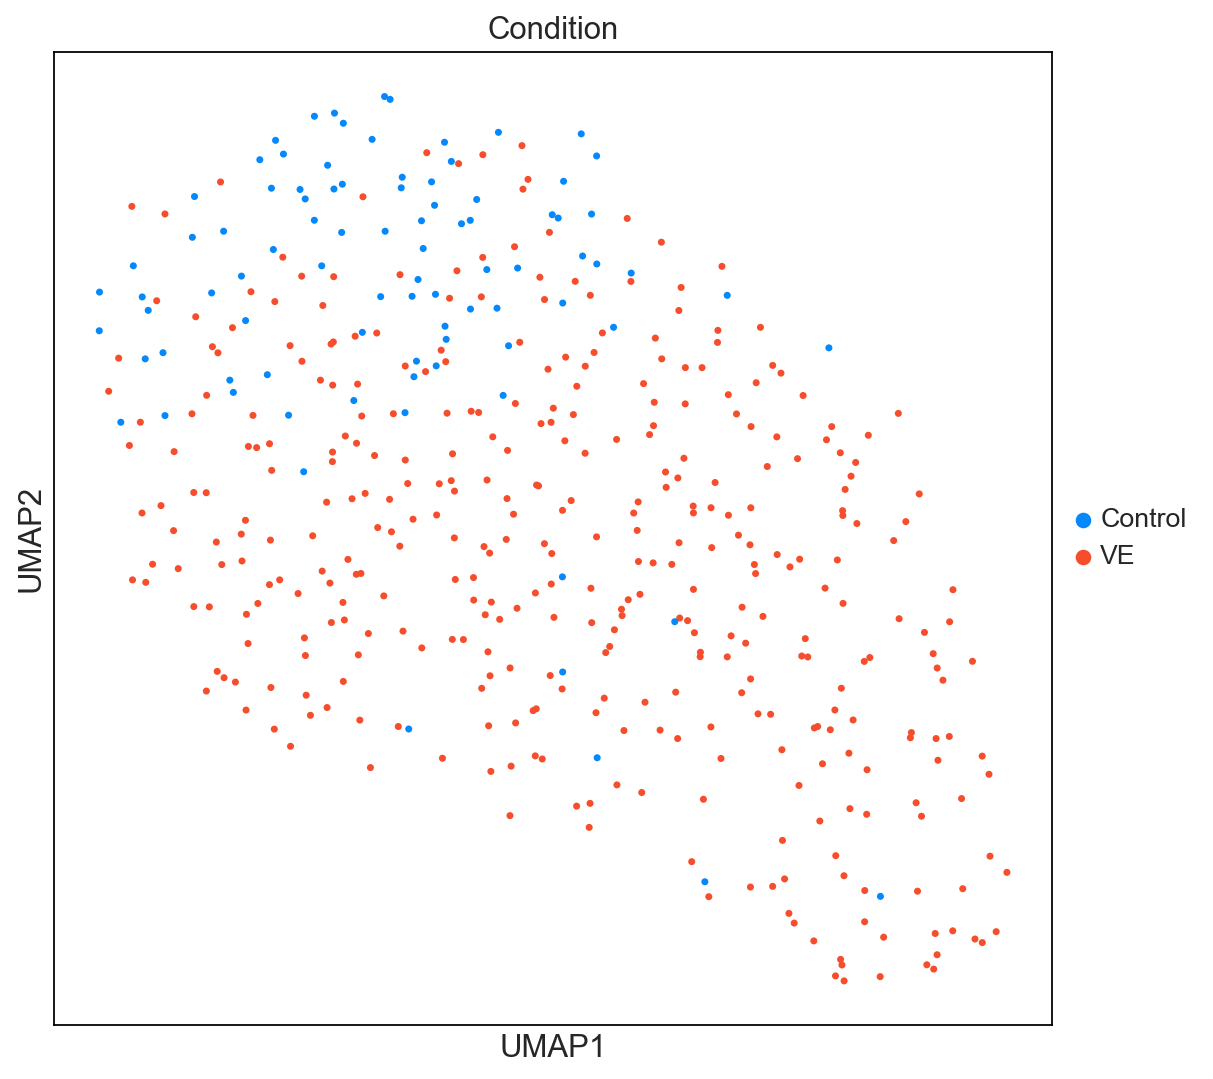

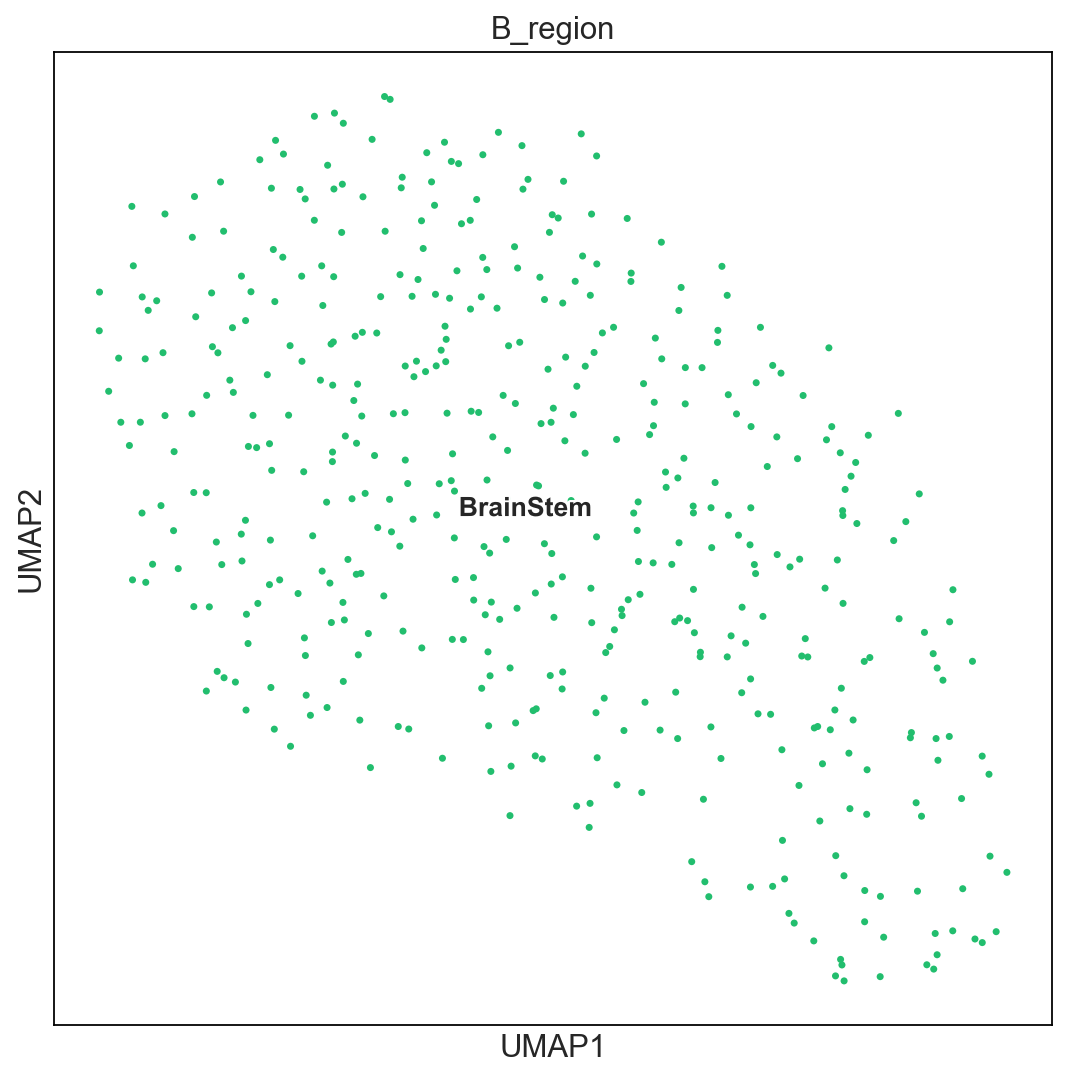

In [33]:
sc.pl.umap(adata_microglia_BS,
           color=['PhenoGraph_clusters_mic_BS'],
           ncols=2,
           sort_order=False,
           palette=godsnot_64, # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 40,
           legend_fontoutline=2,)

sc.pl.umap(adata_microglia_BS, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=40, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Sample ID"])

sc.pl.umap(adata_microglia_BS,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 40,
           legend_fontoutline=2)

sc.pl.umap(adata_microglia_BS,
           color=['B_region'],
           ncols=2,
           sort_order=False,
           palette= ["#22BE6E", "#EDAB13"], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 40,
           legend_fontoutline=2)



## Find markers (Oligo clusters)

In [34]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Mic_BS_0',
    1 : 'Mic_BS_1',
    2 : 'Mic_BS_2',
    3 : 'Mic_BS_3',
    4 : 'Mic_BS_4',
    5 : 'Mic_BS_5',
    6 : 'Mic_BS_6',}

adata_microglia_BS.obs['PhenoGraph_clusters_mic_BS_str'] = adata_microglia_BS.obs['PhenoGraph_clusters_mic_BS'].map(cl_int_to_str).astype('category')

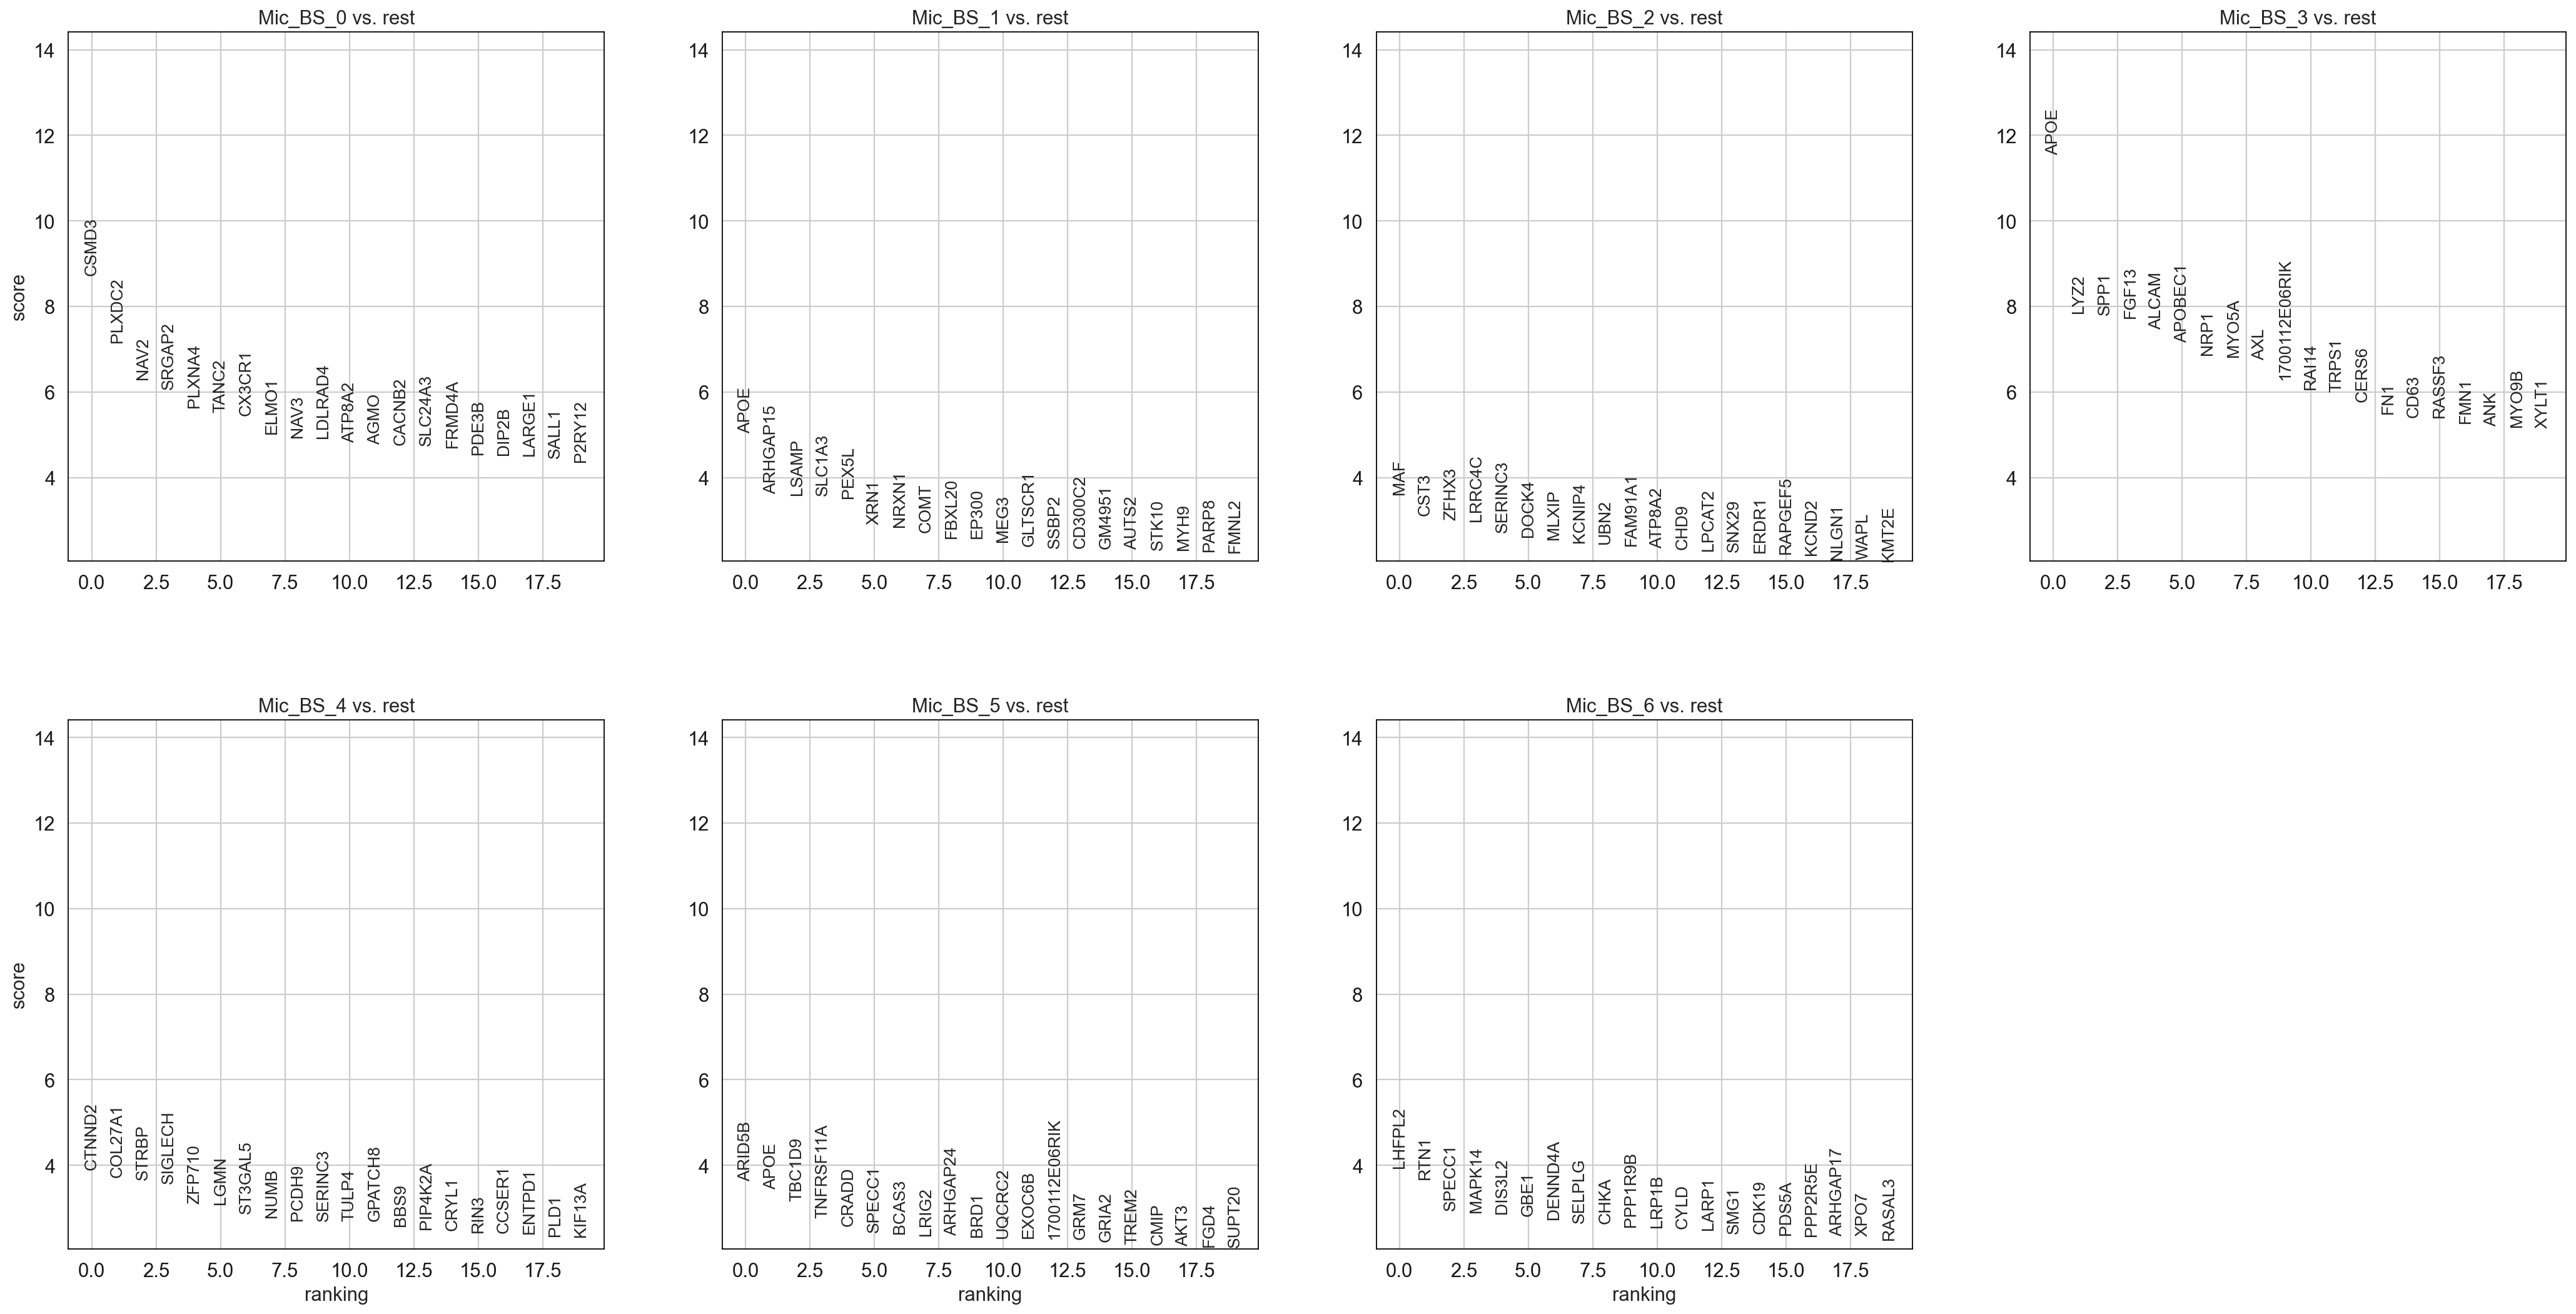

In [35]:
sc.tl.rank_genes_groups(adata_microglia_BS, groupby='PhenoGraph_clusters_mic_BS_str', key_added="ranked_genes_pheno_mic", method='wilcoxon')
sc.pl.rank_genes_groups(adata_microglia_BS, key = 'ranked_genes_pheno_mic', fontsize=12)

In [37]:
n_genes = 10000
key_ad ='ranked_genes_pheno_mic'
result = adata_microglia_BS.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [38]:
pval_table

Mic_BS_0_n  Mic_BS_0_l    Mic_BS_0_p Mic_BS_1_n  Mic_BS_1_l  Mic_BS_1_p  \
0         CSMD3    2.546427  2.132481e-14       APOE    3.044508    0.003992   
1        PLXDC2    1.403318  2.280901e-09   ARHGAP15    1.446996    0.500832   
2          NAV2    1.546984  6.241035e-07      LSAMP    0.741308    0.500832   
3        SRGAP2    1.295775  2.321233e-06     SLC1A3    1.720713    0.500832   
4        PLXNA4    2.402993  2.380182e-05      PEX5L    2.276084    0.519053   
...         ...         ...           ...        ...         ...         ...   
8751     ATP8A1   -1.009339  6.884416e-02      APBB2   -1.664066    0.999762   
8752      MYO5A   -2.034076  4.815933e-02         QK   -1.029293    0.999762   
8753       CTSH   -1.158110  4.542986e-02     SLC8A1   -0.901273    0.999762   
8754      FGF13   -1.933434  8.072458e-03       FAT3   -1.720906    0.500832   
8755       APOE   -6.446826  2.248022e-14      MCTP1   -1.870596    0.500832   

     Mic_BS_2_n  Mic_BS_2_l  Mic_BS_2_p Mic_BS_3_n  ...    Mic_BS_3_p  \
0           MAF    1.584861    0.866677       APOE  ...  5.925620e-27   
1          CST3    0.635985    0.999982       LYZ2  ...  9.462611e-12   
2         ZFHX3    0.793614    0.999982       SPP1  ...  1.054066e-11   
3        LRRC4C    0.947270    0.999982      FGF13  ...  1.508307e-11   
4       SERINC3    0.501070    0.999982      ALCAM  ...  8.815223e-11   
...         ...         ...         ...        ...  ...           ...   
8751     RNF150   -2.097923    0.999982      TANC2  ...  1.085773e-09   
8752      CADM1   -1.612640    0.999982       CST3  ...  4.581954e-10   
8753      OXCT1   -1.929278    0.999982     SRGAP2  ...  3.388963e-11   
8754       NRP1   -2.646857    0.498078     SELPLG  ...  9.462611e-12   
8755       APOE   -4.718431    0.000006      CSMD3  ...  1.024123e-18   

      Mic_BS_4_n Mic_BS_4_l  Mic_BS_4_p  Mic_BS_5_n Mic_BS_5_l  Mic_BS_5_p  \
0         CTNND2   2.423927    0.413739      ARID5B   2.178257    0.999722   
1        COL27A1   2.029782    0.531489        APOE   2.984204    0.999722   
2          STRBP   2.230650    0.531489      TBC1D9   1.933553    0.999722   
3        SIGLECH   1.877329    0.615717   TNFRSF11A   1.599262    0.999722   
4         ZFP710   1.258292    1.000000       CRADD   1.845917    0.999722   
...          ...        ...         ...         ...        ...         ...   
8751      LHFPL2  -2.233999    1.000000       TAOK1  -2.376507    0.999722   
8752     APOBEC1  -4.863971    1.000000       KMT2E  -1.964307    0.999722   
8753        RTN4  -2.327897    1.000000     APBB1IP  -1.446405    0.999722   
8754         CBL  -2.573464    1.000000      LARGE1  -1.856786    0.999722   
8755        APOE  -4.877013    0.066843       IGF1R  -3.560311    0.999722   

      Mic_BS_6_n Mic_BS_6_l  Mic_BS_6_p  
0         LHFPL2   3.194000    0.687126  
1           RTN1   2.985488    0.999376  
2         SPECC1   2.331282    0.999376  
3         MAPK14   2.377116    0.999376  
4         DIS3L2   2.744809    0.999376  
...          ...        ...         ...  
8751      ARID1B  -1.942486    0.999376  
8752       LSAMP  -1.220357    0.999376  
8753       RSRP1  -2.008222    0.999376  
8754    TBC1D22A  -2.514644    0.999376  
8755       PHF14  -3.871057    0.999376  

[8756 rows x 21 columns]

In [ ]:
pval_table = pval_table.sort_values(by= 'group_0_1_3_4_6VE_l', ascending=False)
pval_table[(pval_table.group_0_1_3_4_6VE_p < 0.05) & (pval_table.group_0_1_3_4_6VE_l > 0.5)].head(10)

In [41]:
adata_microglia_BS.obs.PhenoGraph_clusters_mic_BS.value_counts()

0    113
1     89
2     84
3     79
4     42
5     38
6     17
Name: PhenoGraph_clusters_mic_BS, dtype: int64

## Visualize marker genes using heatmap

In [42]:
adata_microglia_BS.layers['scaled'] = sc.pp.scale(adata_microglia_BS, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_mic_BS_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

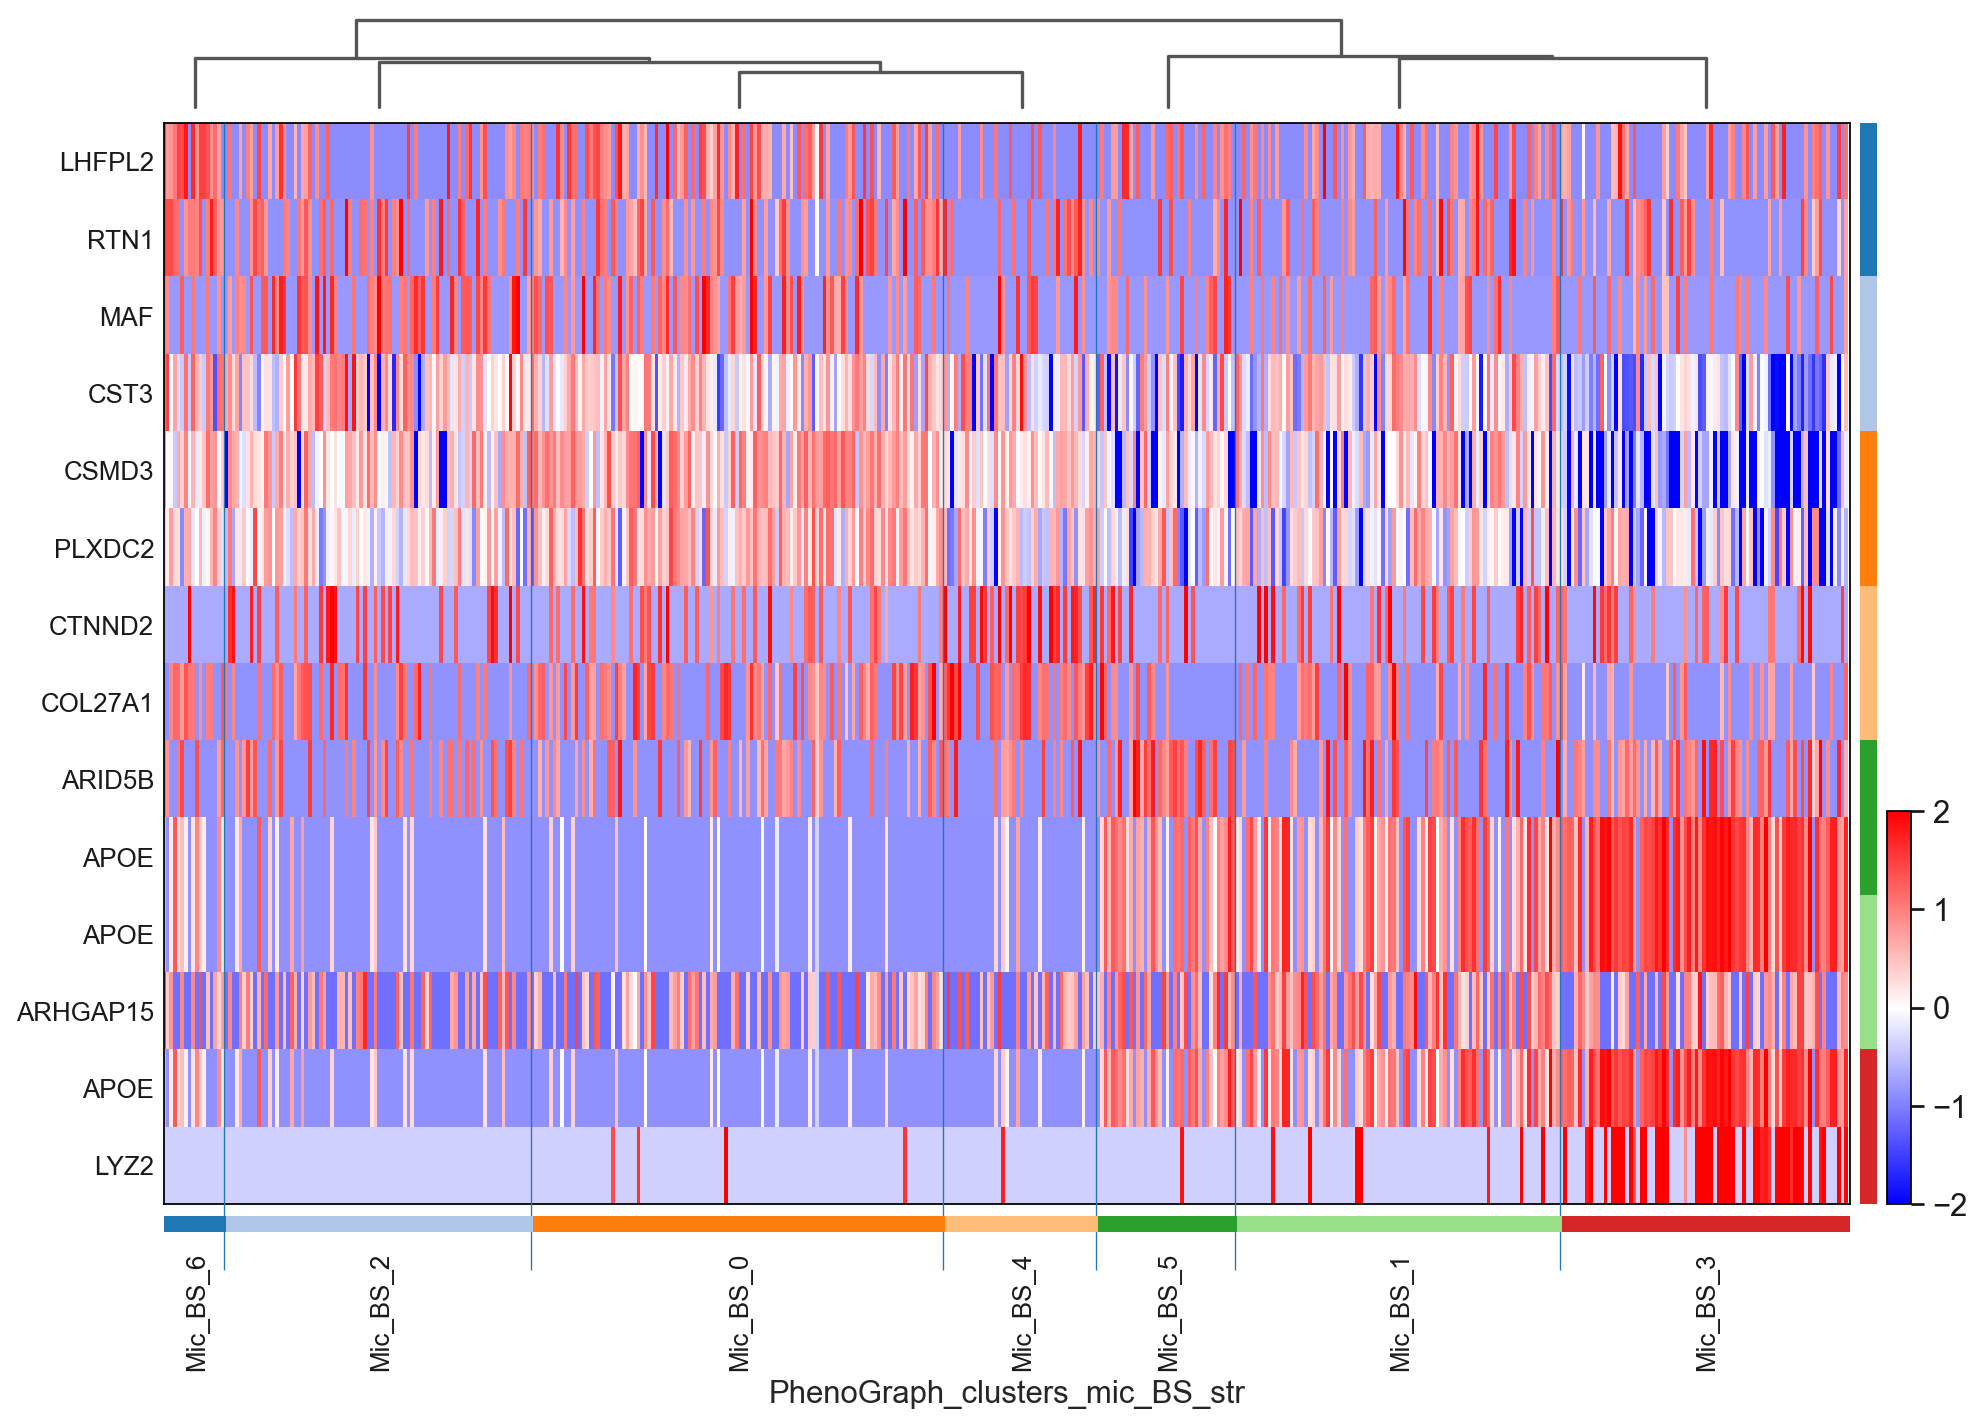

In [230]:
sc.tl.rank_genes_groups(adata_microglia_BS, groupby='PhenoGraph_clusters_mic_BS_str', n_genes=adata_microglia_BS.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_microglia_BS, n_genes=2, use_raw=False, swap_axes=True, vmin=-2, vmax=2, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

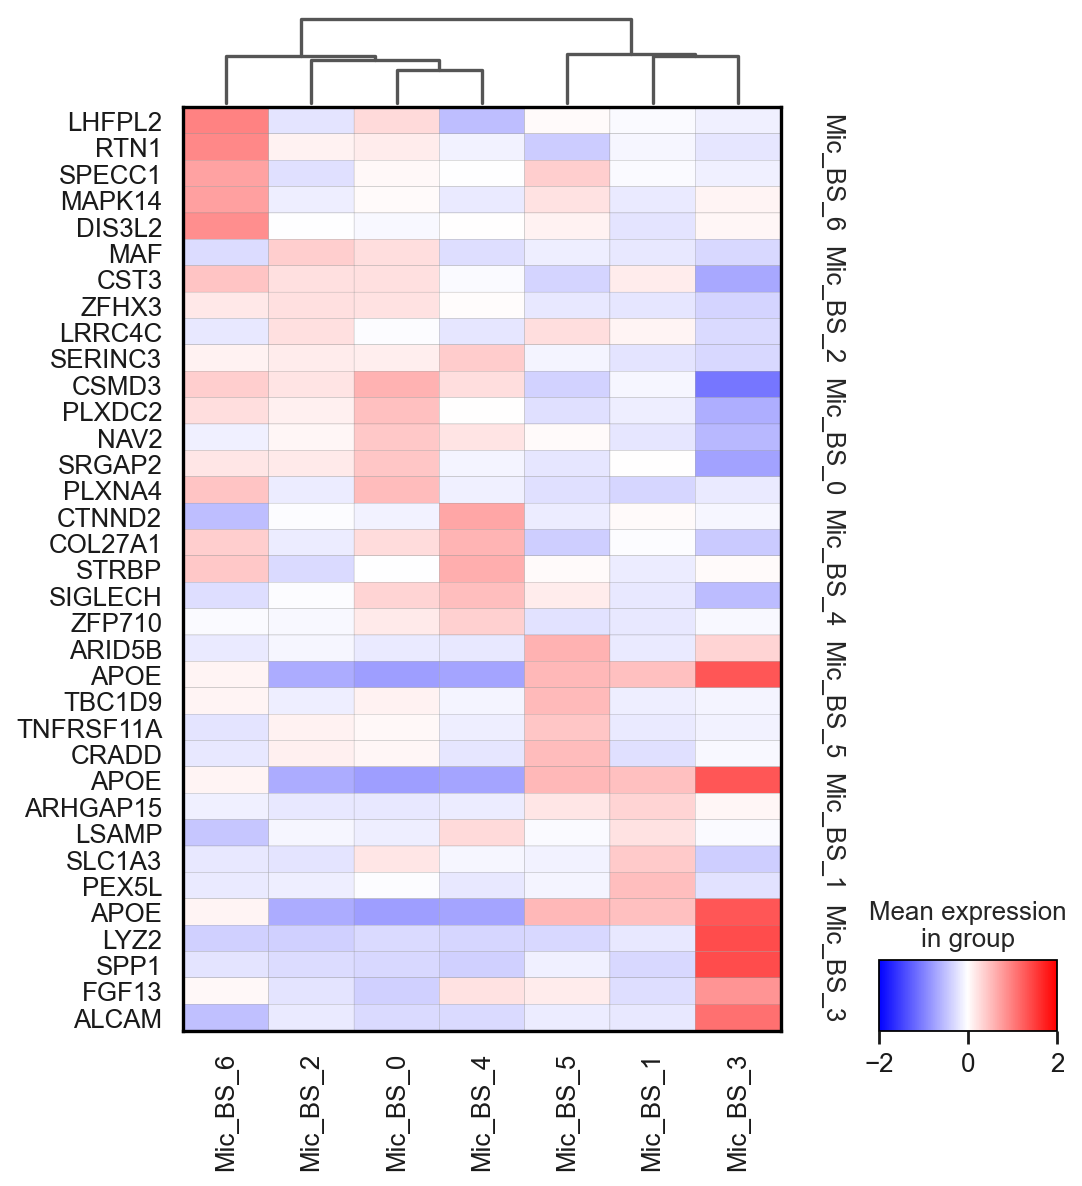

In [233]:
sc.pl.rank_genes_groups_matrixplot(adata_microglia_BS, n_genes=5, use_raw=False, swap_axes=True, vmin=-2, vmax=2, cmap='bwr', layer='scaled', figsize=(7,8), show=False)

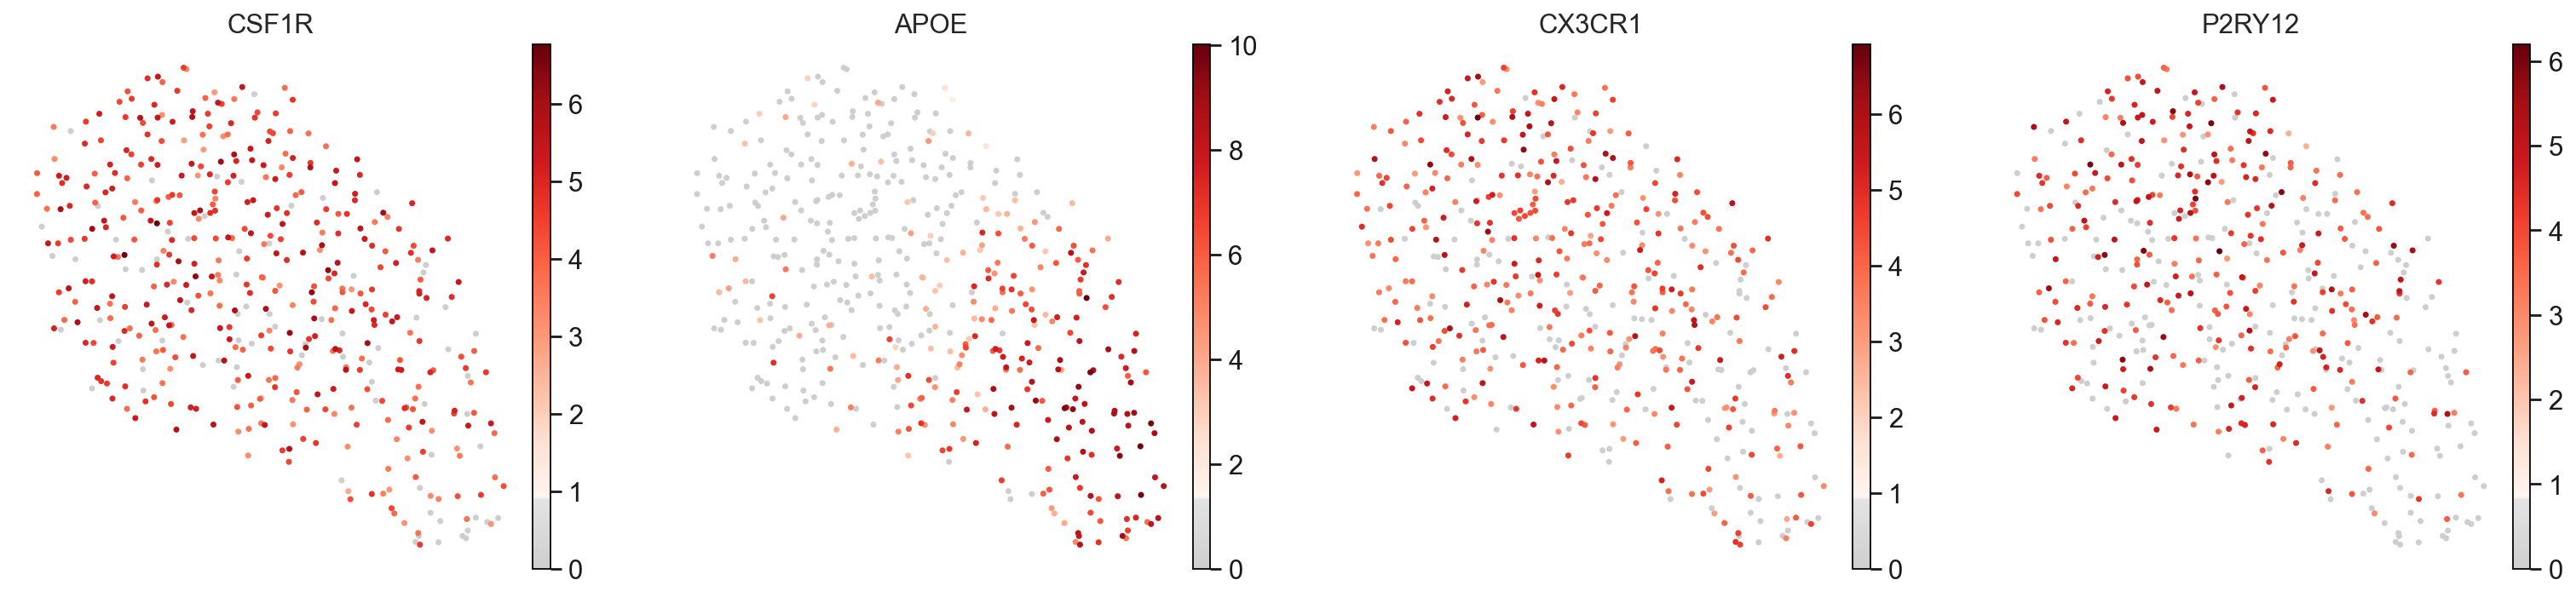

In [234]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_microglia_BS,
           size = 40,
           color=['CSF1R', 'APOE','CX3CR1','P2RY12'],
           color_map=mymap,
          frameon=False, )

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

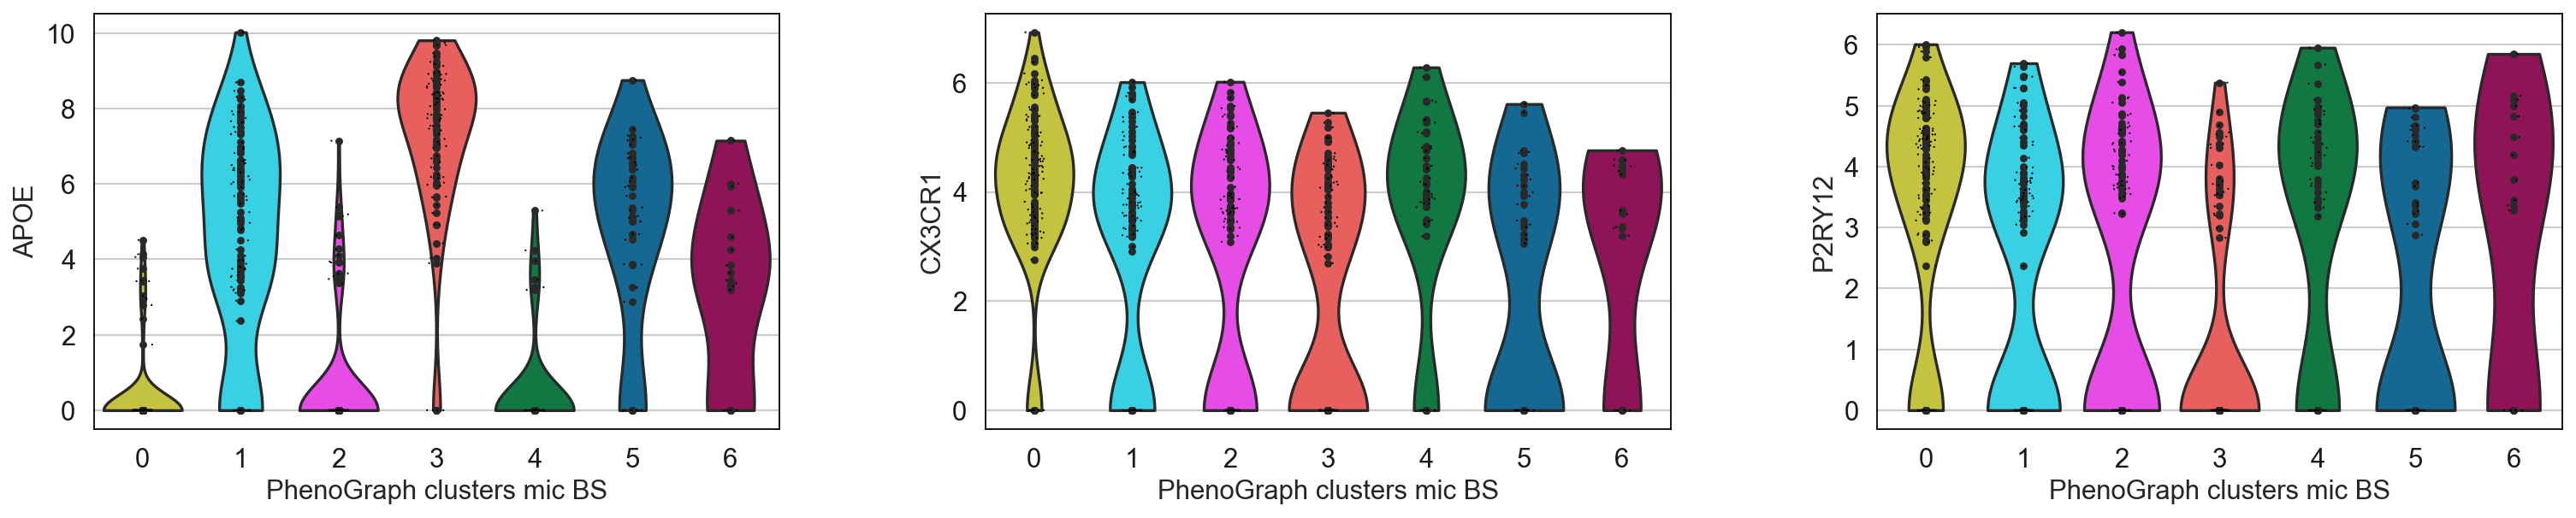

In [54]:
sc.set_figure_params(figsize=(6, 4))
sc.pl.violin(adata_microglia_BS, ['APOE','CX3CR1','P2RY12'], groupby='PhenoGraph_clusters_mic_BS', inner='point', palette = godsnot_64)

[Text(0, 0, 'APOE')]

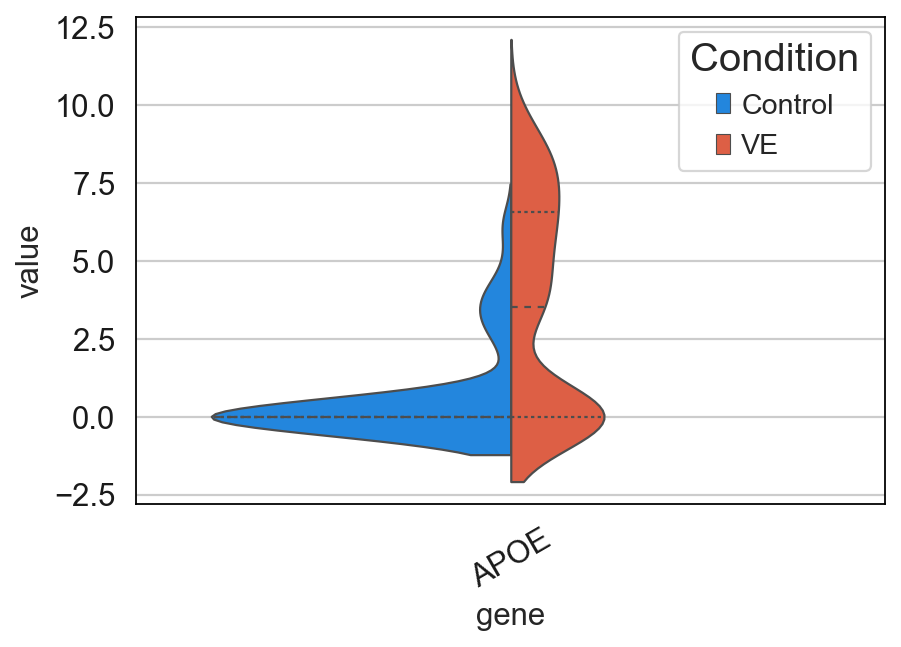

In [106]:
sc.set_figure_params(figsize=(6, 4))
my_genes= ['APOE']
colors_list = ['#0488FC','#F64E2C']
adata = adata_microglia_BS.copy()
df = sc.get.obs_df(adata, [*my_genes, 'Condition'])
df = df.set_index('Condition').stack().reset_index()
df.columns = ['Condition', 'gene', 'value']
import seaborn as sns
v = sns.violinplot(data=df, x='gene', y='value', hue="Condition",
                split=True, inner="quart", linewidth=1, palette=colors_list, legend = False)

v.set_xticklabels(v.get_xticklabels(), rotation=30)

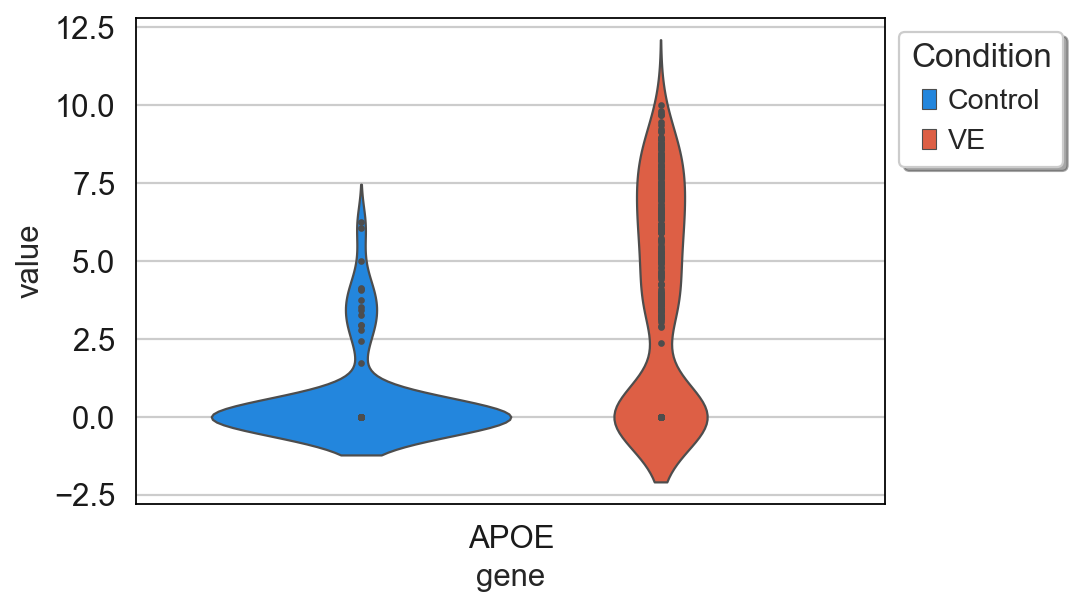

In [107]:
sc.set_figure_params(figsize=(6, 4))

v = sns.violinplot(data=df, x='gene', y='value', hue="Condition",
                split=False, inner="point", linewidth=1, palette=colors_list, legend = False)


v.legend(bbox_to_anchor=(1, 1), loc=2, title="Condition", \
               title_fontsize = 15, \
               shadow = True, \
               facecolor = 'white')

#v.set_xticklabels(v.get_xticklabels(), rotation=30)


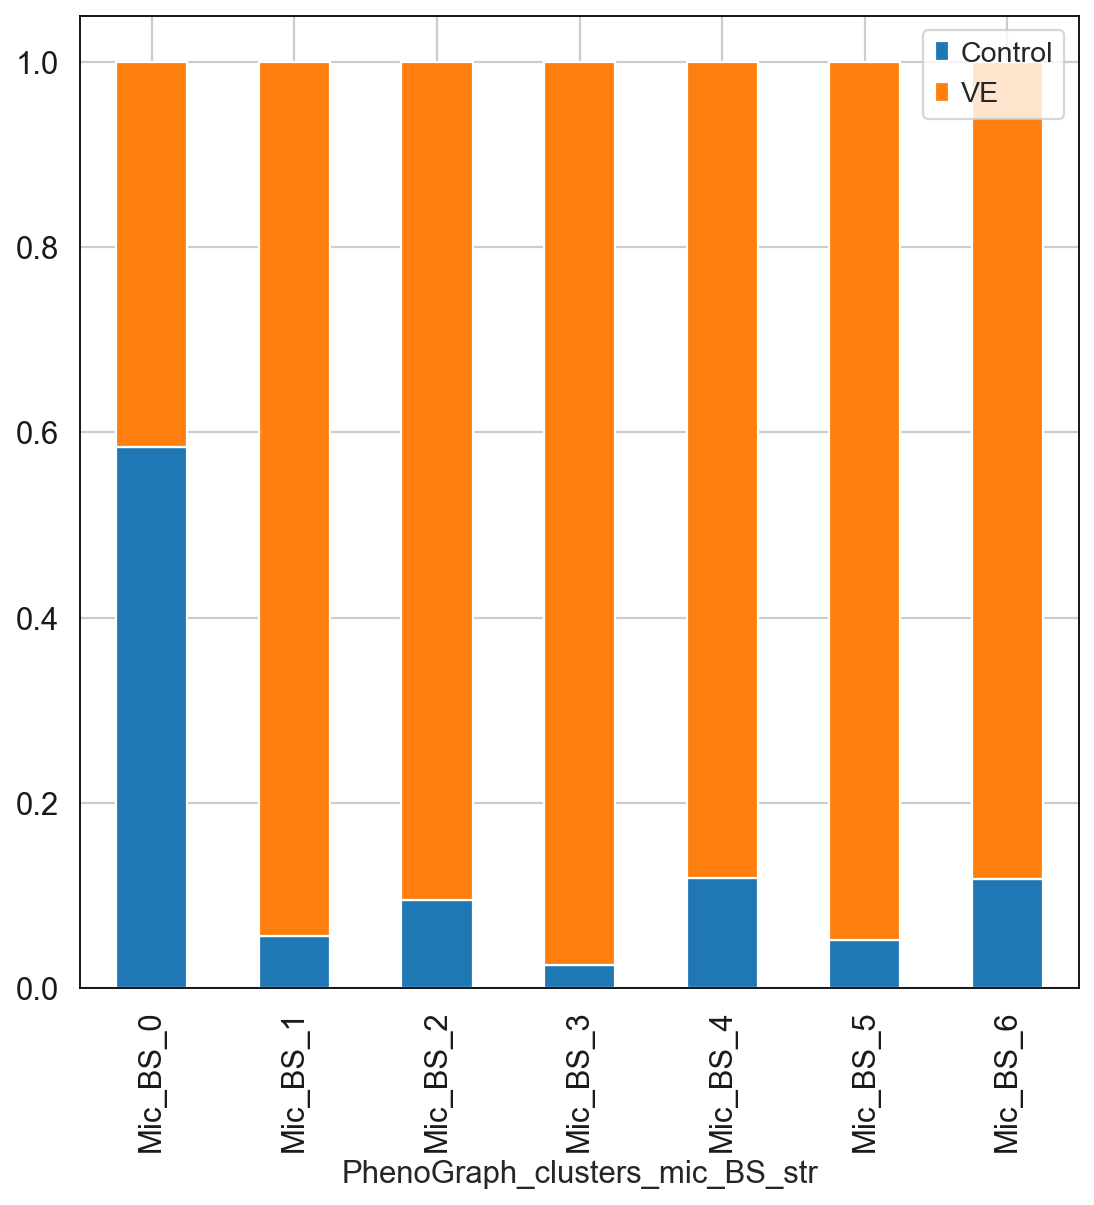

In [415]:
tmp = pd.crosstab(adata_microglia_BS.obs['PhenoGraph_clusters_mic_BS_str'],adata_microglia_BS.obs['Condition'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='upper right')

# Save result Adata BS Microlgia

In [55]:
#adata_microglia_BS.write_h5ad(outdir+'adata_high_var_Microglia_Brainstem_clusters.h5ad')

Load the adata object that holds the latest cell type annotations..

In [484]:
adata_microglia_BS = sc.read_h5ad(outdir+'adata_high_var_Microglia_Brainstem_clusters.h5ad')

# Differential expression with MAST (BS ALL samples)

Oligodendrocytes Brainstem clusters only

In [57]:
run_MAST_for_celltype_condition(adata_microglia_BS, "Microglia")

Microglia	Dimensions	(462, 8756)
Files written for Microglia
Running ./runMAST_condition.R ../DEA/Microglia/adata_Microglia_exp_mat.csv ../DEA/Microglia/adata_Microglia_cdata.csv ../DEA/Microglia/MAST_DEA_Microglia_RESULTS.csv


'Finished running MAST on( Microglia) in 111.09072896700002 seconds.'

In [485]:
# import the MAST results
mast_microglia_BS = pd.read_csv (filepath_or_buffer= '../DEA/Microglia_Brainstem/MAST_DEA_Microglia_RESULTS.csv')
print(mast_microglia_BS)

         gene             p     p.fdr.adj     logFC
0       CSMD3  2.928456e-29  2.564156e-25 -2.220850
1        APOE  1.851499e-19  8.105863e-16  3.127513
2        NAV2  2.877137e-18  8.397403e-15 -1.474793
3      PLXDC2  3.248338e-15  7.110612e-12 -1.023563
4         SON  3.869203e-11  6.775749e-08 -1.463922
...       ...           ...           ...       ...
8751      SYP  9.987850e-01  9.998833e-01 -0.000100
8752    WDR44  9.994882e-01  9.998833e-01  0.005238
8753    LRFN2  9.997534e-01  9.999195e-01 -0.002146
8754  N4BP2L1  9.998053e-01  9.999195e-01  0.000953
8755  SUPV3L1  1.000000e+00  1.000000e+00  0.000798

[8756 rows x 4 columns]


In [486]:
 mast_microglia_BS[mast_microglia_BS['p.fdr.adj'] <= 0.05]

gene             p     p.fdr.adj     logFC
0     CSMD3  2.928456e-29  2.564156e-25 -2.220850
1      APOE  1.851499e-19  8.105863e-16  3.127513
2      NAV2  2.877137e-18  8.397403e-15 -1.474793
3    PLXDC2  3.248338e-15  7.110612e-12 -1.023563
4       SON  3.869203e-11  6.775749e-08 -1.463922
..      ...           ...           ...       ...
87  RPS6KA3  4.723001e-04  4.699386e-02  0.542242
88   LGALS3  4.836683e-04  4.758426e-02       NaN
89    CDH23  4.899821e-04  4.766981e-02 -0.828428
90    ERO1L  5.066484e-04  4.874960e-02       NaN
91  GM44511  5.236762e-04  4.984031e-02 -0.759681

[92 rows x 4 columns]

In [490]:
#filter DE results
mast_microglia_BS = mast_microglia_BS.sort_values(by='logFC', ascending=False)
mast_microglia_BS_sig = mast_microglia_BS[mast_microglia_BS['p.fdr.adj'] <= 0.05]
# Upregulated genes
mast_microglia_BS_UP = mast_microglia_BS[(mast_microglia_BS['logFC'] >=0.5) & (mast_microglia_BS['p.fdr.adj'] <= 0.05)]
mast_microglia_BS_DOWN = mast_microglia_BS[(mast_microglia_BS['logFC'] <=-0.5) & (mast_microglia_BS['p.fdr.adj'] <= 0.05)]
#mast_C0_res_UP['gene'].head(20)
mast_microglia_BS_UP.shape

(25, 4)

## Volcano plot

In [492]:
from bioinfokit import analys, visuz

In [493]:
mast_microglia_BS = mast_microglia_BS.dropna()

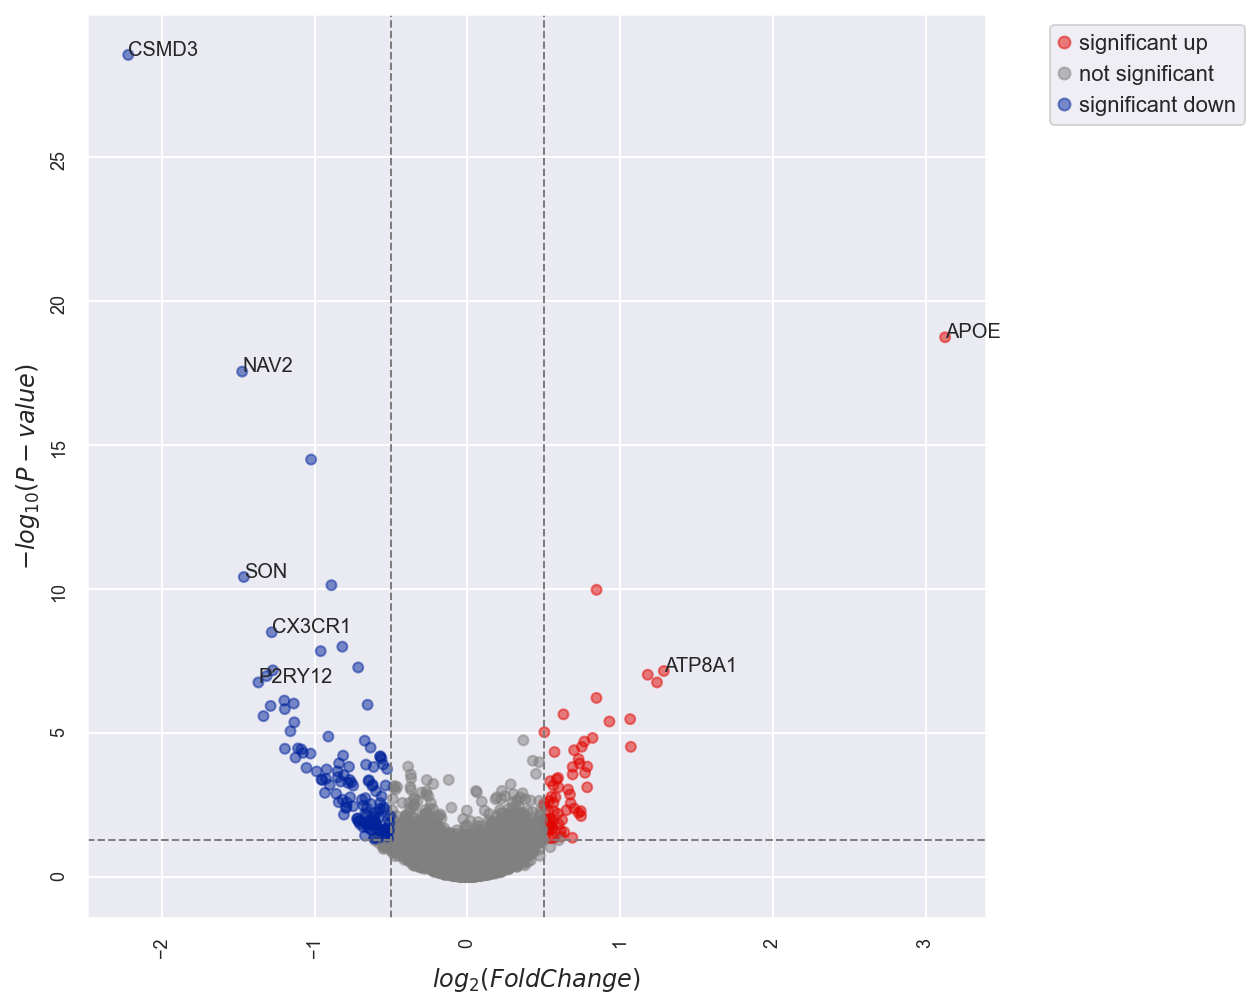

In [494]:
visuz.gene_exp.volcano(df=mast_microglia_BS, lfc='logFC', pv='p',show=True, plotlegend=True, legendpos='upper right', 
    legendanchor=(1.3,1),color=("#E10600FF", "grey", "#00239CFF"), valpha=0.5, dotsize=25, geneid="gene", 
                       genenames=('APOE', 'ATP8A1', 'CSMD3', 'NAV2','SON','CX3CR1','P2RY12'),  sign_line=True, gfont = 10, dim=(8,8), axlabelfontsize = 12, lfc_thr=(0.5, 0.5))

## ALL clusters Enrichr 

In [376]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_microglia_BS_n_list = mast_microglia_BS_sig.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_microglia_BS_n_list,
                     organism='Mouse',
                     gene_sets=['Panther_2016'],
                     description='pathway',
                     cutoff = 0.5)

In [377]:
enr_res.results.head(15)

Gene_set                                               Term Overlap  \
0   Panther_2016  Oxytocin receptor mediated signaling pathway H...    2/39   
1   Panther_2016  Thyrotropin-releasing hormone receptor signali...    2/41   
2   Panther_2016  5HT2 type receptor mediated signaling pathway ...    2/46   
3   Panther_2016  Alzheimer disease-amyloid secretase pathway Ho...    2/56   
4   Panther_2016      Pentose phosphate pathway Homo sapiens P02762     1/8   
5   Panther_2016  Fructose galactose metabolism Homo sapiens P02744    1/10   
6   Panther_2016  Axon guidance mediated by semaphorins Homo sap...    1/17   
7   Panther_2016                     Glycolysis Homo sapiens P00024    1/17   
8   Panther_2016         PDGF signaling pathway Homo sapiens P00047   2/112   
9   Panther_2016  Alpha adrenergic receptor signaling pathway Ho...    1/23   
10  Panther_2016  Histamine H1 receptor mediated signaling pathw...    1/26   
11  Panther_2016  Beta2 adrenergic receptor signaling pathway Ho...    1/28   
12  Panther_2016  Beta1 adrenergic receptor signaling pathway Ho...    1/28   
13  Panther_2016  Insulin/IGF pathway-mitogen activated protein ...    1/29   
14  Panther_2016  Angiotensin II-stimulated signaling through G ...    1/34   

     P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0   0.013887          0.208990            0                     0   11.934535   
1   0.015277          0.208990            0                     0   11.321368   
2   0.018999          0.208990            0                     0   10.032323   
3   0.027446          0.226431            0                     0    8.170370   
4   0.036219          0.239045            0                     0   31.241758   
5   0.045069          0.247880            0                     0   24.296703   
6   0.075416          0.295199            0                     0   13.662088   
7   0.075416          0.295199            0                     0   13.662088   
8   0.094078          0.295199            0                     0    3.999596   
9   0.100667          0.295199            0                     0    9.933067   
10  0.113036          0.295199            0                     0    8.739780   
11  0.121188          0.295199            0                     0    8.091575   
12  0.121188          0.295199            0                     0    8.091575   
13  0.125236          0.295199            0                     0    7.802198   
14  0.145202          0.306056            0                     0    6.618382   

    Combined Score          Genes  
0        51.041363   CACNB2;PRKCA  
1        47.339240   CACNB2;PRKCA  
2        39.761758   CACNB2;PRKCA  
3        29.376783   CACNB2;PRKCA  
4       103.665534            HK2  
5        75.309055            HK2  
6        35.312859           NRP1  
7        35.312859            HK2  
8         9.453578  RPS6KA3;PRKCA  
9        22.805669          PRKCA  
10       19.053161          PRKCA  
11       17.076565         CACNB2  
12       17.076565         CACNB2  
13       16.209491        RPS6KA3  
14       12.771021          PRKCA

In [368]:
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2018',top_term=15,color='green',figsize=(6,6))

'Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05'

## Heatmaps of gene expression of top DEA genes

### All Brainstem samples

In [92]:
marker_genes_dict = dict()

marker_genes_dict = {'Mic-BS': mast_microglia_BS_UP['gene'].head(20)}

marker_genes_dict = marker_genes_dict['Mic-BS'].drop(16)
#marker_genes_dict['Mic-BS'][16]

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


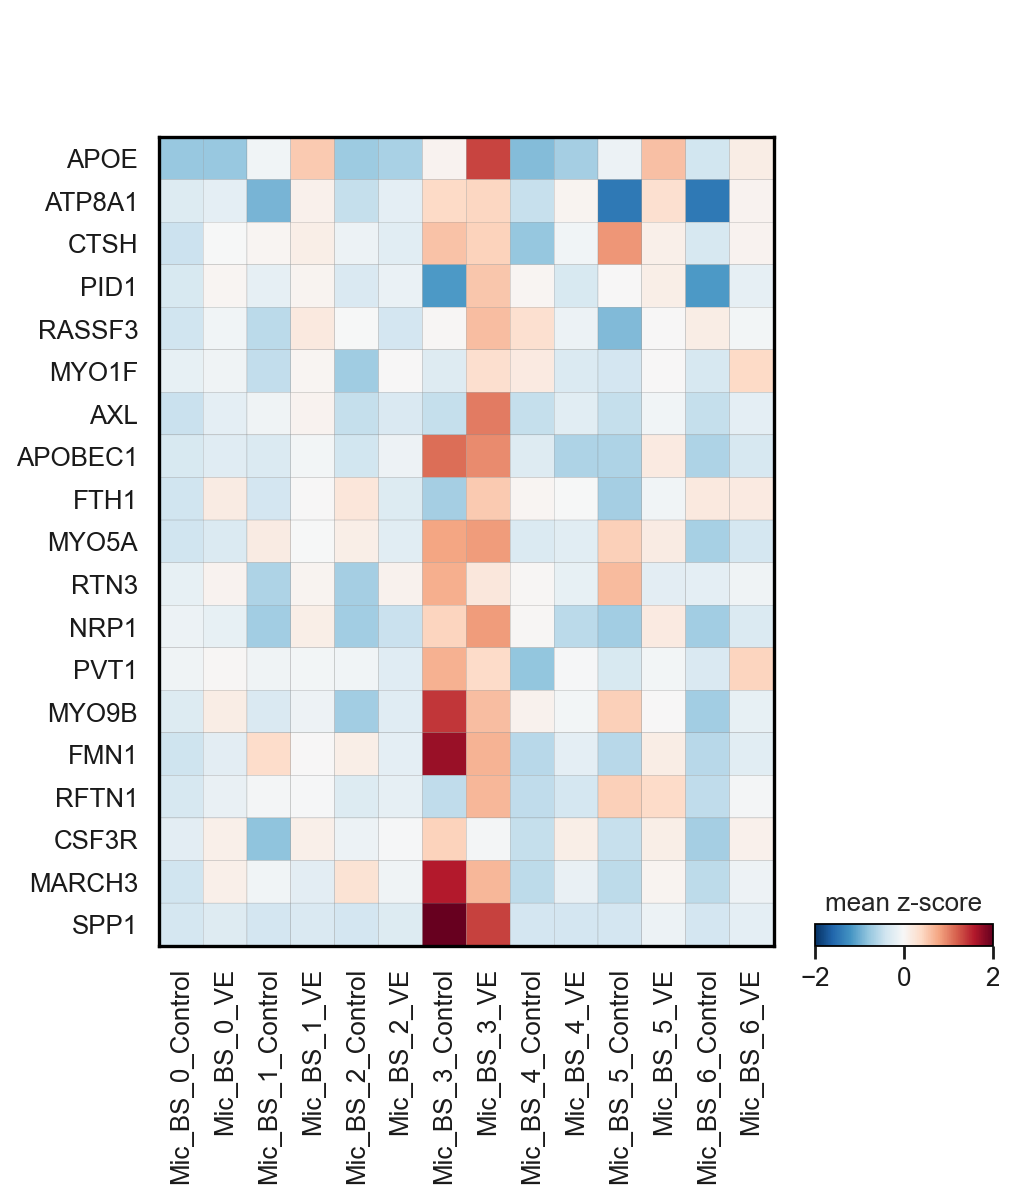

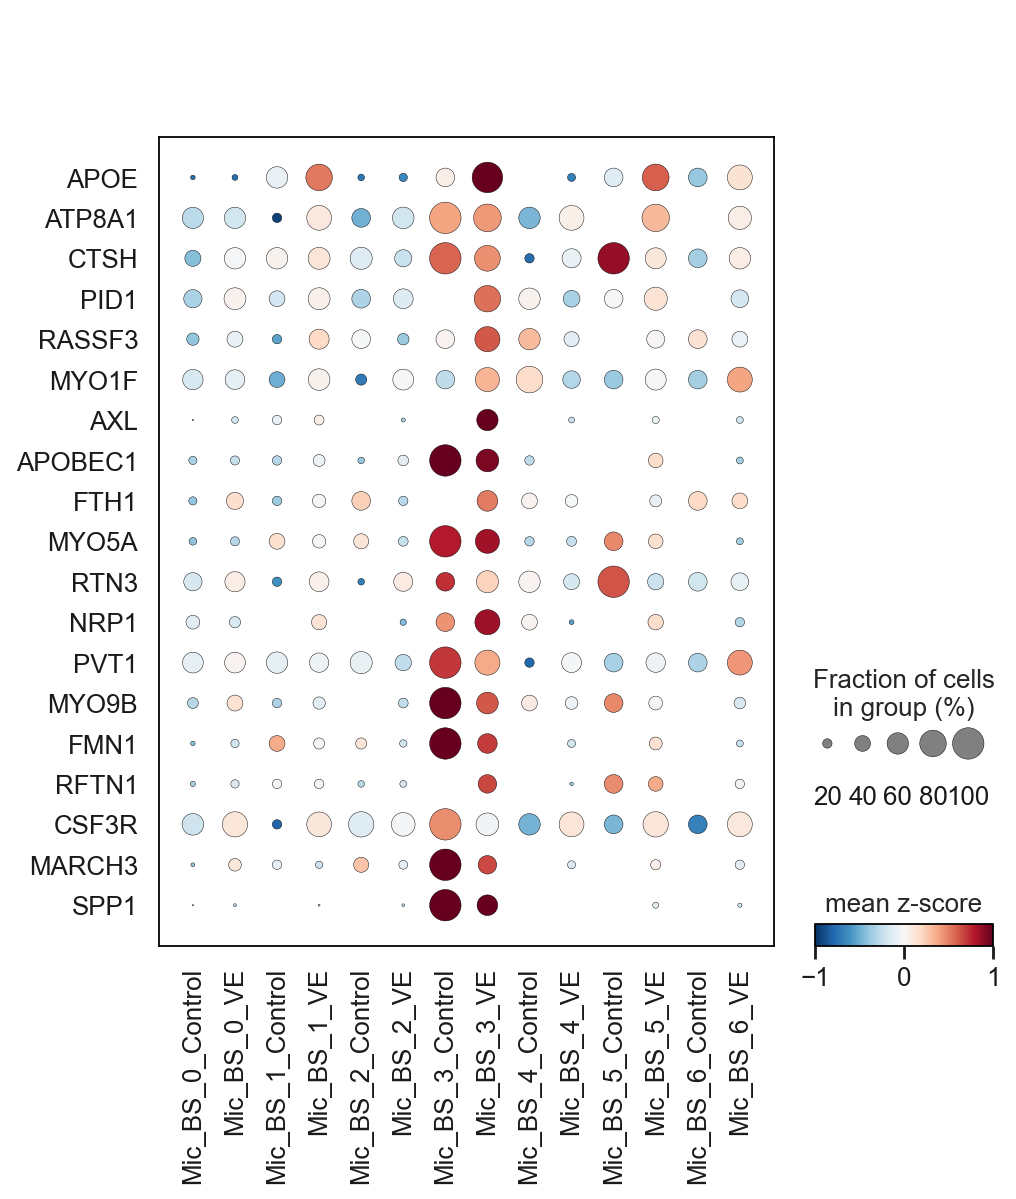

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


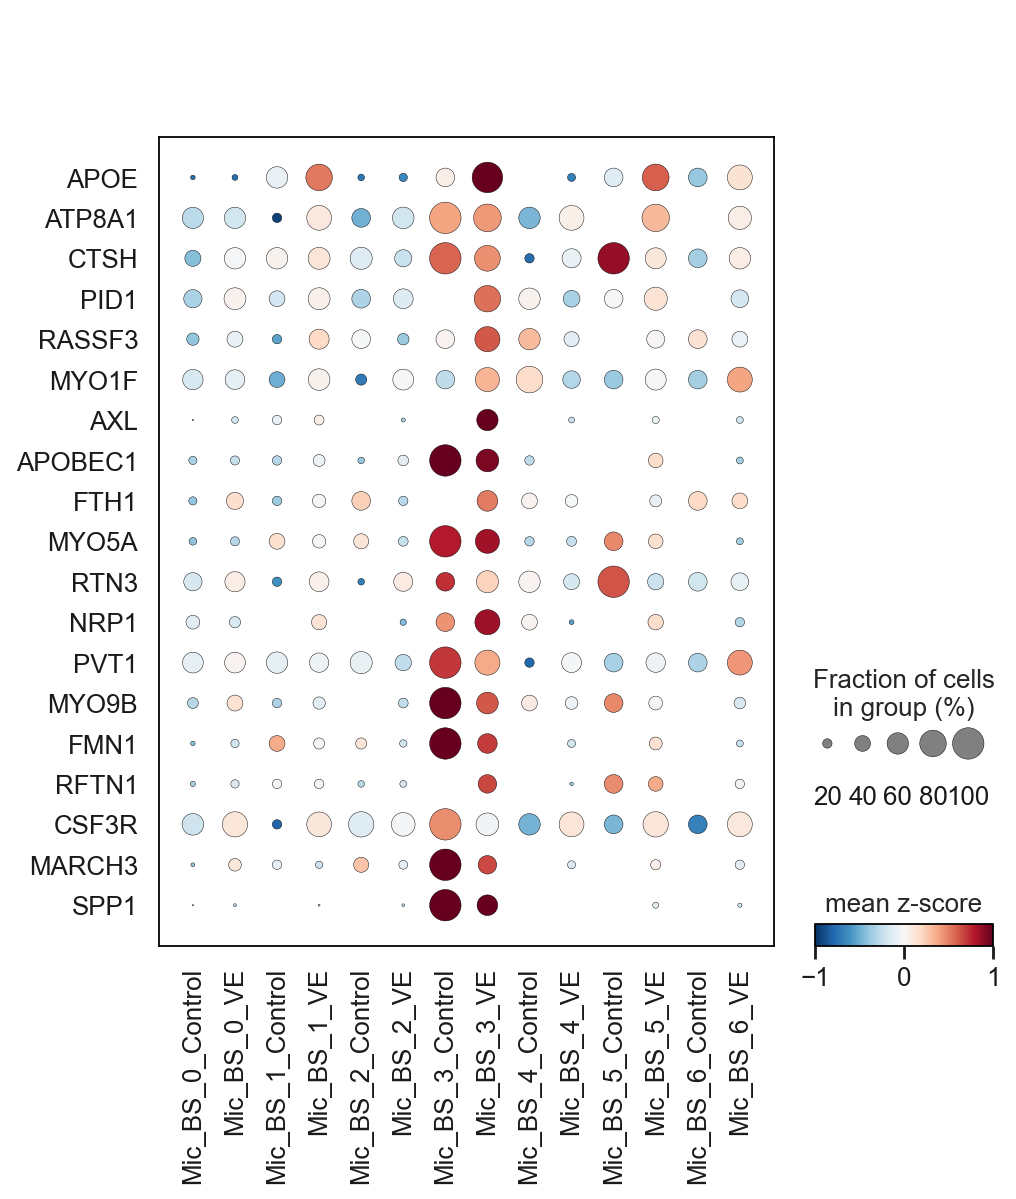

In [94]:
adata_microglia_BS.layers['scaled'] = sc.pp.scale(adata_microglia_BS, copy=True).X
sc.pl.matrixplot(adata_microglia_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_BS_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_microglia_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_microglia_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

# Microglia BS control 

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


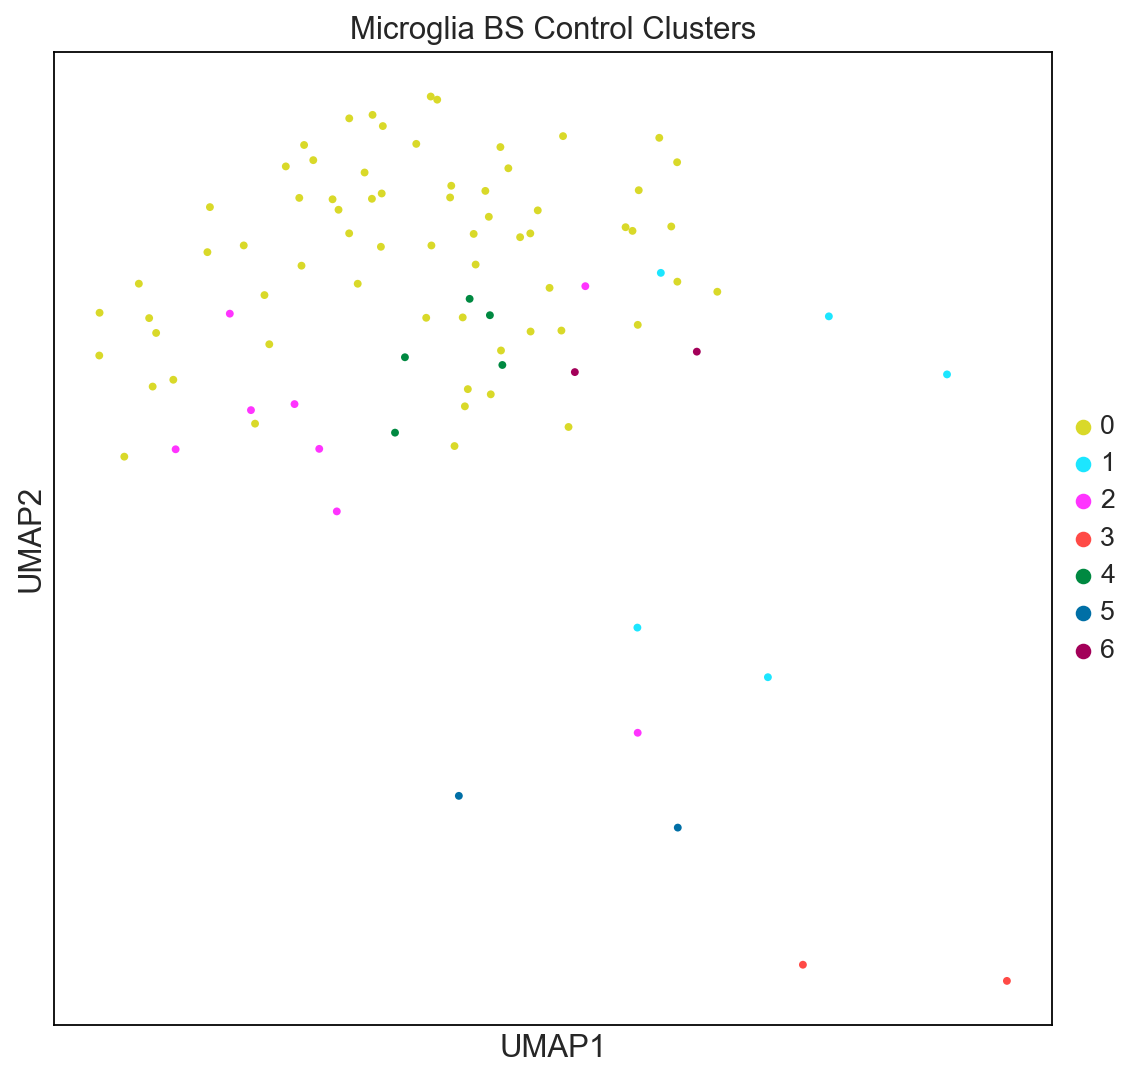

In [101]:
adata_microglia_BS_Control = adata_microglia_BS[adata_microglia_BS.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_microglia_BS_Control, 
           color= ['PhenoGraph_clusters_mic_BS'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Microglia BS Control Clusters"])

In [98]:
cell_counts_per_cluster_BS_ctrl = adata_microglia_BS_Control.obs.PhenoGraph_clusters_mic_BS.value_counts()
cell_counts_per_cluster_BS_ctrl = cell_counts_per_cluster_BS_ctrl.to_frame()
cell_counts_per_cluster_BS_ctrl

PhenoGraph_clusters_mic_BS
0                          66
2                           8
1                           5
4                           5
3                           2
5                           2
6                           2

# Microglia BS VE

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


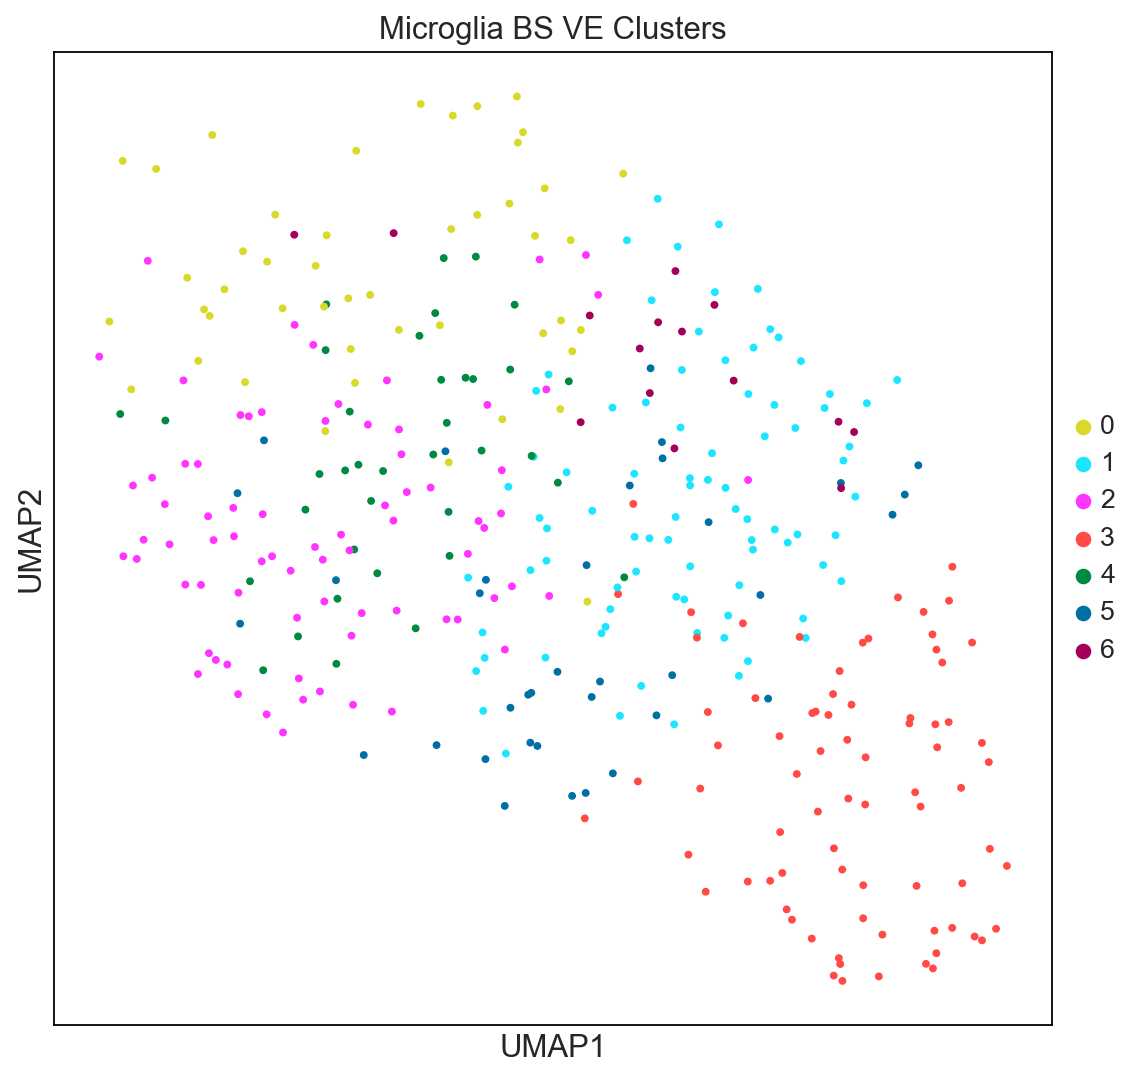

In [99]:
adata_microglia_BS_VE = adata_microglia_BS[adata_microglia_BS.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_microglia_BS_VE, 
           color= ['PhenoGraph_clusters_mic_BS'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Microglia BS VE Clusters"])

In [100]:
cell_counts_per_cluster_BS_VE = adata_microglia_BS_VE.obs.PhenoGraph_clusters_mic_BS.value_counts()
cell_counts_per_cluster_BS_VE = cell_counts_per_cluster_BS_VE.to_frame()
cell_counts_per_cluster_BS_VE

PhenoGraph_clusters_mic_BS
1                          84
3                          77
2                          76
0                          47
4                          37
5                          36
6                          15

# Make a grouped bar plot of the number of cells per cluster per condition

**Brainstem**

In [102]:
# First merge the 2 data frames by indeces
mergedDF= cell_counts_per_cluster_BS_ctrl.merge(cell_counts_per_cluster_BS_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'),how = 'outer')
mergedDF.rename(columns = {'PhenoGraph_clusters_mic_BS_Control' : 'Control', 'PhenoGraph_clusters_mic_BS_VE' : 'VE'}, inplace = True)
mergedDF

Control  VE
0       66  47
1        5  84
2        8  76
3        2  77
4        5  37
5        2  36
6        2  15

In [103]:
mergedDF = mergedDF.reset_index()
mergedDF = mergedDF.melt(id_vars=["index"])
mergedDF.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF

ClusterID Condition  N_cells
0          0   Control       66
1          1   Control        5
2          2   Control        8
3          3   Control        2
4          4   Control        5
5          5   Control        2
6          6   Control        2
7          0        VE       47
8          1        VE       84
9          2        VE       76
10         3        VE       77
11         4        VE       37
12         5        VE       36
13         6        VE       15

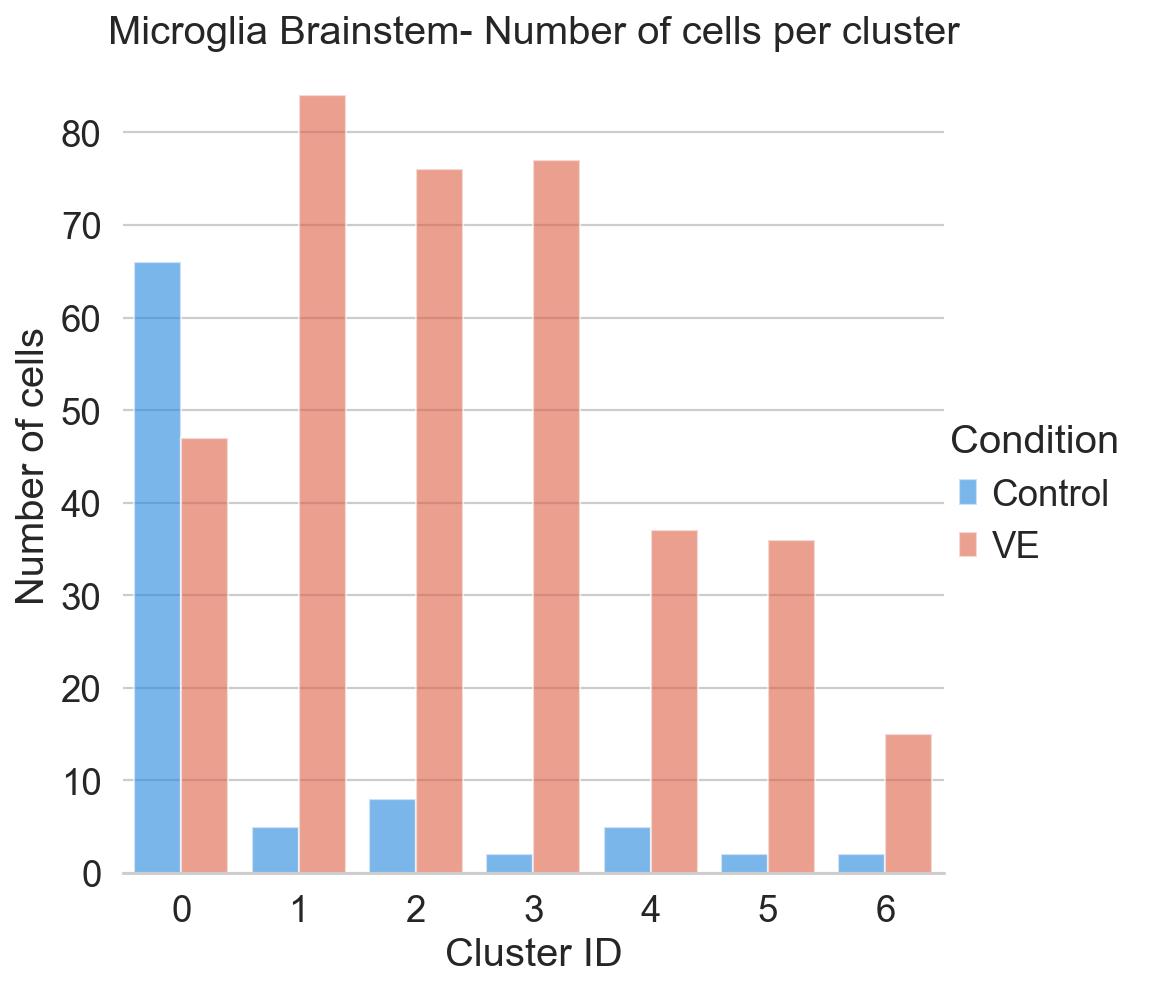

In [104]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='Microglia Brainstem- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")

# Tests markers between specific clusters

## **T-test** Compare Clusters 1+3+5+6 (VE) Versus All Controls

In [393]:
adata_microglia_BS_copy = adata_microglia_BS.copy()
# For loop creating a groups for pairwise comparison
adata_microglia_BS_copy.obs['groups'] = ['group_1_3_5_6VE' if int(i) in [1,3,5,6] and j == 'VE' else 'group_restCTRL' if j == 'Control' else 'Error' for i,j in zip(adata_microglia_BS_copy.obs['PhenoGraph_clusters_mic_BS'],adata_microglia_BS_copy.obs['Condition'] )]


In [394]:
adata_microglia_BS_copy.obs.groups.value_counts()

group_1_3_5_6VE    212
Error              160
group_restCTRL      90
Name: groups, dtype: int64

In [395]:
# select only cells that are in these 2 groups that I want to compare
adata_microglia_BS_to_compare = adata_microglia_BS_copy[[group in ['group_restCTRL', 'group_1_3_5_6VE'] for group in adata_microglia_BS_copy.obs['groups']],].copy()
adata_microglia_BS_to_compare.obs.groups.value_counts()

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


group_1_3_5_6VE    212
group_restCTRL      90
Name: groups, dtype: int64

... storing 'groups' as categorical


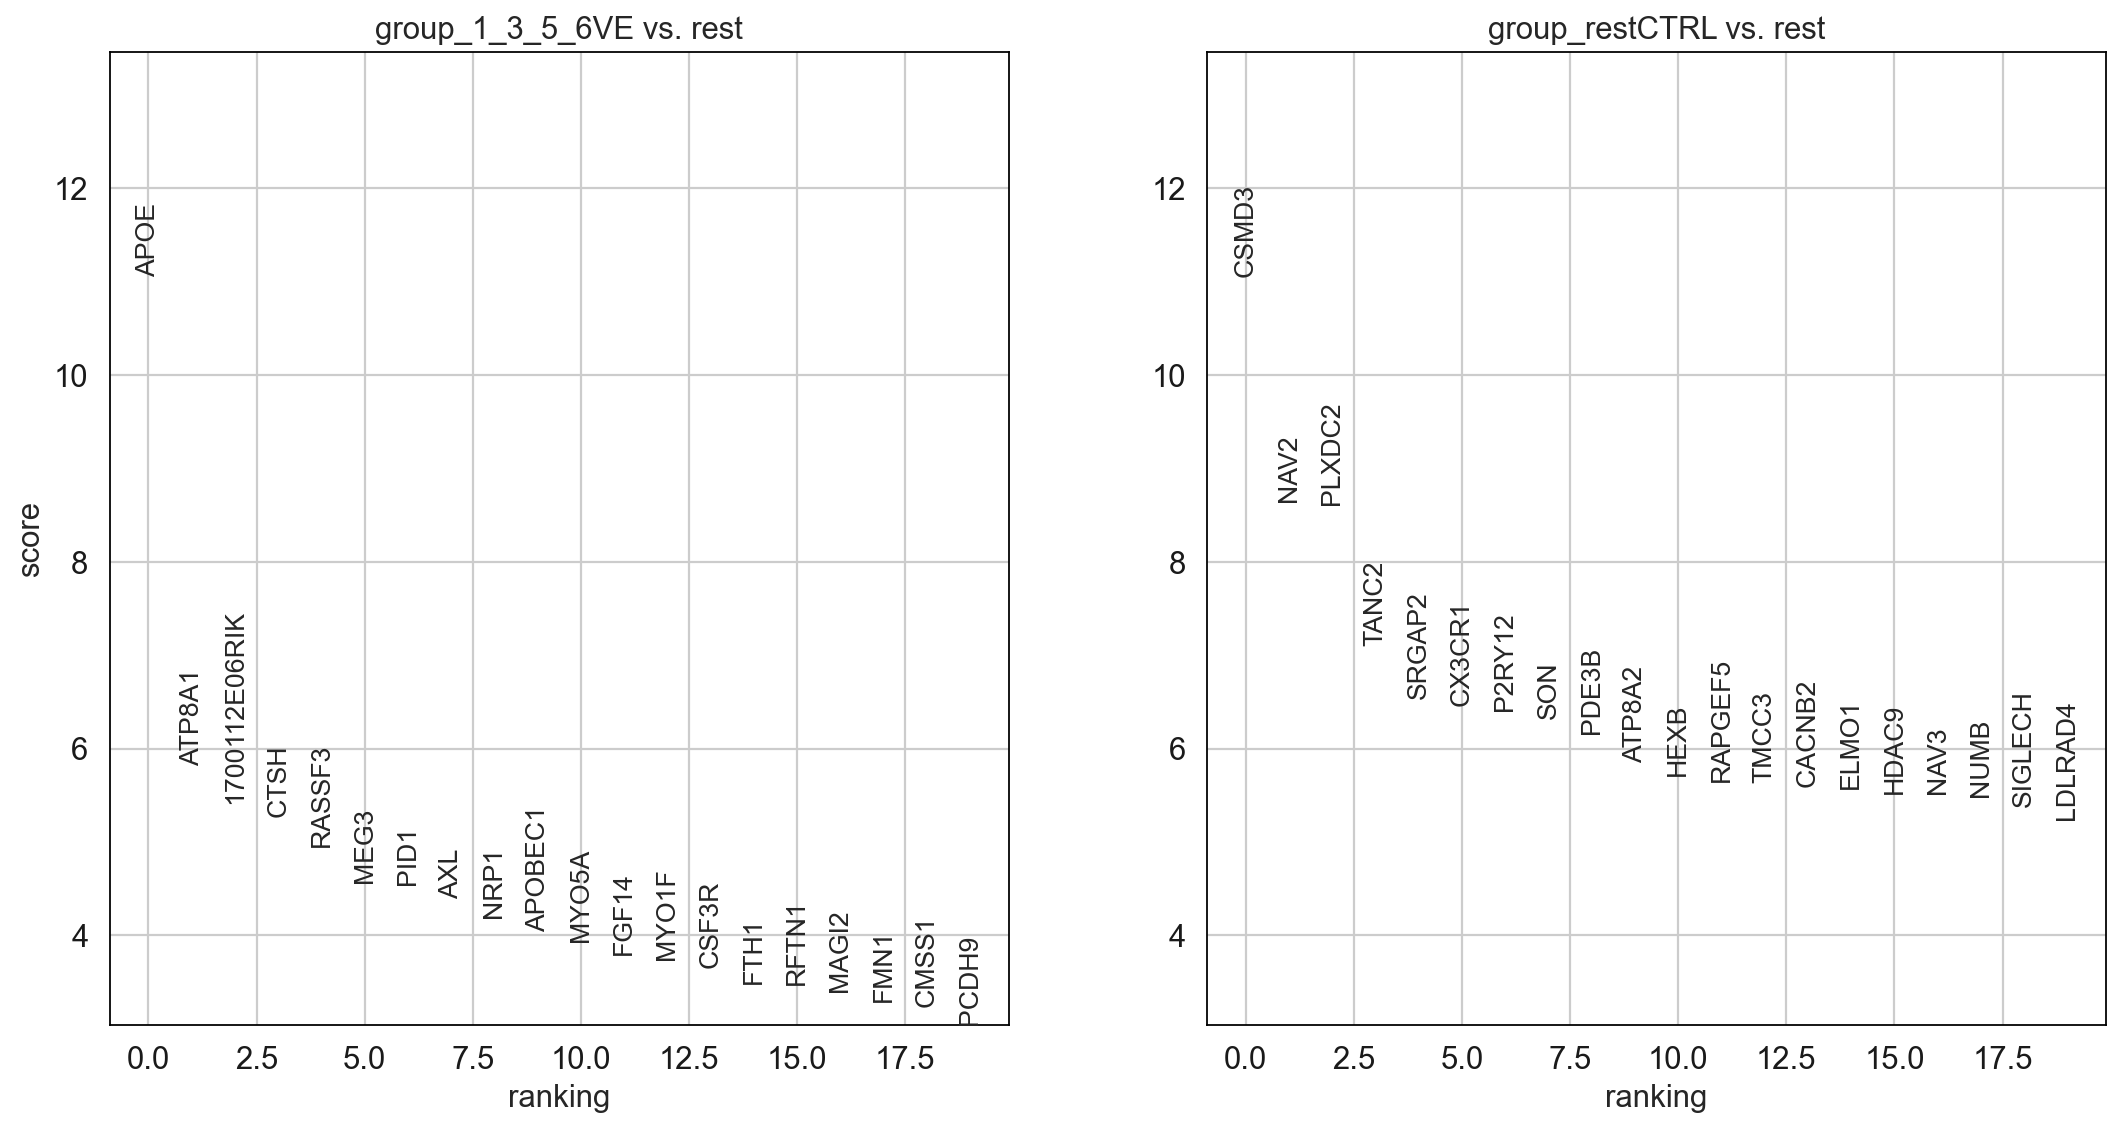

In [186]:
sc.set_figure_params(figsize=(8, 8))
key_ad = 'group_1_3_5_6VE'
n_genes = 100000

sc.tl.rank_genes_groups(adata_microglia_BS_to_compare, groupby='groups', key_added="group_1_3_5_6VE", method='wilcoxon')
sc.pl.rank_genes_groups(adata_microglia_BS_to_compare, key = 'group_1_3_5_6VE', fontsize=12)

result = adata_microglia_BS_to_compare.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [187]:
pval_table = pval_table.sort_values(by= 'group_1_3_5_6VE_l', ascending=False)
pval_table[(pval_table.group_1_3_5_6VE_p < 0.05) & (pval_table.group_1_3_5_6VE_l > 0.5)]

group_1_3_5_6VE_n  group_1_3_5_6VE_l  group_1_3_5_6VE_p group_restCTRL_n  \
0               APOE           8.244028       9.794306e-25            CSMD3   
7                AXL           5.267541       2.348788e-03              SON   
9            APOBEC1           2.568728       9.648680e-03           ATP8A2   
10             MYO5A           2.249311       1.447948e-02             HEXB   
4             RASSF3           2.212473       2.278827e-04           SRGAP2   
8               NRP1           2.056049       5.195113e-03            PDE3B   
1             ATP8A1           2.026257       4.280679e-06             NAV2   
3               CTSH           1.979704       5.048380e-05            TANC2   
6               PID1           1.918794       1.301537e-03           P2RY12   
2      1700112E06RIK           1.762862       2.671782e-05           PLXDC2   
12             MYO1F           1.253705       2.707426e-02            TMCC3   
11             FGF14           1.239607       2.210809e-02          RAPGEF5   
13             CSF3R           0.971749       3.546791e-02           CACNB2   
5               MEG3           0.827107       1.215304e-03           CX3CR1   

    group_restCTRL_l  group_restCTRL_p  
0           4.131451      9.794306e-25  
7           2.201360      2.573109e-07  
9           2.233092      3.980066e-06  
10          1.151160      7.660513e-06  
4           1.414603      9.410571e-08  
8           2.216146      6.524021e-07  
1           2.507312      1.553157e-14  
3           1.738023      2.209601e-09  
6           2.768528      1.625531e-07  
2           1.989997      1.553157e-14  
12          1.426451      1.028163e-05  
11          2.162514      1.028163e-05  
13          2.673844      1.202051e-05  
5           2.480386      1.320496e-07

### MAST 

In [188]:
cell_type = 'Microlgia_Brainstem_C1_3_5_6'
expmat = pd.DataFrame(adata_microglia_BS_to_compare.X, columns = adata_microglia_BS_to_compare.var.index, index = adata_microglia_BS_to_compare.obs.index)
cdata = pd.DataFrame(adata_microglia_BS_to_compare.obs, columns=adata_microglia_BS_to_compare.obs.columns, index = adata_microglia_BS_to_compare.obs.index)
expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [191]:
start_time = timeit.default_timer()
MAST = './runMAST_clusters.R'
expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " )
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

In [495]:
# import the MAST results
mast_C1_3_5_6_res = pd.read_csv (filepath_or_buffer= '../DEA/Microlgia_Brainstem_C1_3_5_6/MAST_DEA_Microlgia_Brainstem_C1_3_5_6_RESULTS.csv')
print(mast_C1_3_5_6_res)

        gene             p     p.fdr.adj     logFC
0       APOE  1.370793e-36  1.200267e-32  4.999552
1      CSMD3  1.136223e-33  4.974386e-30 -2.813917
2       NAV2  1.111814e-19  3.245014e-16 -1.751503
3     PLXDC2  1.033516e-15  2.262367e-12 -1.231556
4        AXL  8.775818e-13  1.536821e-09  1.253180
...      ...           ...           ...       ...
8751    ZXDC  5.255190e-01  9.998113e-01 -0.089216
8752  ZYG11B  7.650662e-01  9.998113e-01 -0.047863
8753     ZYX  8.537423e-01  9.998113e-01 -0.033964
8754    ZZZ3  8.893692e-01  9.998113e-01 -0.083634
8755   KIF2A  9.999006e-01  9.999006e-01  0.001422

[8756 rows x 4 columns]


In [500]:
#filter DE results
mast_C1_3_5_6_res = mast_C1_3_5_6_res.sort_values(by='logFC', ascending=False)
mast_C1_3_5_6_res_sig = mast_C1_3_5_6_res[mast_C1_3_5_6_res['p.fdr.adj'] <= 0.05]
# Upregulated genes
mast_C1_3_5_6_res_UP = mast_C1_3_5_6_res[(mast_C1_3_5_6_res['logFC'] >=0.5) & (mast_C1_3_5_6_res['p.fdr.adj'] <= 0.05)]
mast_C1_3_5_6_res_DOWN = mast_C1_3_5_6_res[(mast_C1_3_5_6_res['logFC'] <=-0.5) & (mast_C1_3_5_6_res['p.fdr.adj'] <= 0.05)]
mast_C1_3_5_6_res_UP.shape

(38, 4)

In [198]:
mast_C1_3_5_6_res_UP.to_csv(path_or_buf='/Users/fragkogs/Desktop/mast_C1_3_5_6_res_UP.csv', index=False)

### Volcano plot

In [503]:
mast_C1_3_5_6_res = mast_C1_3_5_6_res.dropna()

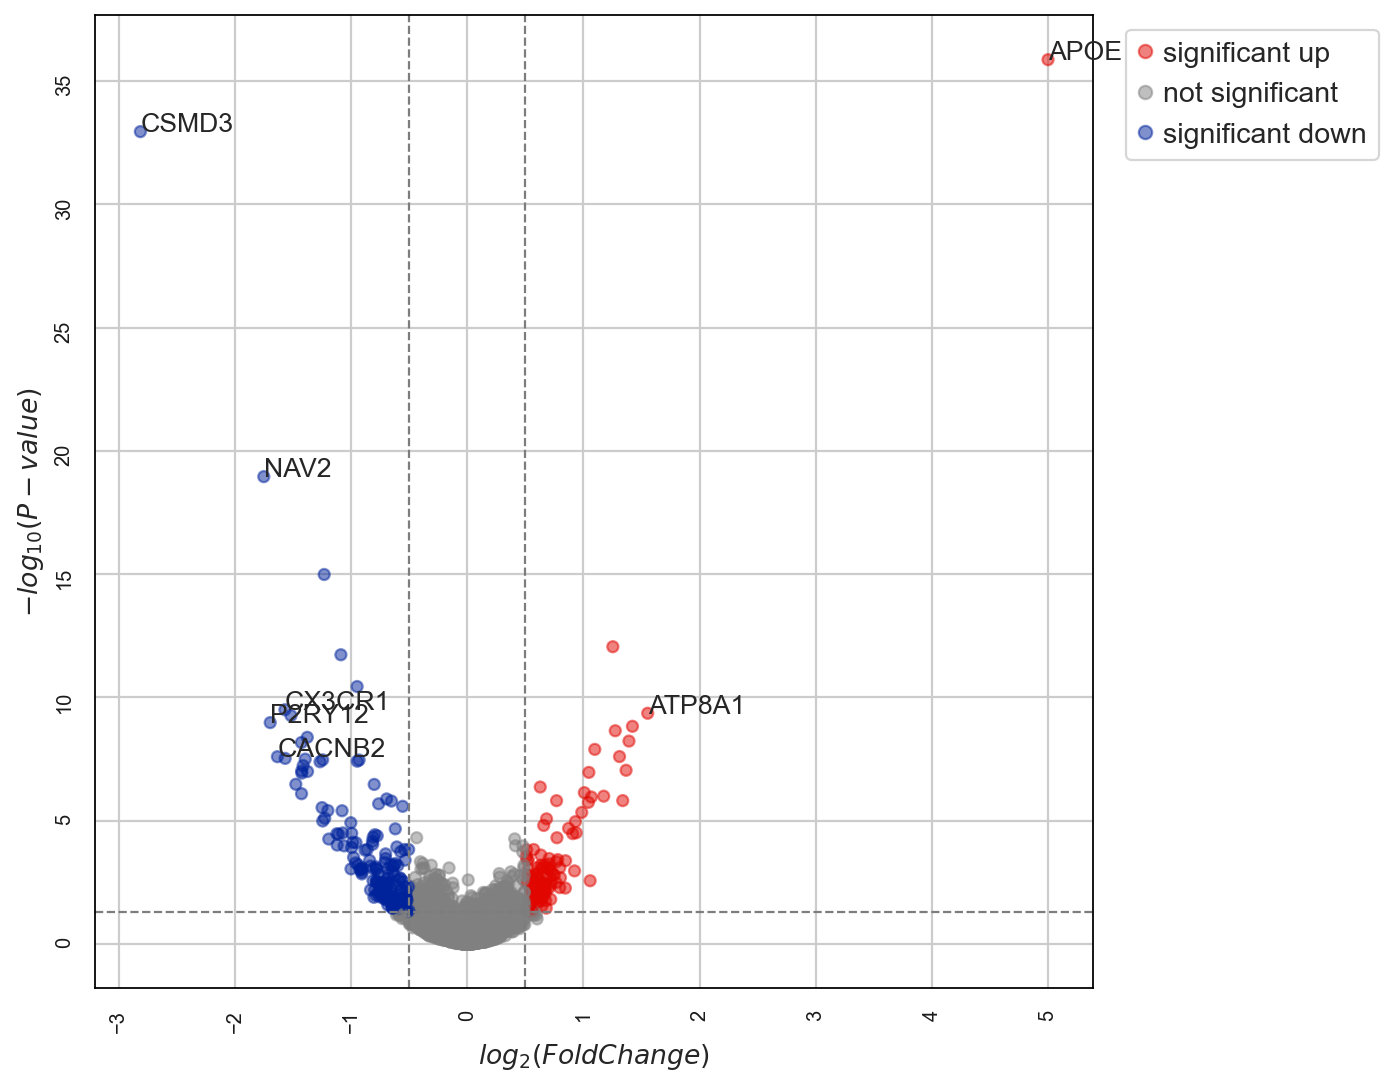

In [504]:
sc.set_figure_params(figsize=(6, 4))
visuz.gene_exp.volcano(df=mast_C1_3_5_6_res, lfc='logFC', pv='p',show=True, plotlegend=True, legendpos='upper right', 
    legendanchor=(1.3,1),color=("#E10600FF", "grey", "#00239CFF"), valpha=0.5, dotsize=25, geneid="gene", 
                       genenames=('APOE', 'ATP8A1', 'CSMD3', 'NAV2','CX3CR1','P2RY12','CACNB2'),  sign_line=True, gfont = 12, dim=(8,8), axlabelfontsize = 12, lfc_thr=(0.5, 0.5))

### HEATMAP OF TOP10 UPREGULATED GENES

In [194]:
marker_genes_dict = dict()

marker_genes_dict = {'C1_3_5_6_UP': mast_C1_3_5_6_res_UP['gene'].head(20)}

marker_genes_dict = marker_genes_dict['C1_3_5_6_UP'].drop(11)

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


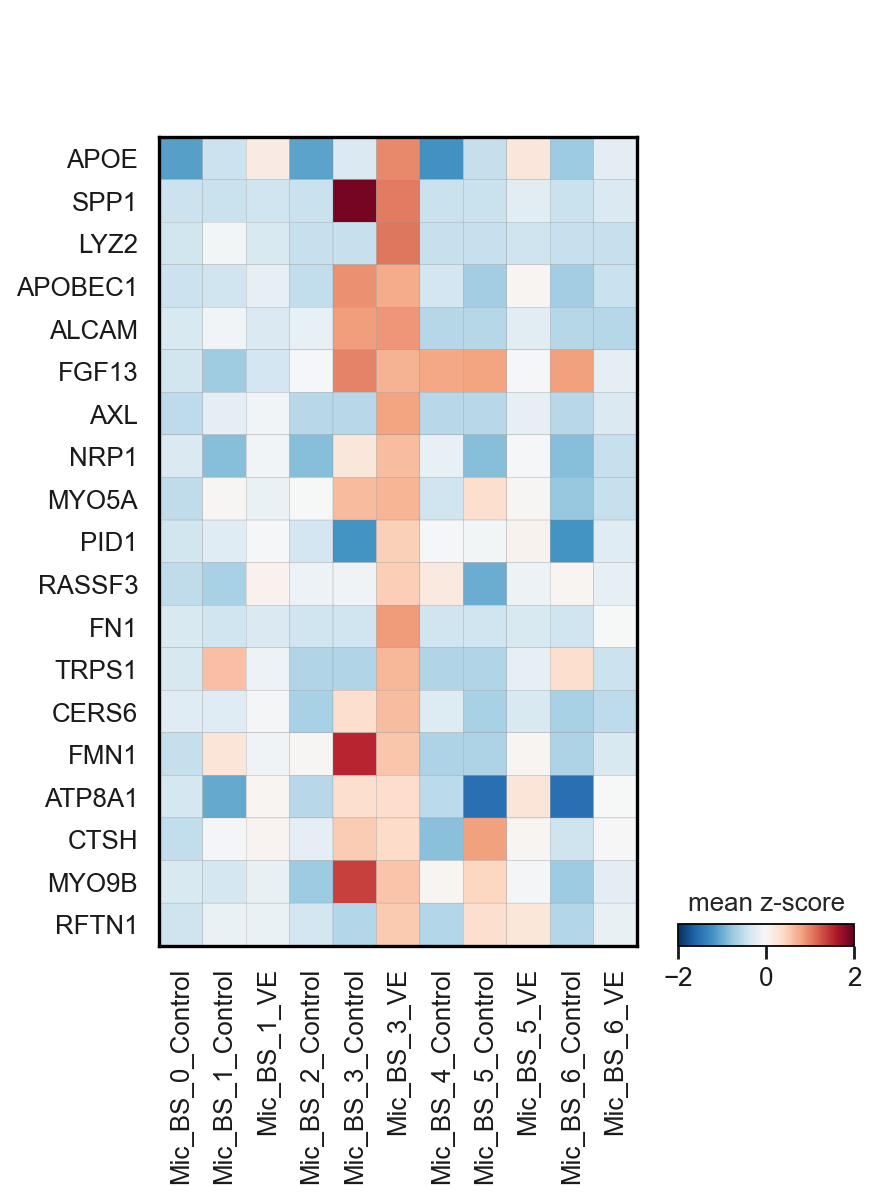

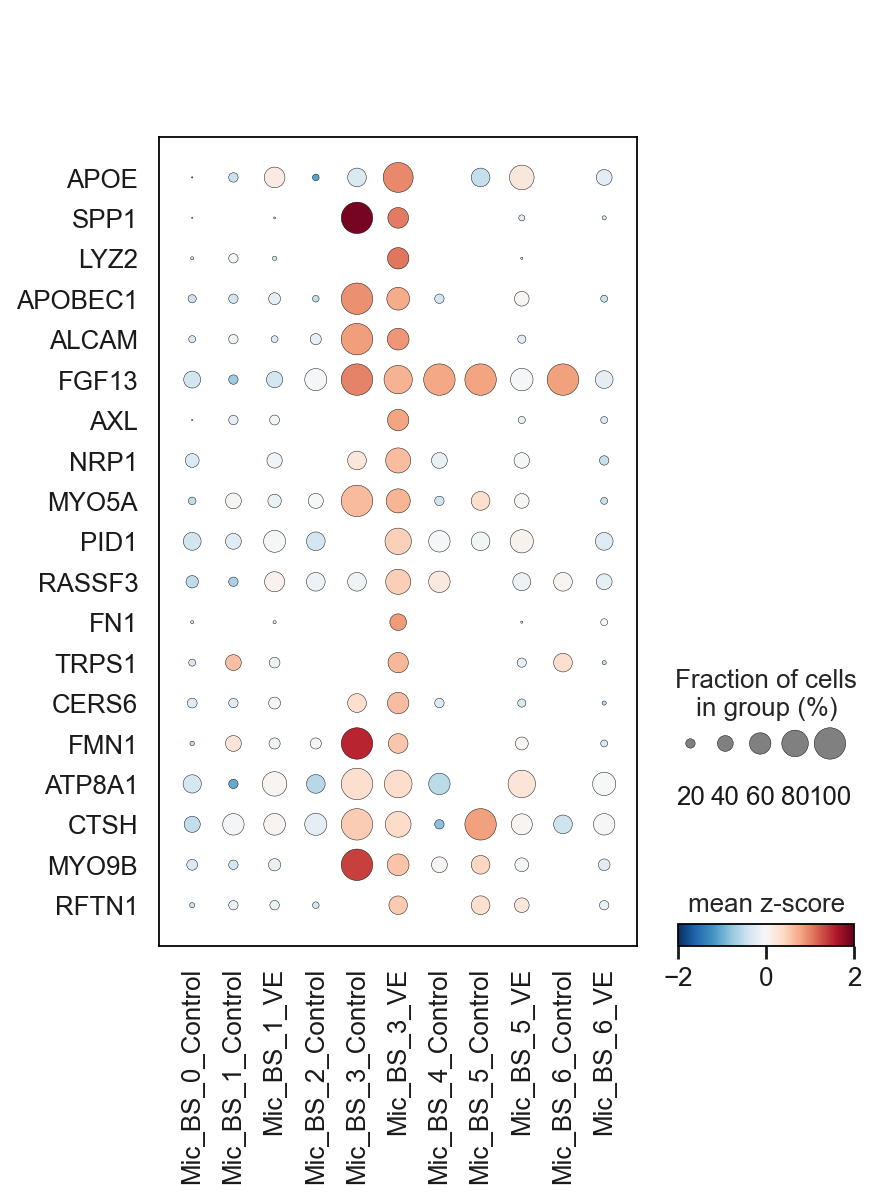

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


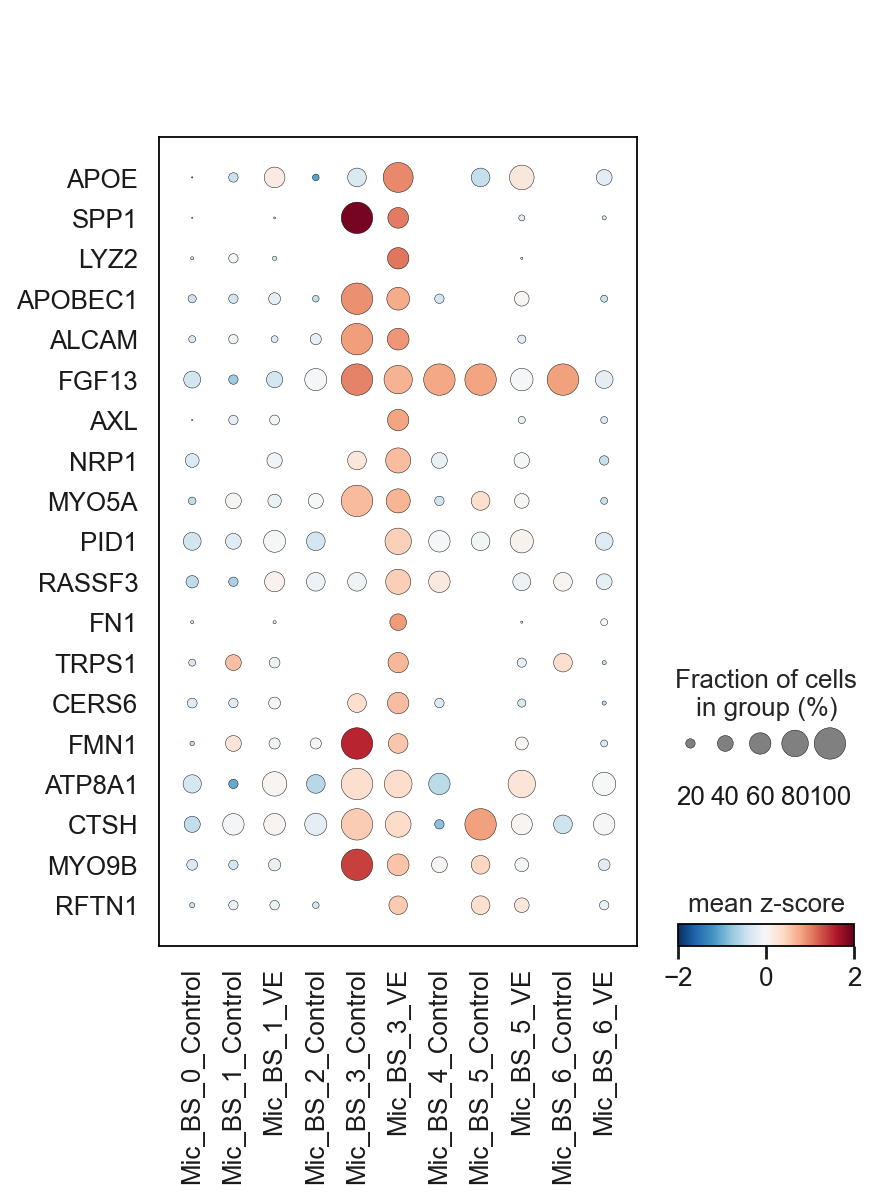

In [401]:
sc.set_figure_params(figsize=(8, 8))
adata_microglia_BS_to_compare.layers['scaled'] = sc.pp.scale(adata_microglia_BS_to_compare, copy=True).X
sc.pl.matrixplot(adata_microglia_BS_to_compare, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_BS_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_microglia_BS_to_compare, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_microglia_BS_to_compare, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

### Enricher

In [380]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_C1_3_5_6_res_n_list = mast_C1_3_5_6_res_UP.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_C1_3_5_6_res_n_list,
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2018'],
                     description='pathway',
                     cutoff = 0.5)

In [381]:
enr_res.results.head(20)

Gene_set  \
0   GO_Biological_Process_2018   
1   GO_Biological_Process_2018   
2   GO_Biological_Process_2018   
3   GO_Biological_Process_2018   
4   GO_Biological_Process_2018   
5   GO_Biological_Process_2018   
6   GO_Biological_Process_2018   
7   GO_Biological_Process_2018   
8   GO_Biological_Process_2018   
9   GO_Biological_Process_2018   
10  GO_Biological_Process_2018   
11  GO_Biological_Process_2018   
12  GO_Biological_Process_2018   
13  GO_Biological_Process_2018   
14  GO_Biological_Process_2018   
15  GO_Biological_Process_2018   
16  GO_Biological_Process_2018   
17  GO_Biological_Process_2018   
18  GO_Biological_Process_2018   
19  GO_Biological_Process_2018   

                                                 Term Overlap   P-value  \
0   vascular endothelial growth factor receptor si...    4/70  0.000015   
1   negative regulation of endothelial cell prolif...    3/30  0.000036   
2    retinal ganglion cell axon guidance (GO:0031290)     2/6  0.000067   
3   positive regulation of lipid transport (GO:003...     2/7  0.000094   
4   regulation of Cdc42 protein signal transductio...     2/7  0.000094   
5   neuron projection extension involved in neuron...     2/8  0.000125   
6   axon extension involved in axon guidance (GO:0...     2/8  0.000125   
7   toll-like receptor 3 signaling pathway (GO:003...     2/9  0.000161   
8                      response to lipid (GO:0033993)   4/140  0.000230   
9   regulation of Rho protein signal transduction ...    3/57  0.000250   
10  positive regulation of macromolecule metabolic...   5/276  0.000303   
11    positive regulation of endocytosis (GO:0045807)    3/64  0.000352   
12  regulation of endothelial cell proliferation (...    3/79  0.000653   
13  toll-like receptor signaling pathway (GO:0002224)    3/86  0.000837   
14                        axon extension (GO:0048675)    2/20  0.000837   
15  positive regulation of transcription from RNA ...    2/21  0.000924   
16  positive regulation of signal transduction (GO...   4/206  0.000985   
17  positive regulation of cellular metabolic proc...    3/92  0.001017   
18  positive regulation of gene expression (GO:001...   7/771  0.001181   
19  positive regulation of purine nucleotide biosy...    2/24  0.001209   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.010063            0                     0   30.910645   
1           0.011769            0                     0   55.361111   
2           0.011769            0                     0  243.329268   
3           0.011769            0                     0  194.653659   
4           0.011769            0                     0  194.653659   
5           0.011769            0                     0  162.203252   
6           0.011769            0                     0  162.203252   
7           0.013222            0                     0  139.024390   
8           0.016412            0                     0   14.947964   
9           0.016412            0                     0   27.643056   
10          0.018070            0                     0    9.558167   
11          0.019271            0                     0   24.462295   
12          0.033015            0                     0   19.619408   
13          0.036662            0                     0   17.958434   
14          0.036662            0                     0   54.035230   
15          0.037137            0                     0   51.188703   
16          0.037137            0                     0   10.030465   
17          0.037137            0                     0   16.742697   
18          0.039201            0                     0    4.884780   
19          0.039201            0                     0   44.201774   

    Combined Score                                    Genes  
0       342.694601                       NRP1;FLT1;AXL;CYBB  
1       566.315814                            FLT1;APOE;XDH  
2      2337.303968                               NRP1

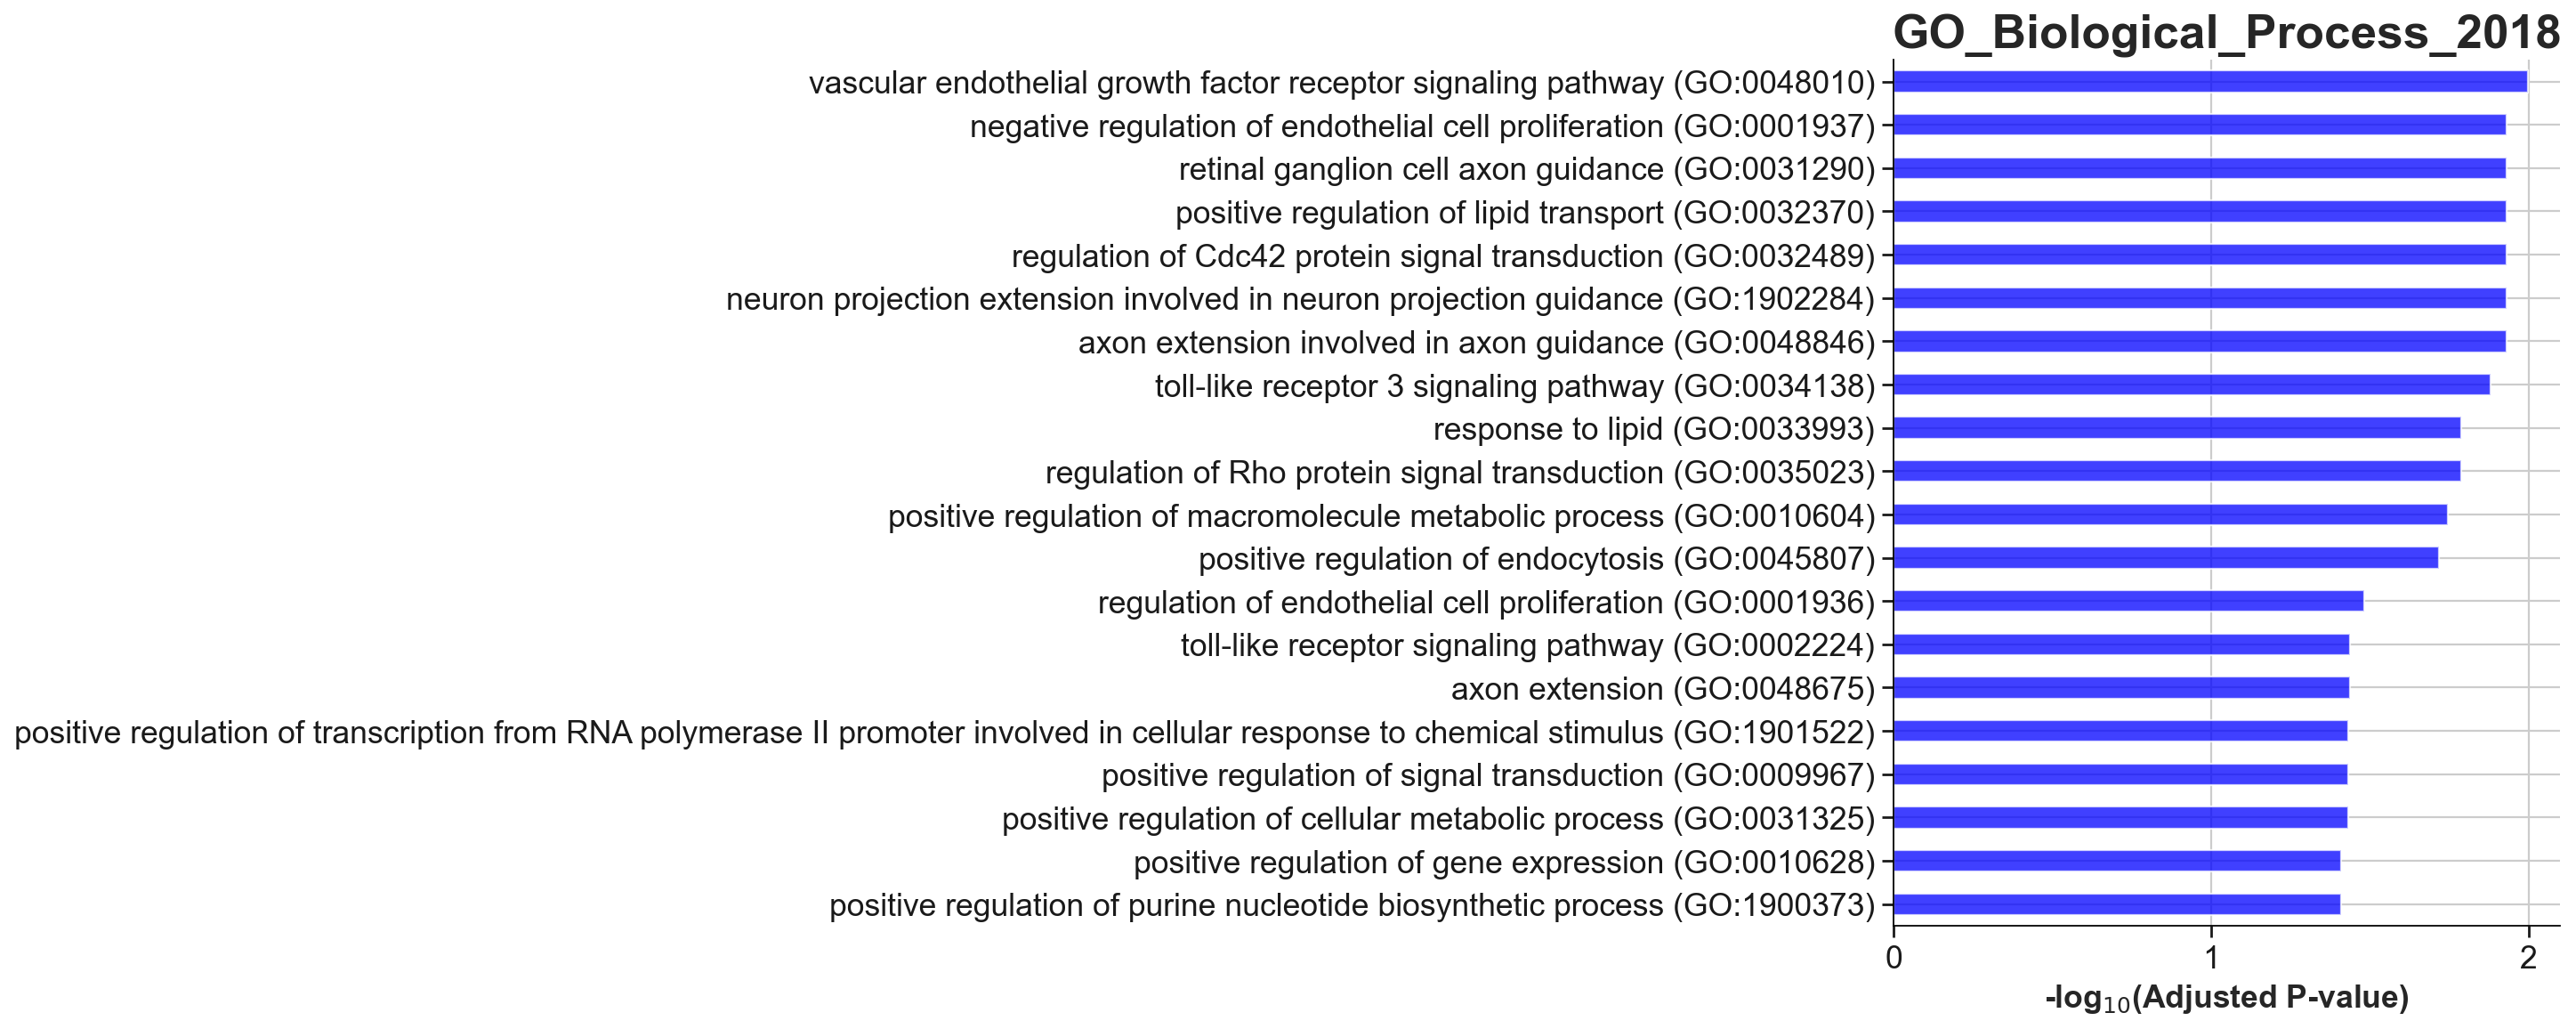

In [352]:
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2018',top_term=20,color='blue',figsize=(6,8))

In [ ]:
#gseapy.dotplot(enr_res.res2d, title='WikiPathways_2019_Mouse',cmap='viridis_r', top_term=20, figsize=(6,8))

## **T-test** Compare Clusters 0+2+4 (VE) Versus All Controls

In [169]:
adata_microglia_BS_copy = adata_microglia_BS.copy()
# For loop creating a groups for pairwise comparison
adata_microglia_BS_copy.obs['groups'] = ['group_0_2_4VE' if int(i) in [0,2,4] and j == 'VE' else 'group_restCTRL' if j == 'Control' else 'Error' for i,j in zip(adata_microglia_BS_copy.obs['PhenoGraph_clusters_mic_BS'],adata_microglia_BS_copy.obs['Condition'] )]


In [170]:
adata_microglia_BS_copy.obs.groups.value_counts()

Error             212
group_0_2_4VE     160
group_restCTRL     90
Name: groups, dtype: int64

In [171]:
# select only cells that are in these 2 groups that I want to compare
adata_microglia_BS_to_compare = adata_microglia_BS_copy[[group in ['group_restCTRL', 'group_0_2_4VE'] for group in adata_microglia_BS_copy.obs['groups']],].copy()
adata_microglia_BS_to_compare.obs.groups.value_counts()

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


group_0_2_4VE     160
group_restCTRL     90
Name: groups, dtype: int64

... storing 'groups' as categorical


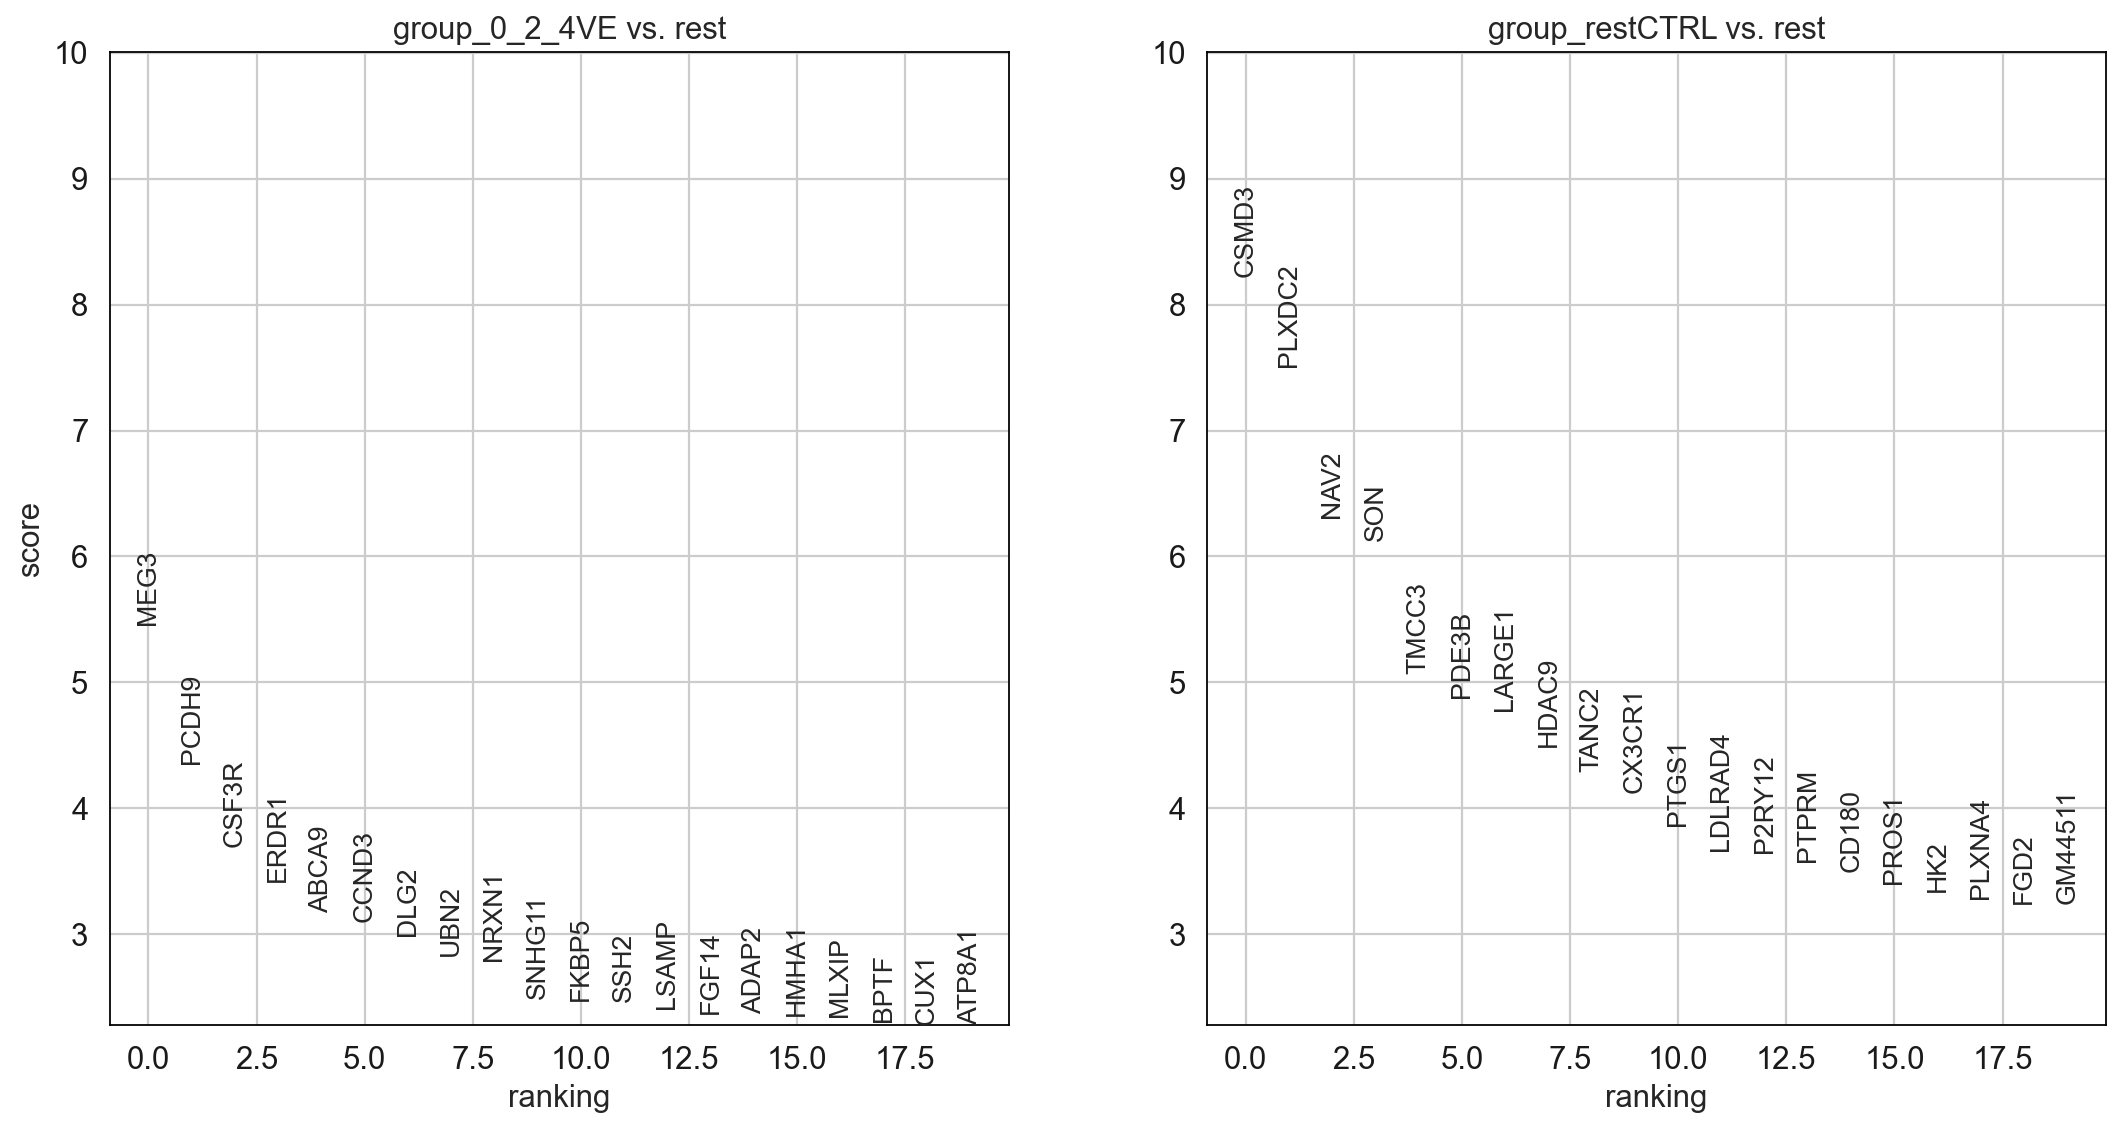

In [172]:
sc.set_figure_params(figsize=(8, 8))
key_ad = 'group_0_2_4VE'
n_genes = 100000

sc.tl.rank_genes_groups(adata_microglia_BS_to_compare, groupby='groups', key_added="group_0_2_4VE", method='wilcoxon')
sc.pl.rank_genes_groups(adata_microglia_BS_to_compare, key = 'group_0_2_4VE', fontsize=12)

result = adata_microglia_BS_to_compare.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [173]:
pval_table = pval_table.sort_values(by= 'group_0_2_4VE_l', ascending=False)
pval_table[(pval_table.group_0_2_4VE_p < 0.05) & (pval_table.group_0_2_4VE_l > 0.5)]

group_0_2_4VE_n  group_0_2_4VE_l  group_0_2_4VE_p group_restCTRL_n  \
1           PCDH9         0.961133         0.011955           PLXDC2   
0            MEG3         0.923252         0.000085            CSMD3   

   group_restCTRL_l  group_restCTRL_p  
1          1.145387      2.684519e-10  
0          1.925874      1.762352e-12

### MAST 

In [174]:
cell_type = 'Microlgia_Brainstem_C0_2_4'
expmat = pd.DataFrame(adata_microglia_BS_to_compare.X, columns = adata_microglia_BS_to_compare.var.index, index = adata_microglia_BS_to_compare.obs.index)
cdata = pd.DataFrame(adata_microglia_BS_to_compare.obs, columns=adata_microglia_BS_to_compare.obs.columns, index = adata_microglia_BS_to_compare.obs.index)
expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [175]:
start_time = timeit.default_timer()
MAST = './runMAST_clusters.R'
expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " )
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

In [177]:
# import the MAST results
mast_C0_2_4_res = pd.read_csv (filepath_or_buffer= '../DEA/Microlgia_Brainstem_C0_2_4/MAST_DEA_Microlgia_Brainstem_C0_2_4_RESULTS.csv')
print(mast_C0_2_4_res)

        gene             p     p.fdr.adj     logFC
0      CSMD3  8.267732e-12  7.239226e-08 -1.131216
1     PLXDC2  1.137783e-09  4.981215e-06 -0.716888
2       NAV2  3.127969e-09  9.129498e-06 -0.887679
3        SON  7.003863e-07  1.533146e-03 -1.389902
4      TMCC3  8.135059e-06  1.424611e-02 -0.551752
...      ...           ...           ...       ...
8751    ZXDC  4.265736e-01  1.000000e+00 -0.122057
8752  ZYG11B  2.924695e-01  1.000000e+00  0.071338
8753     ZYX  7.285622e-01  1.000000e+00 -0.040668
8754   ZZEF1  1.185970e-01  1.000000e+00 -0.366767
8755    ZZZ3  7.748287e-01  1.000000e+00  0.130181

[8756 rows x 4 columns]


In [182]:
#filter DE results
mast_C0_2_4_res = mast_C0_2_4_res.sort_values(by='logFC', ascending=False)
# Upregulated genes
mast_C0_2_4_res_UP = mast_C0_2_4_res[(mast_C0_2_4_res['logFC'] >=0.01) & (mast_C0_2_4_res['p.fdr.adj'] <= 0.05)]
mast_C0_2_4_res_DOWN = mast_C0_2_4_res[(mast_C0_2_4_res['logFC'] <=0.01) & (mast_C0_2_4_res['p.fdr.adj'] <= 0.05)]
mast_C0_2_4_res_UP

gene         p  p.fdr.adj     logFC
5  NRXN1  0.000016   0.022698  0.601677

## **T-test** Compare Clusters 3 (VE) Versus All Controls

In [408]:
adata_microglia_BS_copy = adata_microglia_BS.copy()
# For loop creating a groups for pairwise comparison
adata_microglia_BS_copy.obs['groups'] = ['group_3VE' if int(i) in [3] and j == 'VE' else 'group_restCTRL' if j == 'Control' else 'Error' for i,j in zip(adata_microglia_BS_copy.obs['PhenoGraph_clusters_mic_BS'],adata_microglia_BS_copy.obs['Condition'] )]


In [409]:
adata_microglia_BS_copy.obs.groups.value_counts()

Error             295
group_restCTRL     90
group_3VE          77
Name: groups, dtype: int64

In [410]:
# select only cells that are in these 2 groups that I want to compare
adata_microglia_BS_to_compare = adata_microglia_BS_copy[[group in ['group_restCTRL', 'group_3VE'] for group in adata_microglia_BS_copy.obs['groups']],].copy()
adata_microglia_BS_to_compare.obs.groups.value_counts()

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


group_restCTRL    90
group_3VE         77
Name: groups, dtype: int64

... storing 'groups' as categorical


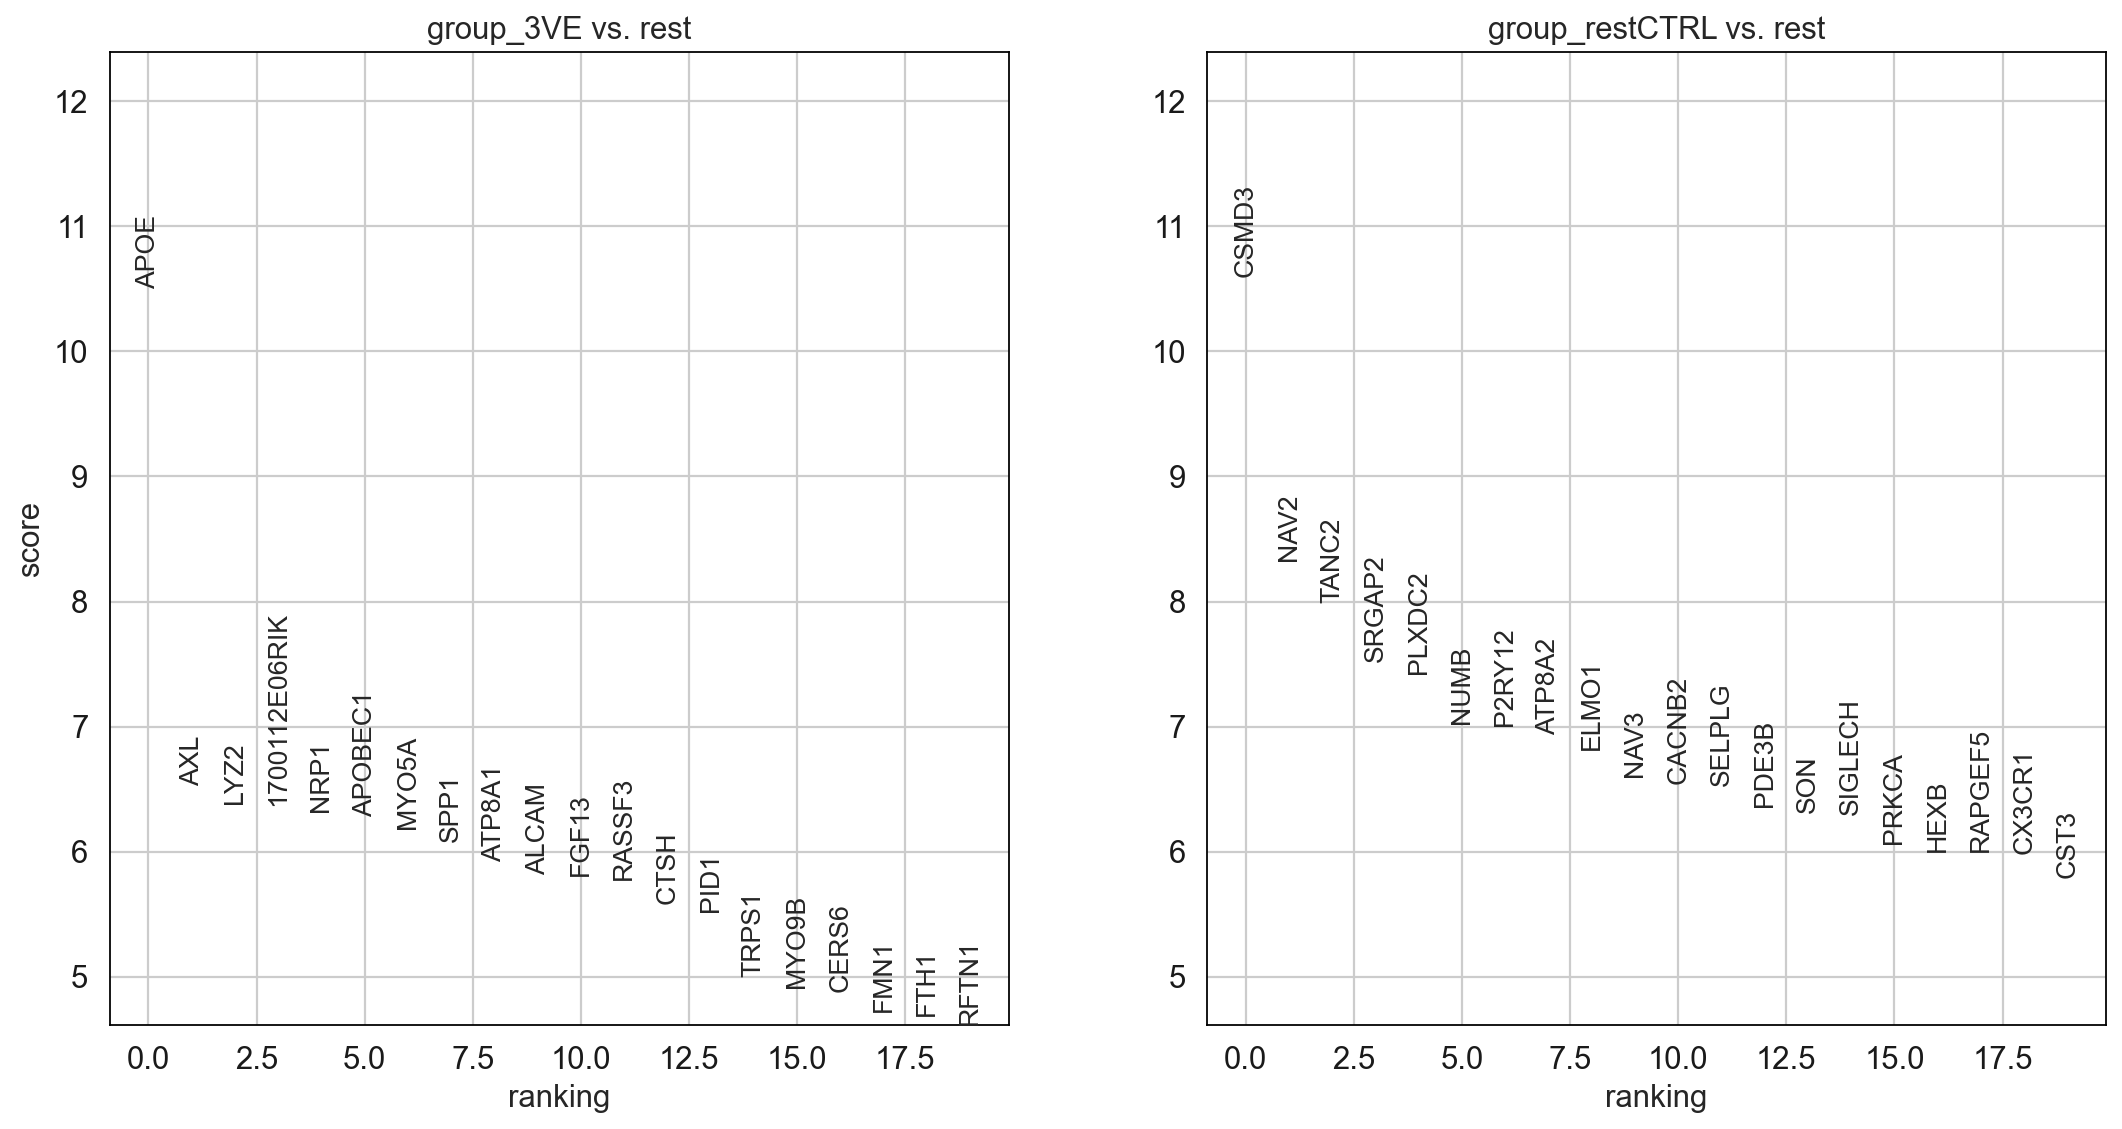

In [283]:
sc.set_figure_params(figsize=(8, 8))
key_ad = 'group_3VE'
n_genes = 100000

sc.tl.rank_genes_groups(adata_microglia_BS_to_compare, groupby='groups', key_added="group_3VE", method='wilcoxon')
sc.pl.rank_genes_groups(adata_microglia_BS_to_compare, key = 'group_3VE', fontsize=12)

result = adata_microglia_BS_to_compare.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [506]:
pval_table = pval_table.sort_values(by= 'group_3VE_l', ascending=False)
pval_table[(pval_table.group_3VE_p < 0.05) & (pval_table.group_3VE_l > 0.5)].head(5)

group_3VE_n  group_3VE_l   group_3VE_p group_restCTRL_n  group_restCTRL_l  \
0         APOE    10.812362  3.918327e-22            CSMD3          6.133454   
7         SPP1     7.003513  4.602902e-07           ATP8A2          3.391422   
1          AXL     6.994825  4.199521e-08             NAV2          3.276048   
2         LYZ2     6.705591  1.017476e-07            TANC2          2.394759   
20         FN1     6.066343  7.749826e-04          SLC24A3          3.930081   

    group_restCTRL_p  
0       2.718034e-22  
7       4.007761e-09  
1       2.533942e-13  
2       3.010326e-12  
20      2.237209e-06

### MAST 

In [285]:
cell_type = 'Microlgia_Brainstem_C3'
expmat = pd.DataFrame(adata_microglia_BS_to_compare.X, columns = adata_microglia_BS_to_compare.var.index, index = adata_microglia_BS_to_compare.obs.index)
cdata = pd.DataFrame(adata_microglia_BS_to_compare.obs, columns=adata_microglia_BS_to_compare.obs.columns, index = adata_microglia_BS_to_compare.obs.index)
expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [286]:
start_time = timeit.default_timer()
MAST = './runMAST_clusters.R'
expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " )
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

In [411]:
# import the MAST results
mast_C3_res = pd.read_csv (filepath_or_buffer= '../DEA/Microlgia_Brainstem_C3/MAST_DEA_Microlgia_Brainstem_C3_RESULTS.csv')
print(mast_C3_res)

        gene             p     p.fdr.adj     logFC
0       APOE  1.128765e-41  9.883468e-38  6.620627
1      CSMD3  8.422488e-41  3.687365e-37 -4.043410
2       NAV2  9.122861e-20  2.662659e-16 -2.201519
3        AXL  2.270981e-18  4.971177e-15  2.165052
4       LYZ2  1.191019e-16  1.489795e-13  2.653277
...      ...           ...           ...       ...
8751   ZWINT  7.345536e-01  1.000000e+00  0.101449
8752    ZXDC  7.304033e-01  1.000000e+00 -0.098649
8753  ZYG11B  6.901417e-01  1.000000e+00  0.106256
8754     ZYX  7.894965e-01  1.000000e+00 -0.063654
8755    ZZZ3  7.747486e-01  1.000000e+00 -0.093555

[8756 rows x 4 columns]


In [509]:
#filter DE results
mast_C3_res = mast_C3_res.sort_values(by='logFC', ascending=False)
mast_C3_res_sig = mast_C3_res[mast_C3_res['p.fdr.adj'] <= 0.05]
# Upregulated genes
mast_C3_res_UP = mast_C3_res[(mast_C3_res['logFC'] >=0.5) & (mast_C3_res['p.fdr.adj'] <= 0.05)]
mast_C3_res_DOWN = mast_C3_res[(mast_C3_res['logFC'] <=-0.5) & (mast_C3_res['p.fdr.adj'] <= 0.05)]
mast_C3_res_DOWN.shape

(84, 4)

### Volcano plot

In [510]:
mast_C3_res = mast_C3_res.dropna()

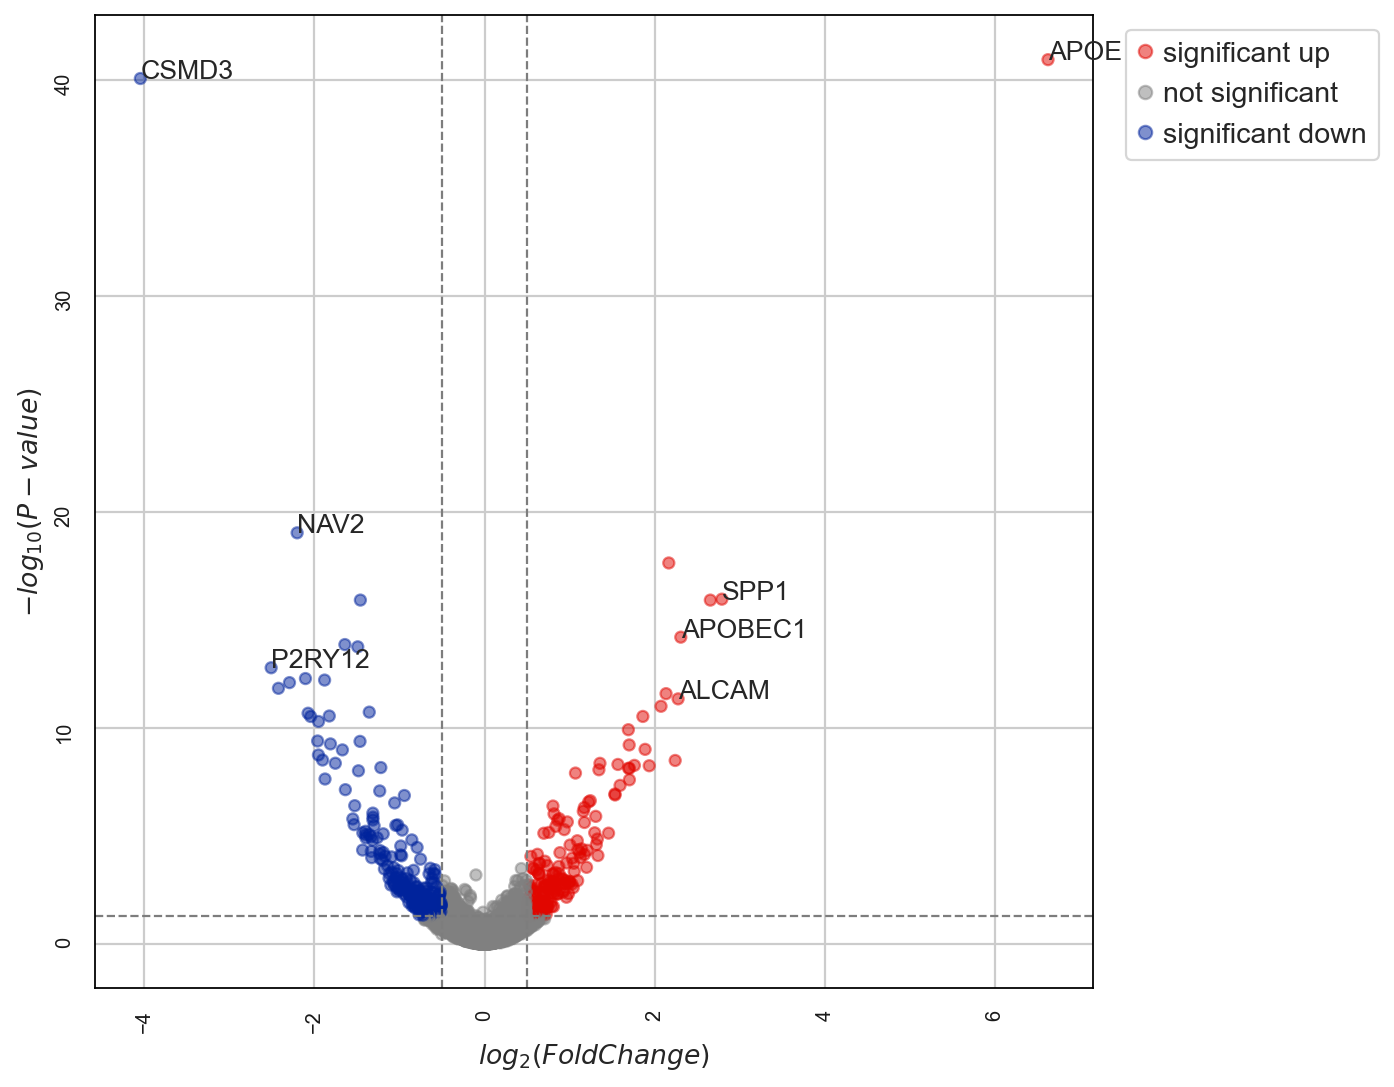

In [513]:
visuz.gene_exp.volcano(df=mast_C3_res, lfc='logFC', pv='p',show=True, plotlegend=True, legendpos='upper right', 
    legendanchor=(1.3,1),color=("#E10600FF", "grey", "#00239CFF"), valpha=0.5, dotsize=25, geneid="gene", 
                       genenames=('APOE', 'SPP1', 'APOBEC1','ALCAM','CSMD3', 'NAV2','P2RY12'),  sign_line=True, gfont = 12, dim=(8,8), axlabelfontsize = 12, lfc_thr=(0.5, 0.5))

### HEATMAP OF TOP10 UPREGULATED GENES

In [413]:
marker_genes_dict = dict()

marker_genes_dict = {'C3_UP': mast_C3_res_UP['gene'].head(20)}

marker_genes_dict = marker_genes_dict['C3_UP'].drop(24)

... storing 'groups' as categorical
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


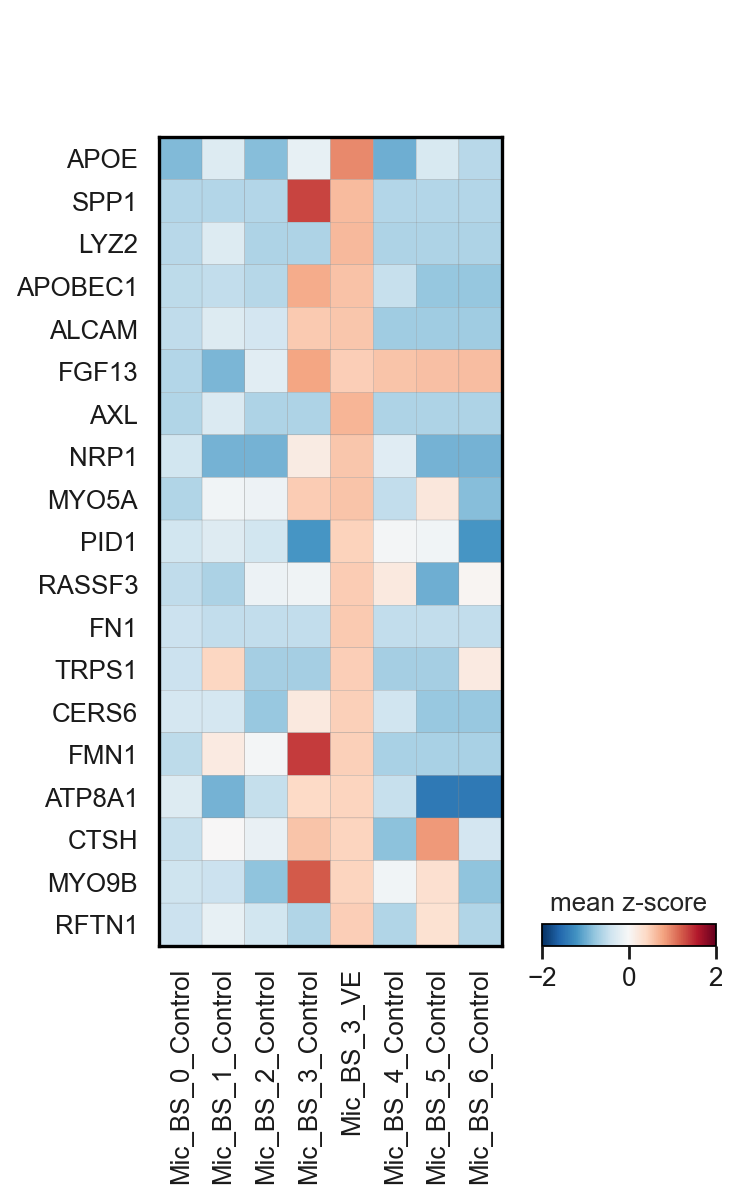

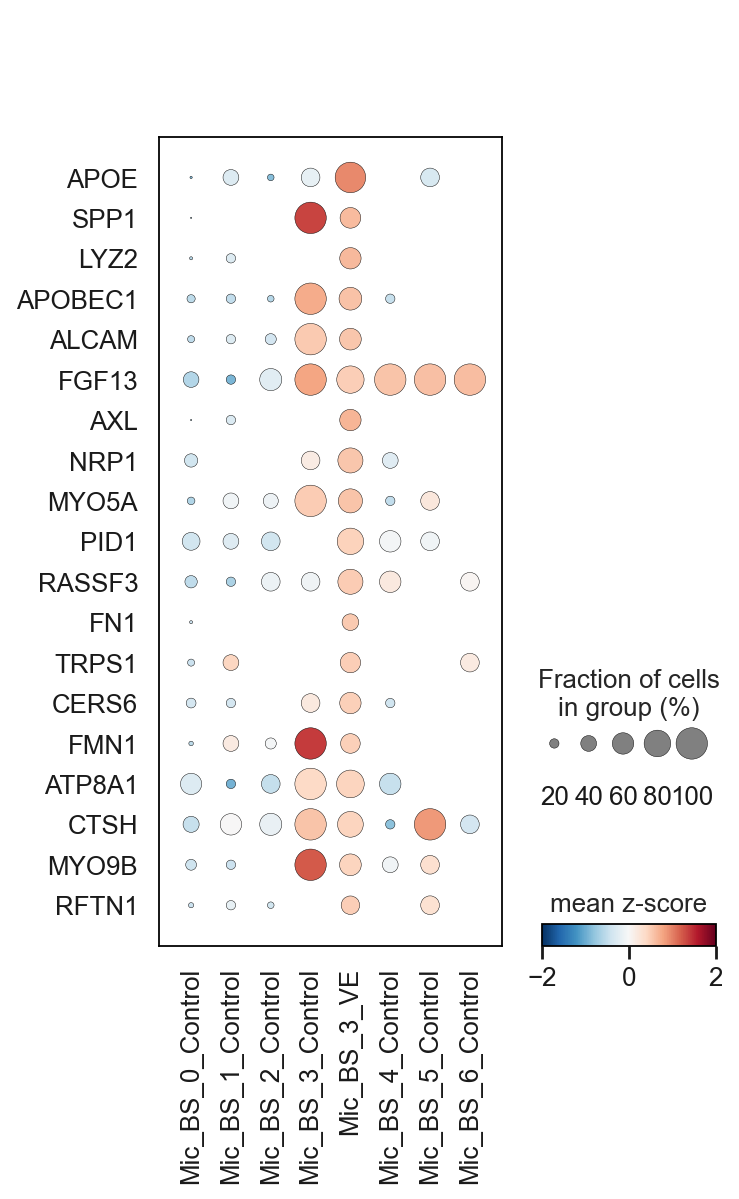

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


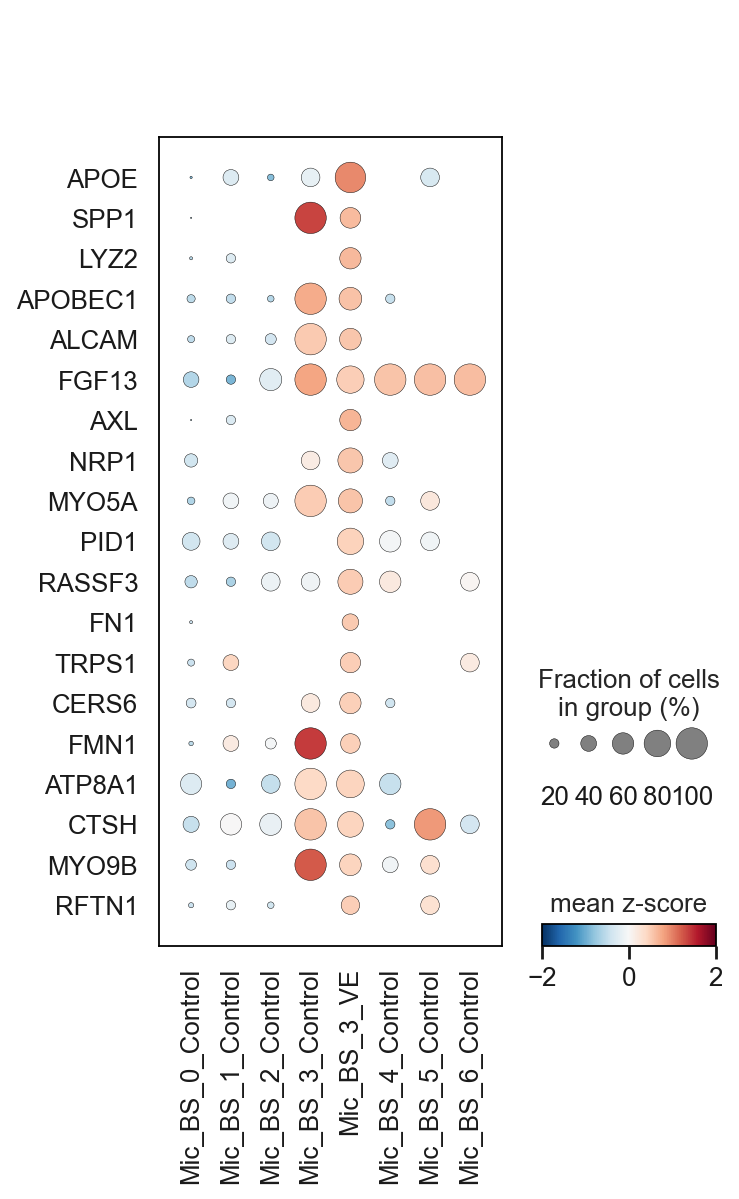

In [414]:
adata_microglia_BS_to_compare.layers['scaled'] = sc.pp.scale(adata_microglia_BS_to_compare, copy=True).X
sc.pl.matrixplot(adata_microglia_BS_to_compare, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_BS_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_microglia_BS_to_compare, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_microglia_BS_to_compare, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

### Enricher

In [372]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mmast_C3_res_n_list = mast_C3_res_sig.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mmast_C3_res_n_list,
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2018'],
                     description='pathway',
                     cutoff = 0.5)

In [373]:
enr_res.results.head(30)

Gene_set  \
0   GO_Biological_Process_2018   
1   GO_Biological_Process_2018   
2   GO_Biological_Process_2018   
3   GO_Biological_Process_2018   
4   GO_Biological_Process_2018   
5   GO_Biological_Process_2018   
6   GO_Biological_Process_2018   
7   GO_Biological_Process_2018   
8   GO_Biological_Process_2018   
9   GO_Biological_Process_2018   
10  GO_Biological_Process_2018   
11  GO_Biological_Process_2018   
12  GO_Biological_Process_2018   
13  GO_Biological_Process_2018   
14  GO_Biological_Process_2018   
15  GO_Biological_Process_2018   
16  GO_Biological_Process_2018   
17  GO_Biological_Process_2018   
18  GO_Biological_Process_2018   
19  GO_Biological_Process_2018   
20  GO_Biological_Process_2018   
21  GO_Biological_Process_2018   
22  GO_Biological_Process_2018   
23  GO_Biological_Process_2018   
24  GO_Biological_Process_2018   
25  GO_Biological_Process_2018   
26  GO_Biological_Process_2018   
27  GO_Biological_Process_2018   
28  GO_Biological_Process_2018   
29  GO_Biological_Process_2018   

                                                 Term Overlap       P-value  \
0   negative regulation of endothelial cell prolif...    6/30  4.004856e-07   
1               neutrophil degranulation (GO:0043312)  18/479  1.231179e-06   
2   neutrophil activation involved in immune respo...  18/483  1.385679e-06   
3           neutrophil mediated immunity (GO:0002446)  18/487  1.557570e-06   
4   substrate adhesion-dependent cell spreading (G...    5/32  1.394811e-05   
5   cell morphogenesis involved in differentiation...    6/54  1.432905e-05   
6    retinal ganglion cell axon guidance (GO:0031290)     3/6  1.813893e-05   
7          regulation of bone resorption (GO:0045124)    4/22  5.697959e-05   
8   regulation of small GTPase mediated signal tra...   8/140  7.303696e-05   
9   positive regulation of bone remodeling (GO:004...    3/10  1.057244e-04   
10  positive regulation of bone resorption (GO:004...    3/10  1.057244e-04   
11  regulation of endothelial cell proliferation (...    6/79  1.259122e-04   
12      protein localization to membrane (GO:0072657)   8/160  1.847404e-04   
13  positive regulation of signal transduction (GO...   9/206  2.037537e-04   
14          regulation of cell migration (GO:0030334)  11/316  2.984371e-04   
15  positive regulation of cell migration (GO:0030...   9/221  3.425039e-04   
16    substrate-dependent cell migration (GO:0006929)    3/15  3.866324e-04   
17     extracellular matrix organization (GO:0030198)   9/229  4.437823e-04   
18  regulation of endothelial cell migration (GO:0...    5/69  5.806903e-04   
19  vascular endothelial growth factor receptor si...    5/70  6.204447e-04   
20                     B cell activation (GO:0042113)    5/73  7.519953e-04   
21  positive regulation of epithelial cell migrati...    5/74  8.001558e-04   
22  negative regulation of apoptotic process (GO:0...  13/485  1.031653e-03   
23  regulation of macrophage apoptotic process (GO...     2/6  1.396614e-03   
24  toll-like receptor signaling pathway (GO:0002224)    5/86  1.573984e-03   
25       Ras protein signal transduction (GO:0007265)   8/223  1.643239e-03   
26  positive regulation of macromolecule metabolic...   9/276  1.654232e-03   
27            regulation of angiogenesis (GO:0045765)   7/177  1.841658e-03   
28  substrate-dependent cell migration, cell exten...     2/7  1.942657e-03   
29  positive regulation of lipid transport (GO:003...     2/7  1.942657e-03   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.000601            0                     0   26.026316   
1           0.000601            0                     0    4.243023   
2           0.000601            0                     0    4.205654   
3           0.000601            0                     0    4.168923   
4           0.003685            0                     0   19.174908   
5           0.003685            0                     0   12.997368   
6           0.003998

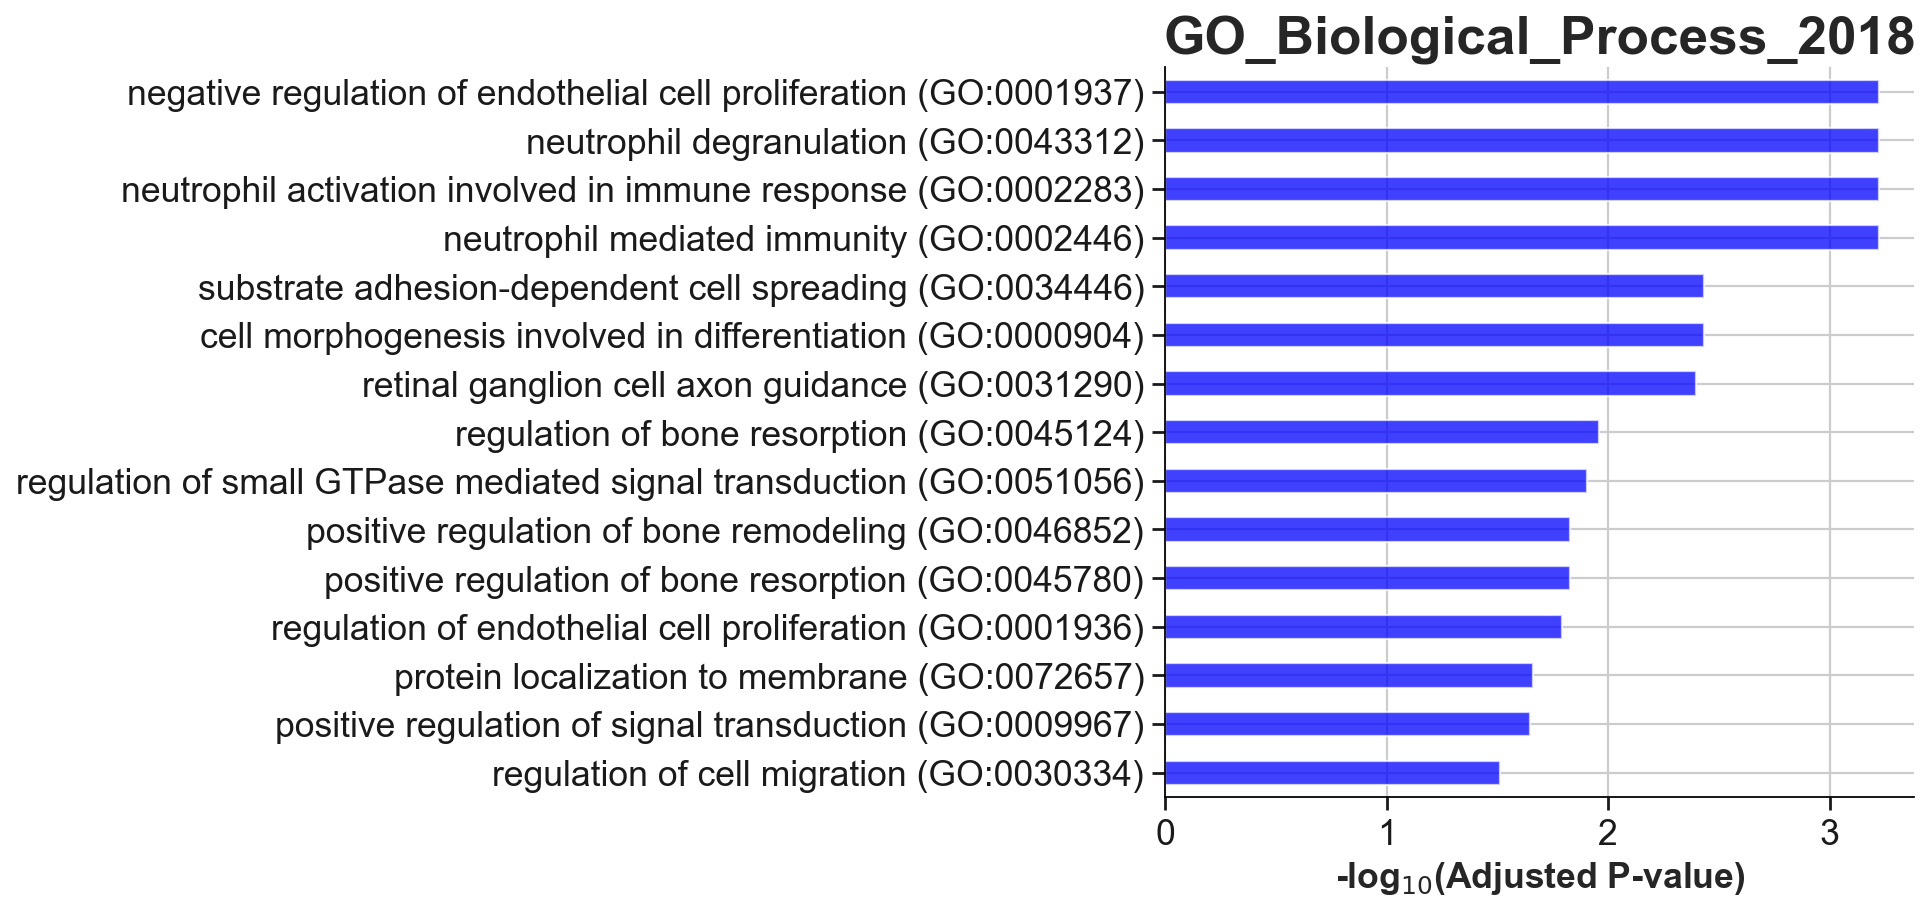

In [375]:
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2018',top_term=15,color='blue',figsize=(6,6))

In [ ]:
#gseapy.dotplot(enr_res.res2d, title='WikiPathways_2019_Mouse',cmap='viridis_r', top_term=20, figsize=(6,8))